#### Importing the necessary packages:

In [25]:
# Standard packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
# Train-test split creation
from sklearn.model_selection import train_test_split
# Oversampling
from imblearn.over_sampling import SMOTE
# Pipeline creation
from imblearn.pipeline import Pipeline
# Performing search over tuning grid
from sklearn.model_selection import GridSearchCV, StratifiedKFold
# Transforming columns to arrays
from sklearn.compose import ColumnTransformer
# Standardazing the data
from sklearn.preprocessing import StandardScaler
# Importing the performance metrics
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score, recall_score, precision_score, auc, roc_curve, confusion_matrix, f1_score
# The Logistic Regression
from sklearn.linear_model import LogisticRegression
# The KNN classifier
from sklearn.neighbors import KNeighborsClassifier
# The LGBM classifier
import lightgbm as ltb
# Surpress warning
import warnings
warnings.filterwarnings("ignore")

### Creation of different data sets for different models:

I start by importing the various data sets.

In [2]:
# Financial fundamentals
FF = pd.read_csv('FF_features.csv')

# Restatements
RES = pd.read_csv('Res_cases.csv')

# CIK's of the restatements
res_ciks = pd.read_csv('res_ciks.csv')

# Readability features
read = pd.read_csv('read_features.csv')

# Topic features
topic = pd.read_csv('topic_features.csv')

# Sentiment features
sen = pd.read_csv('sent_features.csv')

# Cosine similarity
sim = pd.read_csv('cos_sim.csv')

# Changing the type of some columns for later standardization
sen['Pos_MDA'] = sen['Pos_MDA'].astype('float')
sen['Neg_MDA'] = sen['Neg_MDA'].astype('float')
read['Length_MDA'] = read['Length_MDA'].astype('float')

sen['Pos_Q1'] = sen['Pos_Q1'].astype('float')
sen['Neg_Q1'] = sen['Neg_Q1'].astype('float')
read['Length_Q1'] = read['Length_Q1'].astype('float')

sen['Pos_Q2'] = sen['Pos_Q2'].astype('float')
sen['Neg_Q2'] = sen['Neg_Q2'].astype('float')
read['Length_Q2'] = read['Length_Q2'].astype('float')

sen['Pos_Q3'] = sen['Pos_Q3'].astype('float')
sen['Neg_Q3'] = sen['Neg_Q3'].astype('float')
read['Length_Q3'] = read['Length_Q3'].astype('float')

sen['Pos_Q4'] = sen['Pos_Q4'].astype('float')
sen['Neg_Q4'] = sen['Neg_Q4'].astype('float')
read['Length_Q4'] = read['Length_Q4'].astype('float')

Then we merge the data for the baseline models.

In [3]:
# Changing year to integer for merging
FF['year'] = FF['year'].astype('int')
RES['fraud'] = RES['fraud'].astype('int')

# Merging FF and RES based on year and cik, keeping all rows of FF and only the matching of RES
merged = pd.merge(FF, RES, on=['year', 'cik'], how = 'outer', indicator = True)
merged = merged[merged['_merge'] != 'right_only']

# Adding a column for the target variable
merged['Target'] = merged['_merge'].apply(lambda x: 1 if x == 'both' else 0)
merged = merged.drop(columns=['_merge'])

# Changing the NA's to 0
merged['fraud'] = merged['fraud'].fillna(0)
merged['res'] = merged['res'].fillna(0)

# Eclude Non-FRs ciks of firms that have had a restatement to prevent leakage
exclude_cik = res_ciks['cik'].tolist()
merged = merged[~((merged['cik'].isin(exclude_cik)) & (merged['Target'] != 1))]

# Finally, we drop any na's
baseline = merged.dropna()

Next we make 3 extra dataframes, one containing MD&A features, one containing ECT features, and one containing both plus cosine similarity.

In [4]:
# We drop a column which has been included by mistake
topic = topic.drop(columns='Unnamed: 0')

# Defining the MD&A features
read_mda = read[['cik','year','FOG_MDA','Length_MDA']]
topic_mda = topic[['cik','year', 'Topic_MDA']]
sen_mda = sen[['cik','year','Pos_MDA','Pol_MDA','Sub_MDA','Neg_MDA']]

# Defining the ECT features
read_ect = read[['cik','year','FOG_Q1','Length_Q1','FOG_Q2','Length_Q2',
                'FOG_Q3','Length_Q3','FOG_Q4','Length_Q4']]
topic_ect = topic[['cik','year','Topic_Q1','Topic_Q2','Topic_Q3','Topic_Q4']]
sen_ect = sen[['cik','year','Pos_MDA','Pol_MDA','Sub_MDA','Neg_MDA', 'Pos_Q1','Pol_Q1','Sub_Q1','Neg_Q1',
              'Pos_Q2','Pol_Q2','Sub_Q2','Neg_Q2', 'Pos_Q3','Pol_Q3','Sub_Q3','Neg_Q3',
              'Pos_Q4','Pol_Q4','Sub_Q4','Neg_Q4']]

# Merging the data together for the MD&A dataframe
merged = pd.merge(baseline, read_mda, on=['year', 'cik'], how = 'inner')
merged = pd.merge(merged, topic_mda, on=['year', 'cik'], how = 'inner')
merged = pd.merge(merged, sen_mda, on=['year', 'cik'], how = 'inner')
mda_model = merged.dropna()
mda_model = mda_model.drop_duplicates(subset=['cik','year'])

# Creating dummies for the topics, year, and industry
mda_model['Topic_MDA'] = mda_model['Topic_MDA'].astype('category')
mda_model['year'] = mda_model['year'].astype('category')
mda_model['SIC'] = mda_model['SIC'].astype('category')
mda_model = pd.get_dummies(mda_model, columns=['Topic_MDA', 'year', 'SIC'])

# Merging the data together for the ECT dataframe
merged = pd.merge(baseline, read_ect, on=['year', 'cik'], how = 'inner')
merged = pd.merge(merged, topic_ect, on=['year', 'cik'], how = 'inner')
merged = pd.merge(merged, sen_ect, on=['year', 'cik'], how = 'inner')
ect_model = merged.dropna()
ect_model = ect_model.drop_duplicates(subset=['cik','year'])

# Creating dummies for the topics, year, and industry
ect_model['Topic_Q1'] = ect_model['Topic_Q1'].astype('category')
ect_model['Topic_Q2'] = ect_model['Topic_Q2'].astype('category')
ect_model['Topic_Q3'] = ect_model['Topic_Q3'].astype('category')
ect_model['Topic_Q4'] = ect_model['Topic_Q4'].astype('category')
ect_model['year'] = ect_model['year'].astype('category')
ect_model['SIC'] = ect_model['SIC'].astype('category')
ect_model = pd.get_dummies(ect_model, columns=['Topic_Q1', 'Topic_Q2', 'Topic_Q3', 'Topic_Q4','year', 'SIC'])

# Merging the data together for the full dataframe
merged = pd.merge(baseline, read, on=['year', 'cik'], how = 'inner')
merged = pd.merge(merged, topic, on=['year', 'cik'], how = 'inner')
merged = pd.merge(merged, sen, on=['year', 'cik'], how = 'inner')
merged = pd.merge(merged, sim, on=['year', 'cik'], how = 'inner')
full_model = merged.dropna()
full_model = full_model.drop_duplicates(subset=['cik','year'])

# Creating dummies for the topics, year, and industry
full_model['Topic_Q1'] = full_model['Topic_Q1'].astype('category')
full_model['Topic_Q2'] = full_model['Topic_Q2'].astype('category')
full_model['Topic_Q3'] = full_model['Topic_Q3'].astype('category')
full_model['Topic_Q4'] = full_model['Topic_Q4'].astype('category')
full_model['Topic_MDA'] = full_model['Topic_MDA'].astype('category')
full_model['year'] = full_model['year'].astype('category')
full_model['SIC'] = full_model['SIC'].astype('category')
full_model = pd.get_dummies(full_model, columns=['Topic_Q1', 'Topic_Q2', 'Topic_Q3', 'Topic_Q4', 'Topic_MDA', 'year', 'SIC'])

# Finally, we create dummies for the baseline year and industry
baseline['year'] = baseline['year'].astype('category')
baseline['SIC'] = baseline['SIC'].astype('category')
baseline = pd.get_dummies(baseline, columns=['year','SIC'])

In [5]:
# Exporting the datasets (the full model as input for SAPSO)
baseline.to_csv('baseline_data.csv', index=False)
mda_model.to_csv('mda_model_data.csv', index=False)
ect_model.to_csv('ect_model_data.csv', index=False)
full_model.to_csv('sapso_data.csv', index=False)

### Defining ECM

I define a function of ECM that can both be used for tuning as for final performance. It considers a range of thresholds and returns the minimum ECM score of these thresholds. This is done to ensure that the lowest ECM is returned instead of the ECM at the default thresholds of the models.

In [6]:
# Defining the parameters for ECM
P_FR = 0.0324
P_NonFR = (1 - P_FR)
C_FP = 1
C_FN = 20

In [7]:
# Defining thresholds and number of thresholds for the tuning of ECM
rlr_p_range = np.arange(0.45, 0.55, 0.0001) 
rlr_n_thresholds = len(rlr_p_range)

# Defining the function for the performance metric in the gridsearch
def RLR_ECM(y_test, y_pred_prob):
    ecm_scores = np.zeros(rlr_n_thresholds)
    for i, p in enumerate(rlr_p_range):
        y_pred = np.where(y_pred_prob >= p, 1, 0)
        fn = np.sum((y_test == 1) & (y_pred == 0))
        fp = np.sum((y_test == 0) & (y_pred == 1))
        p = np.sum(y_test == 1)
        n = np.sum(y_test == 0)
        score = C_FN * P_FR * (fn/p) + C_FP * P_NonFR * (fp/(n-p))
        ecm_scores[i] = score
    return np.min(ecm_scores)

# Creating a scorer based on ECM
rlr_scoring = make_scorer(RLR_ECM, greater_is_better=False, needs_proba=True)

In [8]:
# Defining thresholds and number of thresholds for the tuning of ECM
knn_p_range = np.arange(0.5, 1.0, 0.0005) 
knn_n_thresholds = len(knn_p_range)

# Defining the function for the performance metric in the gridsearch
def KNN_ECM(y_test, y_pred_prob):
    ecm_scores = np.zeros(knn_n_thresholds)
    for i, p in enumerate(knn_p_range):
        y_pred = np.where(y_pred_prob >= p, 1, 0)
        fn = np.sum((y_test == 1) & (y_pred == 0))
        fp = np.sum((y_test == 0) & (y_pred == 1))
        p = np.sum(y_test == 1)
        n = np.sum(y_test == 0)
        score = C_FN * P_FR * (fn/p) + C_FP * P_NonFR * (fp/(n-p))
        ecm_scores[i] = score
    return np.min(ecm_scores)

# Creating a scorer based on ECM
knn_scoring = make_scorer(KNN_ECM, greater_is_better=False, needs_proba=True)

In [9]:
# Defining thresholds and number of thresholds for the tuning of ECM
lgbm_p_range = np.arange(0.0, 0.1, 0.0001) 
lgbm_n_thresholds = len(lgbm_p_range)

# Defining the function for the performance metric in the gridsearch
def LGBM_ECM(y_test, y_pred_prob):
    ecm_scores = np.zeros(lgbm_n_thresholds)
    for i, p in enumerate(lgbm_p_range):
        y_pred = np.where(y_pred_prob >= p, 1, 0)
        fn = np.sum((y_test == 1) & (y_pred == 0))
        fp = np.sum((y_test == 0) & (y_pred == 1))
        p = np.sum(y_test == 1)
        n = np.sum(y_test == 0)
        score = C_FN * P_FR * (fn/p) + C_FP * P_NonFR * (fp/(n-p))
        ecm_scores[i] = score
    return np.min(ecm_scores)

# Creating a scorer based on ECM
lgbm_scoring = make_scorer(LGBM_ECM, greater_is_better=False, needs_proba=True)

In [10]:
# Defining a function that will eventually extract the best ECM for the optimal threshold
def ECM(y_test, y_pred):
    fn = np.sum((y_test == 1) & (y_pred == 0))
    fp = np.sum((y_test == 0) & (y_pred == 1))    
    p = np.sum(y_test == 1)
    n = np.sum(y_test == 0)
    
    score = C_FN * P_FR * (fn/p) + C_FP * P_NonFR * (fp/n)
    return score

### Splitting Target variable and Features

In [11]:
# Basline
y_b = pd.Series(data=baseline['Target'])
X_b = baseline.drop(columns=['cik','fraud', 'res', 'Target'])

# MD&A
y_m = pd.Series(data=mda_model['Target'])
X_m = mda_model.drop(columns=['cik','fraud', 'res', 'Target'])

# ECT
y_e = pd.Series(data=ect_model['Target'])
X_e = ect_model.drop(columns=['cik','fraud', 'res', 'Target'])

# Full
y_f = pd.Series(data=full_model['Target'])
X_f = full_model.drop(columns=['cik','fraud', 'res', 'Target'])

### Feature Count

In [12]:
print('The baseline models consist of:',len(X_b.columns),'features, including dummies.')
print('The MD&A models consist of:',len(X_m.columns),'features, including dummies.')
print('The ECT models consist of:',len(X_e.columns),'features, including dummies.')
print('The full models consist of:',len(X_f.columns),'features, including dummies.')

The baseline models consist of: 407 features, including dummies.
The MD&A models consist of: 453 features, including dummies.
The ECT models consist of: 595 features, including dummies.
The full models consist of: 638 features, including dummies.


### Creating Train-Test Split and defining CV folds

In [13]:
### Split the data set into test and train
# Baseline
X_b_train, X_b_test, y_b_train, y_b_test = train_test_split(X_b, y_b, test_size=0.3, stratify=y_b,random_state=42)

# MD&A
X_m_train, X_m_test, y_m_train, y_m_test = train_test_split(X_m, y_m, test_size=0.3, stratify=y_m,random_state=42)

# ECT
X_e_train, X_e_test, y_e_train, y_e_test = train_test_split(X_e, y_e, test_size=0.3, stratify=y_e,random_state=42)

# Full
X_f_train, X_f_test, y_f_train, y_f_test = train_test_split(X_f, y_f, test_size=0.3, stratify=y_f,random_state=42)

# Defining CV folds
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=25)

### Defining numerical and non-numerical columns for standardization

In [14]:
# Numerical columns - Baseline
num_cols_b = list(X_b_train.select_dtypes(include=['float']).columns)
# Non numerical columns - Baseline
non_num_cols_b = list(X_b_train.select_dtypes(exclude=['float']).columns)

# Numerical columns - MD&A
num_cols_m = list(X_m_train.select_dtypes(include=['float']).columns)
# Non numerical columns - MD&A
non_num_cols_m = list(X_m_train.select_dtypes(exclude=['float']).columns)

# Numerical columns - ECT
num_cols_e = list(X_e_train.select_dtypes(include=['float']).columns)
# Non numerical columns - ECT
non_num_cols_e = list(X_e_train.select_dtypes(exclude=['float']).columns)

# Numerical columns - Full
num_cols_f = list(X_f_train.select_dtypes(include=['float']).columns)
# Non numerical columns - Full
non_num_cols_f = list(X_f_train.select_dtypes(exclude=['float']).columns)

In [29]:
y_b_test.sum()

25

# Logistic Ridge Regression

## Baseline Performance

In [80]:
# Preprocessor
rlr_b_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols_b),
        ('non_num', 'passthrough', non_num_cols_b)
    ])

# Pipeline steps
rlr_b_steps = [
    ("prep", rlr_b_preprocessor),
    ("over", SMOTE(random_state=42)), 
    ("lr", LogisticRegression(random_state=21, solver='lbfgs', max_iter=1000000)), 
]

# Pipeline
rlr_b_pipeline = Pipeline(rlr_b_steps)

# Set up the grid search parameters
rlr_b_parameters = {'lr__C': np.logspace(-7,1,50),
                 'lr__penalty': ['l2']}

# Setting up the GridSearch with CV
rlr_b_grid = GridSearchCV(rlr_b_pipeline, rlr_b_parameters, cv=kf, verbose = 10, scoring=rlr_scoring)

# Fit the grid search object to the training data
rlr_b_grid.fit(X_b_train, y_b_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5; 1/50] START lr__C=1e-07, lr__penalty=l2................................
[CV 1/5; 1/50] END lr__C=1e-07, lr__penalty=l2;, score=-0.631 total time=   0.4s
[CV 2/5; 1/50] START lr__C=1e-07, lr__penalty=l2................................
[CV 2/5; 1/50] END lr__C=1e-07, lr__penalty=l2;, score=-0.450 total time=   0.4s
[CV 3/5; 1/50] START lr__C=1e-07, lr__penalty=l2................................
[CV 3/5; 1/50] END lr__C=1e-07, lr__penalty=l2;, score=-0.449 total time=   0.4s
[CV 4/5; 1/50] START lr__C=1e-07, lr__penalty=l2................................
[CV 4/5; 1/50] END lr__C=1e-07, lr__penalty=l2;, score=-0.576 total time=   0.5s
[CV 5/5; 1/50] START lr__C=1e-07, lr__penalty=l2................................
[CV 5/5; 1/50] END lr__C=1e-07, lr__penalty=l2;, score=-0.597 total time=   0.5s
[CV 1/5; 2/50] START lr__C=1.4563484775012443e-07, lr__penalty=l2...............
[CV 1/5; 2/50] END lr__C=1.4563484775012443e-07

[CV 2/5; 10/50] END lr__C=2.94705170255181e-06, lr__penalty=l2;, score=-0.416 total time=   0.4s
[CV 3/5; 10/50] START lr__C=2.94705170255181e-06, lr__penalty=l2................
[CV 3/5; 10/50] END lr__C=2.94705170255181e-06, lr__penalty=l2;, score=-0.414 total time=   0.4s
[CV 4/5; 10/50] START lr__C=2.94705170255181e-06, lr__penalty=l2................
[CV 4/5; 10/50] END lr__C=2.94705170255181e-06, lr__penalty=l2;, score=-0.487 total time=   0.5s
[CV 5/5; 10/50] START lr__C=2.94705170255181e-06, lr__penalty=l2................
[CV 5/5; 10/50] END lr__C=2.94705170255181e-06, lr__penalty=l2;, score=-0.507 total time=   0.4s
[CV 1/5; 11/50] START lr__C=4.291934260128778e-06, lr__penalty=l2...............
[CV 1/5; 11/50] END lr__C=4.291934260128778e-06, lr__penalty=l2;, score=-0.528 total time=   0.4s
[CV 2/5; 11/50] START lr__C=4.291934260128778e-06, lr__penalty=l2...............
[CV 2/5; 11/50] END lr__C=4.291934260128778e-06, lr__penalty=l2;, score=-0.411 total time=   0.5s
[CV 3/5; 11

[CV 3/5; 19/50] END lr__C=8.68511373751352e-05, lr__penalty=l2;, score=-0.395 total time=   0.4s
[CV 4/5; 19/50] START lr__C=8.68511373751352e-05, lr__penalty=l2................
[CV 4/5; 19/50] END lr__C=8.68511373751352e-05, lr__penalty=l2;, score=-0.497 total time=   0.4s
[CV 5/5; 19/50] START lr__C=8.68511373751352e-05, lr__penalty=l2................
[CV 5/5; 19/50] END lr__C=8.68511373751352e-05, lr__penalty=l2;, score=-0.567 total time=   0.4s
[CV 1/5; 20/50] START lr__C=0.00012648552168552957, lr__penalty=l2..............
[CV 1/5; 20/50] END lr__C=0.00012648552168552957, lr__penalty=l2;, score=-0.569 total time=   0.4s
[CV 2/5; 20/50] START lr__C=0.00012648552168552957, lr__penalty=l2..............
[CV 2/5; 20/50] END lr__C=0.00012648552168552957, lr__penalty=l2;, score=-0.400 total time=   0.5s
[CV 3/5; 20/50] START lr__C=0.00012648552168552957, lr__penalty=l2..............
[CV 3/5; 20/50] END lr__C=0.00012648552168552957, lr__penalty=l2;, score=-0.402 total time=   0.5s
[CV 4/5

[CV 4/5; 28/50] END lr__C=0.0025595479226995332, lr__penalty=l2;, score=-0.598 total time=   0.5s
[CV 5/5; 28/50] START lr__C=0.0025595479226995332, lr__penalty=l2...............
[CV 5/5; 28/50] END lr__C=0.0025595479226995332, lr__penalty=l2;, score=-0.696 total time=   0.4s
[CV 1/5; 29/50] START lr__C=0.003727593720314938, lr__penalty=l2................
[CV 1/5; 29/50] END lr__C=0.003727593720314938, lr__penalty=l2;, score=-0.581 total time=   0.5s
[CV 2/5; 29/50] START lr__C=0.003727593720314938, lr__penalty=l2................
[CV 2/5; 29/50] END lr__C=0.003727593720314938, lr__penalty=l2;, score=-0.462 total time=   0.5s
[CV 3/5; 29/50] START lr__C=0.003727593720314938, lr__penalty=l2................
[CV 3/5; 29/50] END lr__C=0.003727593720314938, lr__penalty=l2;, score=-0.467 total time=   0.5s
[CV 4/5; 29/50] START lr__C=0.003727593720314938, lr__penalty=l2................
[CV 4/5; 29/50] END lr__C=0.003727593720314938, lr__penalty=l2;, score=-0.601 total time=   0.5s
[CV 5/5; 29

[CV 1/5; 38/50] END lr__C=0.10985411419875572, lr__penalty=l2;, score=-0.534 total time=   0.6s
[CV 2/5; 38/50] START lr__C=0.10985411419875572, lr__penalty=l2.................
[CV 2/5; 38/50] END lr__C=0.10985411419875572, lr__penalty=l2;, score=-0.431 total time=   0.7s
[CV 3/5; 38/50] START lr__C=0.10985411419875572, lr__penalty=l2.................
[CV 3/5; 38/50] END lr__C=0.10985411419875572, lr__penalty=l2;, score=-0.512 total time=   0.6s
[CV 4/5; 38/50] START lr__C=0.10985411419875572, lr__penalty=l2.................
[CV 4/5; 38/50] END lr__C=0.10985411419875572, lr__penalty=l2;, score=-0.548 total time=   0.6s
[CV 5/5; 38/50] START lr__C=0.10985411419875572, lr__penalty=l2.................
[CV 5/5; 38/50] END lr__C=0.10985411419875572, lr__penalty=l2;, score=-0.633 total time=   0.6s
[CV 1/5; 39/50] START lr__C=0.15998587196060574, lr__penalty=l2.................
[CV 1/5; 39/50] END lr__C=0.15998587196060574, lr__penalty=l2;, score=-0.520 total time=   0.6s
[CV 2/5; 39/50] STA

[CV 3/5; 47/50] END lr__C=3.2374575428176398, lr__penalty=l2;, score=-0.647 total time=   1.1s
[CV 4/5; 47/50] START lr__C=3.2374575428176398, lr__penalty=l2..................
[CV 4/5; 47/50] END lr__C=3.2374575428176398, lr__penalty=l2;, score=-0.596 total time=   1.1s
[CV 5/5; 47/50] START lr__C=3.2374575428176398, lr__penalty=l2..................
[CV 5/5; 47/50] END lr__C=3.2374575428176398, lr__penalty=l2;, score=-0.644 total time=   1.0s
[CV 1/5; 48/50] START lr__C=4.714866363457389, lr__penalty=l2...................
[CV 1/5; 48/50] END lr__C=4.714866363457389, lr__penalty=l2;, score=-0.493 total time=   1.2s
[CV 2/5; 48/50] START lr__C=4.714866363457389, lr__penalty=l2...................
[CV 2/5; 48/50] END lr__C=4.714866363457389, lr__penalty=l2;, score=-0.577 total time=   1.2s
[CV 3/5; 48/50] START lr__C=4.714866363457389, lr__penalty=l2...................
[CV 3/5; 48/50] END lr__C=4.714866363457389, lr__penalty=l2;, score=-0.646 total time=   1.1s
[CV 4/5; 48/50] START lr__C=

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=25, shuffle=True),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['ARtS',
                                                                          'ARtTA',
                                                                          'AFDA',
                                                                          'AFDAtAR',
                                                                          'AFDAtNS',
                                                                          'Zscore',
                                                                          'Big4',
                                                                          'cItS',
                                        

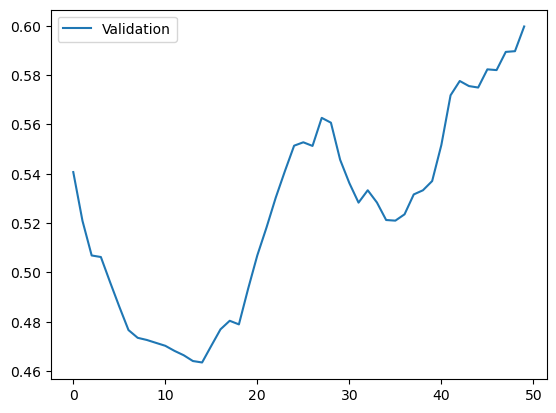

Minimum validation ECM: 0.464
Index of best parameter: 14


In [81]:
# Getting the average test scores
rlr_b_test_scores = abs(rlr_b_grid.cv_results_['mean_test_score'])

# Plotting the test scores
plt.plot(rlr_b_test_scores, label='Validation')
plt.legend(loc='best')
plt.show()

# Printing the minimum validation ECM and the index of the best parameter
print('Minimum validation ECM:', round(min(rlr_b_test_scores),3))
print('Index of best parameter:', np.argmin(rlr_b_test_scores))

In [82]:
# Best parameter
rlr_b_best_param = rlr_b_grid.best_params_
print(rlr_b_best_param)

# Get the best model from the grid search
rlr_b_best_model = rlr_b_grid.best_estimator_

# Predict on the test data using the best parameters
rlr_y_b_pred = rlr_b_best_model.predict(X_b_test)
rlr_y_b_pred_proba = rlr_b_best_model.predict_proba(X_b_test)[:, 1]

{'lr__C': 1.9306977288832496e-05, 'lr__penalty': 'l2'}


In [83]:
# Calculate the custom scorer for different threshold values
thresholds = np.arange(0.0, 1.0, 0.00001)
scores = []
for threshold in thresholds:
    preds = (rlr_y_b_pred_proba >= threshold).astype(int)
    score = ECM(y_b_test.values.ravel(), preds)
    scores.append(score)

# Find the threshold that gives the best score
rlr_b_best_threshold = thresholds[np.argmin(scores)]
print("Best threshold:", rlr_b_best_threshold)

# Adjusting predictions based on optimal threshold
rlr_y_b_pred = rlr_y_b_pred_proba >= rlr_b_best_threshold

# Calculating the various performance metrics
rlr_b_roc_auc = roc_auc_score(y_b_test.values.ravel(), rlr_y_b_pred_proba)
rlr_b_tn, rlr_b_fp, rlr_b_fn, rlr_b_tp = confusion_matrix(y_b_test.values.ravel(), rlr_y_b_pred).ravel()
rlr_b_sensitivity = rlr_b_tp / (rlr_b_tp + rlr_b_fn)
rlr_b_specificity = rlr_b_tn / (rlr_b_tn + rlr_b_fp)
rlr_b_accuracy = accuracy_score(y_b_test.values.ravel(),rlr_y_b_pred)
rlr_b_f1 = f1_score(y_b_test.values.ravel(), rlr_y_b_pred)
rlr_b_ecm_score = ECM(y_b_test.values.ravel(),rlr_y_b_pred)

# Printing the performance metrics
print("ROC AUC Score: {:.3f}".format(rlr_b_roc_auc))
print("Accuracy Score: {:.3f}".format(rlr_b_accuracy))
print("Specificity Score: {:.3f}".format(rlr_b_specificity))
print("Sensitivity Score: {:.3f}".format(rlr_b_sensitivity))
print("F1 Score: {:.3f}".format(rlr_b_f1))
print("ECM: {:.3f}".format(rlr_b_ecm_score))

Best threshold: 0.5090800000000001
ROC AUC Score: 0.704
Accuracy Score: 0.862
Specificity Score: 0.868
Sensitivity Score: 0.480
F1 Score: 0.106
ECM: 0.464


In [246]:
# Start timer
start_time = time.time()

# Fit model on data
rlr_b_best_model.fit(X_b_train, y_b_train)

# End timer
end_time = time.time()

# Calculate time taken to fit model
time_taken = end_time - start_time

# Print time taken
print(f"Time taken to fit baseline RLR: {time_taken:.5f} seconds")

Time taken to fit baseline RLR: 0.09005 seconds


## MD&A Performance

In [84]:
# Preprocessor
rlr_m_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols_m),
        ('non_num', 'passthrough', non_num_cols_m)
    ])

# Pipeline steps
rlr_m_steps = [
    ("prep", rlr_m_preprocessor),
    ("over", SMOTE(random_state=42)), 
    ("lr", LogisticRegression(random_state=21, solver='lbfgs', max_iter=1000000)), 
]

# Pipeline
rlr_m_pipeline = Pipeline(rlr_m_steps)

# Set up the grid search parameters
rlr_m_parameters = {'lr__C': np.logspace(-7,1,50),
                 'lr__penalty': ['l2']}

# Setting up the GridSearch with CV
rlr_m_grid = GridSearchCV(rlr_m_pipeline, rlr_m_parameters, cv=kf, verbose = 10, scoring=rlr_scoring)

# Fit the grid search object to the training data
rlr_m_grid.fit(X_m_train, y_m_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5; 1/50] START lr__C=1e-07, lr__penalty=l2................................
[CV 1/5; 1/50] END lr__C=1e-07, lr__penalty=l2;, score=-0.564 total time=   0.5s
[CV 2/5; 1/50] START lr__C=1e-07, lr__penalty=l2................................
[CV 2/5; 1/50] END lr__C=1e-07, lr__penalty=l2;, score=-0.458 total time=   0.5s
[CV 3/5; 1/50] START lr__C=1e-07, lr__penalty=l2................................
[CV 3/5; 1/50] END lr__C=1e-07, lr__penalty=l2;, score=-0.458 total time=   0.6s
[CV 4/5; 1/50] START lr__C=1e-07, lr__penalty=l2................................
[CV 4/5; 1/50] END lr__C=1e-07, lr__penalty=l2;, score=-0.577 total time=   0.5s
[CV 5/5; 1/50] START lr__C=1e-07, lr__penalty=l2................................
[CV 5/5; 1/50] END lr__C=1e-07, lr__penalty=l2;, score=-0.595 total time=   0.6s
[CV 1/5; 2/50] START lr__C=1.4563484775012443e-07, lr__penalty=l2...............
[CV 1/5; 2/50] END lr__C=1.4563484775012443e-07

[CV 2/5; 10/50] END lr__C=2.94705170255181e-06, lr__penalty=l2;, score=-0.419 total time=   0.6s
[CV 3/5; 10/50] START lr__C=2.94705170255181e-06, lr__penalty=l2................
[CV 3/5; 10/50] END lr__C=2.94705170255181e-06, lr__penalty=l2;, score=-0.434 total time=   0.6s
[CV 4/5; 10/50] START lr__C=2.94705170255181e-06, lr__penalty=l2................
[CV 4/5; 10/50] END lr__C=2.94705170255181e-06, lr__penalty=l2;, score=-0.461 total time=   0.6s
[CV 5/5; 10/50] START lr__C=2.94705170255181e-06, lr__penalty=l2................
[CV 5/5; 10/50] END lr__C=2.94705170255181e-06, lr__penalty=l2;, score=-0.550 total time=   0.7s
[CV 1/5; 11/50] START lr__C=4.291934260128778e-06, lr__penalty=l2...............
[CV 1/5; 11/50] END lr__C=4.291934260128778e-06, lr__penalty=l2;, score=-0.519 total time=   0.6s
[CV 2/5; 11/50] START lr__C=4.291934260128778e-06, lr__penalty=l2...............
[CV 2/5; 11/50] END lr__C=4.291934260128778e-06, lr__penalty=l2;, score=-0.419 total time=   0.6s
[CV 3/5; 11

[CV 3/5; 19/50] END lr__C=8.68511373751352e-05, lr__penalty=l2;, score=-0.409 total time=   0.5s
[CV 4/5; 19/50] START lr__C=8.68511373751352e-05, lr__penalty=l2................
[CV 4/5; 19/50] END lr__C=8.68511373751352e-05, lr__penalty=l2;, score=-0.454 total time=   0.6s
[CV 5/5; 19/50] START lr__C=8.68511373751352e-05, lr__penalty=l2................
[CV 5/5; 19/50] END lr__C=8.68511373751352e-05, lr__penalty=l2;, score=-0.578 total time=   0.6s
[CV 1/5; 20/50] START lr__C=0.00012648552168552957, lr__penalty=l2..............
[CV 1/5; 20/50] END lr__C=0.00012648552168552957, lr__penalty=l2;, score=-0.556 total time=   0.5s
[CV 2/5; 20/50] START lr__C=0.00012648552168552957, lr__penalty=l2..............
[CV 2/5; 20/50] END lr__C=0.00012648552168552957, lr__penalty=l2;, score=-0.400 total time=   0.5s
[CV 3/5; 20/50] START lr__C=0.00012648552168552957, lr__penalty=l2..............
[CV 3/5; 20/50] END lr__C=0.00012648552168552957, lr__penalty=l2;, score=-0.411 total time=   0.5s
[CV 4/5

[CV 4/5; 28/50] END lr__C=0.0025595479226995332, lr__penalty=l2;, score=-0.540 total time=   0.6s
[CV 5/5; 28/50] START lr__C=0.0025595479226995332, lr__penalty=l2...............
[CV 5/5; 28/50] END lr__C=0.0025595479226995332, lr__penalty=l2;, score=-0.706 total time=   0.6s
[CV 1/5; 29/50] START lr__C=0.003727593720314938, lr__penalty=l2................
[CV 1/5; 29/50] END lr__C=0.003727593720314938, lr__penalty=l2;, score=-0.560 total time=   0.6s
[CV 2/5; 29/50] START lr__C=0.003727593720314938, lr__penalty=l2................
[CV 2/5; 29/50] END lr__C=0.003727593720314938, lr__penalty=l2;, score=-0.444 total time=   0.6s
[CV 3/5; 29/50] START lr__C=0.003727593720314938, lr__penalty=l2................
[CV 3/5; 29/50] END lr__C=0.003727593720314938, lr__penalty=l2;, score=-0.457 total time=   0.6s
[CV 4/5; 29/50] START lr__C=0.003727593720314938, lr__penalty=l2................
[CV 4/5; 29/50] END lr__C=0.003727593720314938, lr__penalty=l2;, score=-0.584 total time=   0.7s
[CV 5/5; 29

[CV 1/5; 38/50] END lr__C=0.10985411419875572, lr__penalty=l2;, score=-0.489 total time=   0.7s
[CV 2/5; 38/50] START lr__C=0.10985411419875572, lr__penalty=l2.................
[CV 2/5; 38/50] END lr__C=0.10985411419875572, lr__penalty=l2;, score=-0.430 total time=   0.7s
[CV 3/5; 38/50] START lr__C=0.10985411419875572, lr__penalty=l2.................
[CV 3/5; 38/50] END lr__C=0.10985411419875572, lr__penalty=l2;, score=-0.463 total time=   0.7s
[CV 4/5; 38/50] START lr__C=0.10985411419875572, lr__penalty=l2.................
[CV 4/5; 38/50] END lr__C=0.10985411419875572, lr__penalty=l2;, score=-0.585 total time=   0.7s
[CV 5/5; 38/50] START lr__C=0.10985411419875572, lr__penalty=l2.................
[CV 5/5; 38/50] END lr__C=0.10985411419875572, lr__penalty=l2;, score=-0.645 total time=   0.7s
[CV 1/5; 39/50] START lr__C=0.15998587196060574, lr__penalty=l2.................
[CV 1/5; 39/50] END lr__C=0.15998587196060574, lr__penalty=l2;, score=-0.521 total time=   0.7s
[CV 2/5; 39/50] STA

[CV 3/5; 47/50] END lr__C=3.2374575428176398, lr__penalty=l2;, score=-0.580 total time=   1.2s
[CV 4/5; 47/50] START lr__C=3.2374575428176398, lr__penalty=l2..................
[CV 4/5; 47/50] END lr__C=3.2374575428176398, lr__penalty=l2;, score=-0.580 total time=   1.1s
[CV 5/5; 47/50] START lr__C=3.2374575428176398, lr__penalty=l2..................
[CV 5/5; 47/50] END lr__C=3.2374575428176398, lr__penalty=l2;, score=-0.647 total time=   1.2s
[CV 1/5; 48/50] START lr__C=4.714866363457389, lr__penalty=l2...................
[CV 1/5; 48/50] END lr__C=4.714866363457389, lr__penalty=l2;, score=-0.553 total time=   1.3s
[CV 2/5; 48/50] START lr__C=4.714866363457389, lr__penalty=l2...................
[CV 2/5; 48/50] END lr__C=4.714866363457389, lr__penalty=l2;, score=-0.517 total time=   3.4s
[CV 3/5; 48/50] START lr__C=4.714866363457389, lr__penalty=l2...................
[CV 3/5; 48/50] END lr__C=4.714866363457389, lr__penalty=l2;, score=-0.577 total time=   2.7s
[CV 4/5; 48/50] START lr__C=

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=25, shuffle=True),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['ARtS',
                                                                          'ARtTA',
                                                                          'AFDA',
                                                                          'AFDAtAR',
                                                                          'AFDAtNS',
                                                                          'Zscore',
                                                                          'Big4',
                                                                          'cItS',
                                        

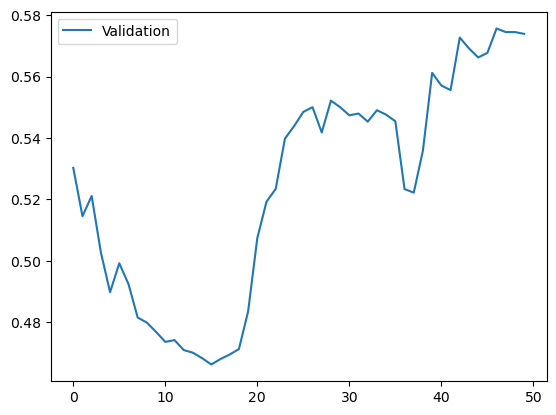

Minimum validation ECM: 0.466
Index of best parameter: 15


In [85]:
# Getting the average test scores
rlr_m_test_scores = abs(rlr_m_grid.cv_results_['mean_test_score'])

# Plotting the test scores
plt.plot(rlr_m_test_scores, label='Validation')
plt.legend(loc='best')
plt.show()

# Printing the minimum validation ECM and the index of the best parameter
print('Minimum validation ECM:', round(min(rlr_m_test_scores),3))
print('Index of best parameter:', np.argmin(rlr_m_test_scores))

In [86]:
# Best parameter
rlr_m_best_param = rlr_m_grid.best_params_
print(rlr_m_best_param)

# Get the best model from the grid search
rlr_m_best_model = rlr_m_grid.best_estimator_

# Predict on the test data using the best parameters
rlr_y_m_pred = rlr_m_best_model.predict(X_m_test)
rlr_y_m_pred_proba = rlr_m_best_model.predict_proba(X_m_test)[:, 1]

{'lr__C': 2.8117686979742253e-05, 'lr__penalty': 'l2'}


In [87]:
# Calculate the custom scorer for different threshold values
thresholds = np.arange(0.0, 1.0, 0.00001)
scores = []
for threshold in thresholds:
    preds = (rlr_y_m_pred_proba >= threshold).astype(int)
    score = ECM(y_m_test.values.ravel(), preds)
    scores.append(score)

# Find the threshold that gives the best score
rlr_m_best_threshold = thresholds[np.argmin(scores)]
print("Best threshold:", rlr_m_best_threshold)

# Adjusting predictions based on optimal threshold
rlr_y_m_pred = rlr_y_m_pred_proba >= rlr_m_best_threshold

# Calculating the various performance metrics
rlr_m_roc_auc = roc_auc_score(y_m_test.values.ravel(), rlr_y_m_pred_proba)
rlr_m_tn, rlr_m_fp, rlr_m_fn, rlr_m_tp = confusion_matrix(y_m_test.values.ravel(), rlr_y_m_pred).ravel()
rlr_m_sensitivity = rlr_m_tp / (rlr_m_tp + rlr_m_fn)
rlr_m_specificity = rlr_m_tn / (rlr_m_tn + rlr_m_fp)
rlr_m_accuracy = accuracy_score(y_m_test.values.ravel(),rlr_y_m_pred)
rlr_m_f1 = f1_score(y_m_test.values.ravel(), rlr_y_m_pred)
rlr_m_ecm_score = ECM(y_m_test.values.ravel(),rlr_y_m_pred)

# Printing the performance metrics
print("ROC AUC Score: {:.3f}".format(rlr_m_roc_auc))
print("Accuracy Score: {:.3f}".format(rlr_m_accuracy))
print("Specificity Score: {:.3f}".format(rlr_m_specificity))
print("Sensitivity Score: {:.3f}".format(rlr_m_sensitivity))
print("F1 Score: {:.3f}".format(rlr_m_f1))
print("ECM: {:.3f}".format(rlr_m_ecm_score))

Best threshold: 0.51337
ROC AUC Score: 0.706
Accuracy Score: 0.862
Specificity Score: 0.868
Sensitivity Score: 0.480
F1 Score: 0.106
ECM: 0.464


In [242]:
# Start timer
start_time = time.time()

# Fit model on data
rlr_m_best_model.fit(X_m_train, y_m_train)

# End timer
end_time = time.time()

# Calculate time taken to fit model
time_taken = end_time - start_time

# Print time taken
print(f"Time taken to fit MD&A RLR: {time_taken:.5f} seconds")

Time taken to fit MD&A RLR: 0.08983 seconds


## ECT Performance

In [88]:
# Preprocessor
rlr_e_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols_e),
        ('non_num', 'passthrough', non_num_cols_e)
    ])

# Pipeline steps
rlr_e_steps = [
    ("prep", rlr_e_preprocessor),
    ("over", SMOTE(random_state=42)), 
    ("lr", LogisticRegression(random_state=21, solver='lbfgs', max_iter=1000000)), 
]

# Pipeline
rlr_e_pipeline = Pipeline(rlr_e_steps)

# Set up the grid search parameters
rlr_e_parameters = {'lr__C': np.logspace(-7,1,50),
                 'lr__penalty': ['l2']}

# Setting up the GridSearch with CV
rlr_e_grid = GridSearchCV(rlr_e_pipeline, rlr_e_parameters, cv=kf, verbose = 10, scoring=rlr_scoring)

# Fit the grid search object to the training data
rlr_e_grid.fit(X_e_train, y_e_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5; 1/50] START lr__C=1e-07, lr__penalty=l2................................
[CV 1/5; 1/50] END lr__C=1e-07, lr__penalty=l2;, score=-0.584 total time=   0.6s
[CV 2/5; 1/50] START lr__C=1e-07, lr__penalty=l2................................
[CV 2/5; 1/50] END lr__C=1e-07, lr__penalty=l2;, score=-0.553 total time=   0.6s
[CV 3/5; 1/50] START lr__C=1e-07, lr__penalty=l2................................
[CV 3/5; 1/50] END lr__C=1e-07, lr__penalty=l2;, score=-0.524 total time=   0.6s
[CV 4/5; 1/50] START lr__C=1e-07, lr__penalty=l2................................
[CV 4/5; 1/50] END lr__C=1e-07, lr__penalty=l2;, score=-0.510 total time=   0.6s
[CV 5/5; 1/50] START lr__C=1e-07, lr__penalty=l2................................
[CV 5/5; 1/50] END lr__C=1e-07, lr__penalty=l2;, score=-0.615 total time=   0.6s
[CV 1/5; 2/50] START lr__C=1.4563484775012443e-07, lr__penalty=l2...............
[CV 1/5; 2/50] END lr__C=1.4563484775012443e-07

[CV 2/5; 10/50] END lr__C=2.94705170255181e-06, lr__penalty=l2;, score=-0.511 total time=   0.6s
[CV 3/5; 10/50] START lr__C=2.94705170255181e-06, lr__penalty=l2................
[CV 3/5; 10/50] END lr__C=2.94705170255181e-06, lr__penalty=l2;, score=-0.475 total time=   0.6s
[CV 4/5; 10/50] START lr__C=2.94705170255181e-06, lr__penalty=l2................
[CV 4/5; 10/50] END lr__C=2.94705170255181e-06, lr__penalty=l2;, score=-0.449 total time=   0.5s
[CV 5/5; 10/50] START lr__C=2.94705170255181e-06, lr__penalty=l2................
[CV 5/5; 10/50] END lr__C=2.94705170255181e-06, lr__penalty=l2;, score=-0.537 total time=   0.5s
[CV 1/5; 11/50] START lr__C=4.291934260128778e-06, lr__penalty=l2...............
[CV 1/5; 11/50] END lr__C=4.291934260128778e-06, lr__penalty=l2;, score=-0.521 total time=   0.6s
[CV 2/5; 11/50] START lr__C=4.291934260128778e-06, lr__penalty=l2...............
[CV 2/5; 11/50] END lr__C=4.291934260128778e-06, lr__penalty=l2;, score=-0.511 total time=   0.6s
[CV 3/5; 11

[CV 3/5; 19/50] END lr__C=8.68511373751352e-05, lr__penalty=l2;, score=-0.411 total time=   0.6s
[CV 4/5; 19/50] START lr__C=8.68511373751352e-05, lr__penalty=l2................
[CV 4/5; 19/50] END lr__C=8.68511373751352e-05, lr__penalty=l2;, score=-0.499 total time=   0.6s
[CV 5/5; 19/50] START lr__C=8.68511373751352e-05, lr__penalty=l2................
[CV 5/5; 19/50] END lr__C=8.68511373751352e-05, lr__penalty=l2;, score=-0.566 total time=   0.6s
[CV 1/5; 20/50] START lr__C=0.00012648552168552957, lr__penalty=l2..............
[CV 1/5; 20/50] END lr__C=0.00012648552168552957, lr__penalty=l2;, score=-0.510 total time=   0.6s
[CV 2/5; 20/50] START lr__C=0.00012648552168552957, lr__penalty=l2..............
[CV 2/5; 20/50] END lr__C=0.00012648552168552957, lr__penalty=l2;, score=-0.469 total time=   0.5s
[CV 3/5; 20/50] START lr__C=0.00012648552168552957, lr__penalty=l2..............
[CV 3/5; 20/50] END lr__C=0.00012648552168552957, lr__penalty=l2;, score=-0.400 total time=   0.6s
[CV 4/5

[CV 4/5; 28/50] END lr__C=0.0025595479226995332, lr__penalty=l2;, score=-0.607 total time=   0.7s
[CV 5/5; 28/50] START lr__C=0.0025595479226995332, lr__penalty=l2...............
[CV 5/5; 28/50] END lr__C=0.0025595479226995332, lr__penalty=l2;, score=-0.678 total time=   0.6s
[CV 1/5; 29/50] START lr__C=0.003727593720314938, lr__penalty=l2................
[CV 1/5; 29/50] END lr__C=0.003727593720314938, lr__penalty=l2;, score=-0.591 total time=   0.7s
[CV 2/5; 29/50] START lr__C=0.003727593720314938, lr__penalty=l2................
[CV 2/5; 29/50] END lr__C=0.003727593720314938, lr__penalty=l2;, score=-0.436 total time=   0.7s
[CV 3/5; 29/50] START lr__C=0.003727593720314938, lr__penalty=l2................
[CV 3/5; 29/50] END lr__C=0.003727593720314938, lr__penalty=l2;, score=-0.457 total time=   0.6s
[CV 4/5; 29/50] START lr__C=0.003727593720314938, lr__penalty=l2................
[CV 4/5; 29/50] END lr__C=0.003727593720314938, lr__penalty=l2;, score=-0.594 total time=   0.7s
[CV 5/5; 29

[CV 1/5; 38/50] END lr__C=0.10985411419875572, lr__penalty=l2;, score=-0.639 total time=   0.9s
[CV 2/5; 38/50] START lr__C=0.10985411419875572, lr__penalty=l2.................
[CV 2/5; 38/50] END lr__C=0.10985411419875572, lr__penalty=l2;, score=-0.539 total time=   0.9s
[CV 3/5; 38/50] START lr__C=0.10985411419875572, lr__penalty=l2.................
[CV 3/5; 38/50] END lr__C=0.10985411419875572, lr__penalty=l2;, score=-0.659 total time=   0.9s
[CV 4/5; 38/50] START lr__C=0.10985411419875572, lr__penalty=l2.................
[CV 4/5; 38/50] END lr__C=0.10985411419875572, lr__penalty=l2;, score=-0.568 total time=   0.8s
[CV 5/5; 38/50] START lr__C=0.10985411419875572, lr__penalty=l2.................
[CV 5/5; 38/50] END lr__C=0.10985411419875572, lr__penalty=l2;, score=-0.669 total time=   0.9s
[CV 1/5; 39/50] START lr__C=0.15998587196060574, lr__penalty=l2.................
[CV 1/5; 39/50] END lr__C=0.15998587196060574, lr__penalty=l2;, score=-0.626 total time=   0.8s
[CV 2/5; 39/50] STA

[CV 3/5; 47/50] END lr__C=3.2374575428176398, lr__penalty=l2;, score=-0.643 total time=   1.3s
[CV 4/5; 47/50] START lr__C=3.2374575428176398, lr__penalty=l2..................
[CV 4/5; 47/50] END lr__C=3.2374575428176398, lr__penalty=l2;, score=-0.589 total time=   1.9s
[CV 5/5; 47/50] START lr__C=3.2374575428176398, lr__penalty=l2..................
[CV 5/5; 47/50] END lr__C=3.2374575428176398, lr__penalty=l2;, score=-0.634 total time=   4.4s
[CV 1/5; 48/50] START lr__C=4.714866363457389, lr__penalty=l2...................
[CV 1/5; 48/50] END lr__C=4.714866363457389, lr__penalty=l2;, score=-0.592 total time=   1.4s
[CV 2/5; 48/50] START lr__C=4.714866363457389, lr__penalty=l2...................
[CV 2/5; 48/50] END lr__C=4.714866363457389, lr__penalty=l2;, score=-0.567 total time=   1.5s
[CV 3/5; 48/50] START lr__C=4.714866363457389, lr__penalty=l2...................
[CV 3/5; 48/50] END lr__C=4.714866363457389, lr__penalty=l2;, score=-0.643 total time=   1.4s
[CV 4/5; 48/50] START lr__C=

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=25, shuffle=True),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['ARtS',
                                                                          'ARtTA',
                                                                          'AFDA',
                                                                          'AFDAtAR',
                                                                          'AFDAtNS',
                                                                          'Zscore',
                                                                          'Big4',
                                                                          'cItS',
                                        

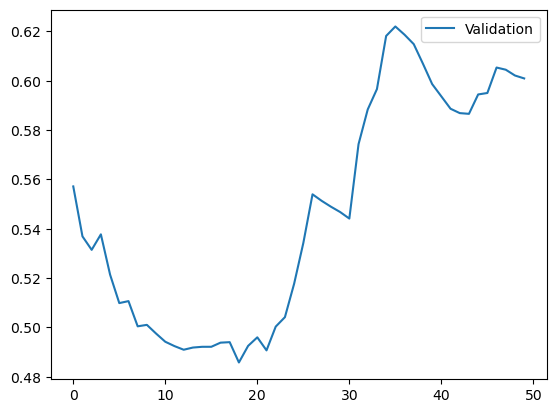

Minimum validation ECM: 0.486
Index of best parameter: 18


In [89]:
# Getting the average test scores
rlr_e_test_scores = abs(rlr_e_grid.cv_results_['mean_test_score'])

# Plotting the test scores
plt.plot(rlr_e_test_scores, label='Validation')
plt.legend(loc='best')
plt.show()

# Printing the minimum validation ECM and the index of the best parameter
print('Minimum validation ECM:', round(min(rlr_e_test_scores),3))
print('Index of best parameter:', np.argmin(rlr_e_test_scores))

In [90]:
# Best parameter
rlr_e_best_param = rlr_e_grid.best_params_
print(rlr_e_best_param)

# Get the best model from the grid search
rlr_e_best_model = rlr_e_grid.best_estimator_

# Predict on the test data using the best parameters
rlr_y_e_pred = rlr_e_best_model.predict(X_e_test)
rlr_y_e_pred_proba = rlr_e_best_model.predict_proba(X_e_test)[:, 1]

{'lr__C': 8.68511373751352e-05, 'lr__penalty': 'l2'}


In [91]:
# Calculate the custom scorer for different threshold values
thresholds = np.arange(0.0, 1.0, 0.00001)
scores = []
for threshold in thresholds:
    preds = (rlr_y_e_pred_proba >= threshold).astype(int)
    score = ECM(y_e_test.values.ravel(), preds)
    scores.append(score)

# Find the threshold that gives the best score
rlr_e_best_threshold = thresholds[np.argmin(scores)]
print("Best threshold:", rlr_e_best_threshold)

# Adjusting predictions based on optimal threshold
rlr_y_e_pred = rlr_y_e_pred_proba >= rlr_e_best_threshold

# Calculating the various performance metrics
rlr_e_roc_auc = roc_auc_score(y_e_test.values.ravel(), rlr_y_e_pred_proba)
rlr_e_tn, rlr_e_fp, rlr_e_fn, rlr_e_tp = confusion_matrix(y_e_test.values.ravel(), rlr_y_e_pred).ravel()
rlr_e_sensitivity = rlr_e_tp / (rlr_e_tp + rlr_e_fn)
rlr_e_specificity = rlr_e_tn / (rlr_e_tn + rlr_e_fp)
rlr_e_accuracy = accuracy_score(y_e_test.values.ravel(),rlr_y_e_pred)
rlr_e_f1 = f1_score(y_e_test.values.ravel(), rlr_y_e_pred)
rlr_e_ecm_score = ECM(y_e_test.values.ravel(),rlr_y_e_pred)

# Printing the performance metrics
print("ROC AUC Score: {:.3f}".format(rlr_e_roc_auc))
print("Accuracy Score: {:.3f}".format(rlr_e_accuracy))
print("Specificity Score: {:.3f}".format(rlr_e_specificity))
print("Sensitivity Score: {:.3f}".format(rlr_e_sensitivity))
print("F1 Score: {:.3f}".format(rlr_e_f1))
print("ECM: {:.3f}".format(rlr_e_ecm_score))

Best threshold: 0.5373100000000001
ROC AUC Score: 0.699
Accuracy Score: 0.897
Specificity Score: 0.905
Sensitivity Score: 0.440
F1 Score: 0.127
ECM: 0.455


In [241]:
# Start timer
start_time = time.time()

# Fit model on data
rlr_e_best_model.fit(X_e_train, y_e_train)

# End timer
end_time = time.time()

# Calculate time taken to fit model
time_taken = end_time - start_time

# Print time taken
print(f"Time taken to fit ECT RLR: {time_taken:.5f} seconds")

Time taken to fit ECT RLR: 0.12992 seconds


## Full Model Performance

In [92]:
# Preprocessor
rlr_f_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols_f),
        ('non_num', 'passthrough', non_num_cols_f)
    ])

# Pipeline steps
rlr_f_steps = [
    ("prep", rlr_f_preprocessor),
    ("over", SMOTE(random_state=42)), 
    ("lr", LogisticRegression(random_state=21, solver='lbfgs', max_iter=1000000)), 
]

# Pipeline
rlr_f_pipeline = Pipeline(rlr_f_steps)

# Set up the grid search parameters
rlr_f_parameters = {'lr__C': np.logspace(-7,1,50),
                 'lr__penalty': ['l2']}

# Setting up the GridSearch with CV
rlr_f_grid = GridSearchCV(rlr_f_pipeline, rlr_f_parameters, cv=kf, verbose = 10, scoring=rlr_scoring)

# Fit the grid search object to the training data
rlr_f_grid.fit(X_f_train, y_f_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5; 1/50] START lr__C=1e-07, lr__penalty=l2................................
[CV 1/5; 1/50] END lr__C=1e-07, lr__penalty=l2;, score=-0.581 total time=   1.5s
[CV 2/5; 1/50] START lr__C=1e-07, lr__penalty=l2................................
[CV 2/5; 1/50] END lr__C=1e-07, lr__penalty=l2;, score=-0.568 total time=   0.9s
[CV 3/5; 1/50] START lr__C=1e-07, lr__penalty=l2................................
[CV 3/5; 1/50] END lr__C=1e-07, lr__penalty=l2;, score=-0.529 total time=   0.8s
[CV 4/5; 1/50] START lr__C=1e-07, lr__penalty=l2................................
[CV 4/5; 1/50] END lr__C=1e-07, lr__penalty=l2;, score=-0.504 total time=   0.7s
[CV 5/5; 1/50] START lr__C=1e-07, lr__penalty=l2................................
[CV 5/5; 1/50] END lr__C=1e-07, lr__penalty=l2;, score=-0.619 total time=   0.6s
[CV 1/5; 2/50] START lr__C=1.4563484775012443e-07, lr__penalty=l2...............
[CV 1/5; 2/50] END lr__C=1.4563484775012443e-07

[CV 2/5; 10/50] END lr__C=2.94705170255181e-06, lr__penalty=l2;, score=-0.519 total time=   0.6s
[CV 3/5; 10/50] START lr__C=2.94705170255181e-06, lr__penalty=l2................
[CV 3/5; 10/50] END lr__C=2.94705170255181e-06, lr__penalty=l2;, score=-0.514 total time=   0.6s
[CV 4/5; 10/50] START lr__C=2.94705170255181e-06, lr__penalty=l2................
[CV 4/5; 10/50] END lr__C=2.94705170255181e-06, lr__penalty=l2;, score=-0.471 total time=   0.5s
[CV 5/5; 10/50] START lr__C=2.94705170255181e-06, lr__penalty=l2................
[CV 5/5; 10/50] END lr__C=2.94705170255181e-06, lr__penalty=l2;, score=-0.547 total time=   0.5s
[CV 1/5; 11/50] START lr__C=4.291934260128778e-06, lr__penalty=l2...............
[CV 1/5; 11/50] END lr__C=4.291934260128778e-06, lr__penalty=l2;, score=-0.515 total time=   0.5s
[CV 2/5; 11/50] START lr__C=4.291934260128778e-06, lr__penalty=l2...............
[CV 2/5; 11/50] END lr__C=4.291934260128778e-06, lr__penalty=l2;, score=-0.518 total time=   0.6s
[CV 3/5; 11

[CV 3/5; 19/50] END lr__C=8.68511373751352e-05, lr__penalty=l2;, score=-0.473 total time=   0.6s
[CV 4/5; 19/50] START lr__C=8.68511373751352e-05, lr__penalty=l2................
[CV 4/5; 19/50] END lr__C=8.68511373751352e-05, lr__penalty=l2;, score=-0.496 total time=   0.6s
[CV 5/5; 19/50] START lr__C=8.68511373751352e-05, lr__penalty=l2................
[CV 5/5; 19/50] END lr__C=8.68511373751352e-05, lr__penalty=l2;, score=-0.594 total time=   0.6s
[CV 1/5; 20/50] START lr__C=0.00012648552168552957, lr__penalty=l2..............
[CV 1/5; 20/50] END lr__C=0.00012648552168552957, lr__penalty=l2;, score=-0.512 total time=   0.6s
[CV 2/5; 20/50] START lr__C=0.00012648552168552957, lr__penalty=l2..............
[CV 2/5; 20/50] END lr__C=0.00012648552168552957, lr__penalty=l2;, score=-0.474 total time=   0.6s
[CV 3/5; 20/50] START lr__C=0.00012648552168552957, lr__penalty=l2..............
[CV 3/5; 20/50] END lr__C=0.00012648552168552957, lr__penalty=l2;, score=-0.460 total time=   0.6s
[CV 4/5

[CV 4/5; 28/50] END lr__C=0.0025595479226995332, lr__penalty=l2;, score=-0.637 total time=   0.6s
[CV 5/5; 28/50] START lr__C=0.0025595479226995332, lr__penalty=l2...............
[CV 5/5; 28/50] END lr__C=0.0025595479226995332, lr__penalty=l2;, score=-0.686 total time=   0.6s
[CV 1/5; 29/50] START lr__C=0.003727593720314938, lr__penalty=l2................
[CV 1/5; 29/50] END lr__C=0.003727593720314938, lr__penalty=l2;, score=-0.571 total time=   0.6s
[CV 2/5; 29/50] START lr__C=0.003727593720314938, lr__penalty=l2................
[CV 2/5; 29/50] END lr__C=0.003727593720314938, lr__penalty=l2;, score=-0.438 total time=   0.7s
[CV 3/5; 29/50] START lr__C=0.003727593720314938, lr__penalty=l2................
[CV 3/5; 29/50] END lr__C=0.003727593720314938, lr__penalty=l2;, score=-0.456 total time=   0.6s
[CV 4/5; 29/50] START lr__C=0.003727593720314938, lr__penalty=l2................
[CV 4/5; 29/50] END lr__C=0.003727593720314938, lr__penalty=l2;, score=-0.619 total time=   0.6s
[CV 5/5; 29

[CV 1/5; 38/50] END lr__C=0.10985411419875572, lr__penalty=l2;, score=-0.704 total time=   0.8s
[CV 2/5; 38/50] START lr__C=0.10985411419875572, lr__penalty=l2.................
[CV 2/5; 38/50] END lr__C=0.10985411419875572, lr__penalty=l2;, score=-0.590 total time=   0.8s
[CV 3/5; 38/50] START lr__C=0.10985411419875572, lr__penalty=l2.................
[CV 3/5; 38/50] END lr__C=0.10985411419875572, lr__penalty=l2;, score=-0.701 total time=   0.8s
[CV 4/5; 38/50] START lr__C=0.10985411419875572, lr__penalty=l2.................
[CV 4/5; 38/50] END lr__C=0.10985411419875572, lr__penalty=l2;, score=-0.597 total time=   0.8s
[CV 5/5; 38/50] START lr__C=0.10985411419875572, lr__penalty=l2.................
[CV 5/5; 38/50] END lr__C=0.10985411419875572, lr__penalty=l2;, score=-0.615 total time=   0.8s
[CV 1/5; 39/50] START lr__C=0.15998587196060574, lr__penalty=l2.................
[CV 1/5; 39/50] END lr__C=0.15998587196060574, lr__penalty=l2;, score=-0.692 total time=   0.9s
[CV 2/5; 39/50] STA

[CV 3/5; 47/50] END lr__C=3.2374575428176398, lr__penalty=l2;, score=-0.680 total time=   1.4s
[CV 4/5; 47/50] START lr__C=3.2374575428176398, lr__penalty=l2..................
[CV 4/5; 47/50] END lr__C=3.2374575428176398, lr__penalty=l2;, score=-0.578 total time=   1.2s
[CV 5/5; 47/50] START lr__C=3.2374575428176398, lr__penalty=l2..................
[CV 5/5; 47/50] END lr__C=3.2374575428176398, lr__penalty=l2;, score=-0.635 total time=   1.5s
[CV 1/5; 48/50] START lr__C=4.714866363457389, lr__penalty=l2...................
[CV 1/5; 48/50] END lr__C=4.714866363457389, lr__penalty=l2;, score=-0.593 total time=   1.4s
[CV 2/5; 48/50] START lr__C=4.714866363457389, lr__penalty=l2...................
[CV 2/5; 48/50] END lr__C=4.714866363457389, lr__penalty=l2;, score=-0.508 total time=   5.0s
[CV 3/5; 48/50] START lr__C=4.714866363457389, lr__penalty=l2...................
[CV 3/5; 48/50] END lr__C=4.714866363457389, lr__penalty=l2;, score=-0.679 total time=   1.3s
[CV 4/5; 48/50] START lr__C=

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=25, shuffle=True),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['ARtS',
                                                                          'ARtTA',
                                                                          'AFDA',
                                                                          'AFDAtAR',
                                                                          'AFDAtNS',
                                                                          'Zscore',
                                                                          'Big4',
                                                                          'cItS',
                                        

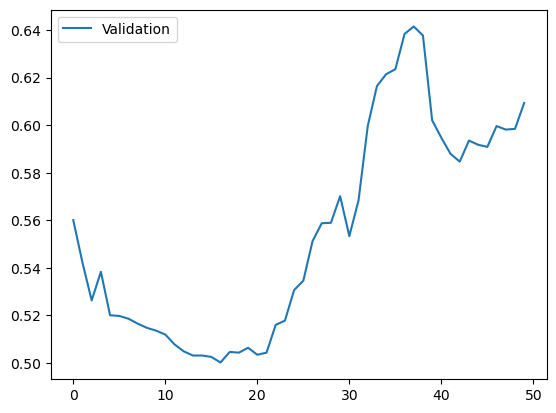

Minimum validation ECM: 0.5
Index of best parameter: 16


In [93]:
# Getting the average test scores
rlr_f_test_scores = abs(rlr_f_grid.cv_results_['mean_test_score'])

# Plotting the test scores
plt.plot(rlr_f_test_scores, label='Validation')
plt.legend(loc='best')
plt.show()

# Printing the minimum validation ECM and the index of the best parameter
print('Minimum validation ECM:', round(min(rlr_f_test_scores),3))
print('Index of best parameter:', np.argmin(rlr_f_test_scores))

In [94]:
# Best parameter
rlr_f_best_param = rlr_f_grid.best_params_
print(rlr_f_best_param)

# Get the best model from the grid search
rlr_f_best_model = rlr_f_grid.best_estimator_

# Predict on the test data using the best parameters
rlr_y_f_pred = rlr_f_best_model.predict(X_f_test)
rlr_y_f_pred_proba = rlr_f_best_model.predict_proba(X_f_test)[:, 1]

{'lr__C': 4.094915062380419e-05, 'lr__penalty': 'l2'}


In [95]:
# Calculate the custom scorer for different threshold values
thresholds = np.arange(0.0, 1.0, 0.00001)
scores = []
for threshold in thresholds:
    preds = (rlr_y_f_pred_proba >= threshold).astype(int)
    score = ECM(y_f_test.values.ravel(), preds)
    scores.append(score)

# Find the threshold that gives the best score
rlr_f_best_threshold = thresholds[np.argmin(scores)]
print("Best threshold:", rlr_f_best_threshold)

# Adjusting predictions based on optimal threshold
rlr_y_f_pred = rlr_y_f_pred_proba >= rlr_f_best_threshold

# Calculating the various performance metrics
rlr_f_roc_auc = roc_auc_score(y_f_test.values.ravel(), rlr_y_f_pred_proba)
rlr_f_tn, rlr_f_fp, rlr_f_fn, rlr_f_tp = confusion_matrix(y_f_test.values.ravel(), rlr_y_f_pred).ravel()
rlr_f_sensitivity = rlr_f_tp / (rlr_f_tp + rlr_f_fn)
rlr_f_specificity = rlr_f_tn / (rlr_f_tn + rlr_f_fp)
rlr_f_accuracy = accuracy_score(y_f_test.values.ravel(),rlr_y_f_pred)
rlr_f_f1 = f1_score(y_f_test.values.ravel(), rlr_y_f_pred)
rlr_f_ecm_score = ECM(y_f_test.values.ravel(),rlr_y_f_pred)

# Printing the performance metrics
print("ROC AUC Score: {:.3f}".format(rlr_f_roc_auc))
print("Accuracy Score: {:.3f}".format(rlr_f_accuracy))
print("Specificity Score: {:.3f}".format(rlr_f_specificity))
print("Sensitivity Score: {:.3f}".format(rlr_f_sensitivity))
print("F1 Score: {:.3f}".format(rlr_f_f1))
print("ECM: {:.3f}".format(rlr_f_ecm_score))

Best threshold: 0.5179400000000001
ROC AUC Score: 0.702
Accuracy Score: 0.862
Specificity Score: 0.869
Sensitivity Score: 0.480
F1 Score: 0.107
ECM: 0.464


In [239]:
# Start timer
start_time = time.time()

# Fit model on data
rlr_f_best_model.fit(X_f_train, y_f_train)

# End timer
end_time = time.time()

# Calculate time taken to fit model
time_taken = end_time - start_time

# Print time taken
print(f"Time taken to fit full RLR: {time_taken:.5f} seconds")

Time taken to fit full RLR: 0.12982 seconds


## SAPSO Performance

In [15]:
# Importing the SAPSO data
sapso = pd.read_csv('rlr_sapso_data.csv')

# Defining X and y
y_srlr = pd.Series(data=sapso['Target'])
X_srlr = sapso.drop(columns=['Target'])

# Splitting the data
X_srlr_train, X_srlr_test, y_srlr_train, y_srlr_test = train_test_split(X_srlr, y_srlr, test_size=0.3, stratify=y_srlr,random_state=42)

# Numerical columns - SAPSO
num_cols_s = list(X_srlr_train.select_dtypes(include=['float']).columns)
# Non numerical columns - SAPSO
non_num_cols_s = list(X_srlr_train.select_dtypes(exclude=['float']).columns)

In [16]:
# Preprocessor
rlr_s_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols_s),
        ('non_num', 'passthrough', non_num_cols_s)
    ])

# Pipeline steps
rlr_s_steps = [
    ("prep", rlr_s_preprocessor),
    ("over", SMOTE(random_state=42)), 
    ("lr", LogisticRegression(random_state=21, solver='lbfgs', max_iter=1000000)), 
]

# Pipeline
rlr_s_pipeline = Pipeline(rlr_s_steps)

# Set up the grid search parameters
rlr_s_parameters = {'lr__C': np.logspace(-7,1,50),
                 'lr__penalty': ['l2']}

# Setting up the GridSearch with CV
rlr_s_grid = GridSearchCV(rlr_s_pipeline, rlr_s_parameters, cv=kf, verbose = 10, scoring=rlr_scoring)

# Fit the grid search object to the training data
rlr_s_grid.fit(X_srlr_train, y_srlr_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5; 1/50] START lr__C=1e-07, lr__penalty=l2................................
[CV 1/5; 1/50] END lr__C=1e-07, lr__penalty=l2;, score=-0.553 total time=   1.1s
[CV 2/5; 1/50] START lr__C=1e-07, lr__penalty=l2................................
[CV 2/5; 1/50] END lr__C=1e-07, lr__penalty=l2;, score=-0.425 total time=   1.5s
[CV 3/5; 1/50] START lr__C=1e-07, lr__penalty=l2................................
[CV 3/5; 1/50] END lr__C=1e-07, lr__penalty=l2;, score=-0.533 total time=   1.4s
[CV 4/5; 1/50] START lr__C=1e-07, lr__penalty=l2................................
[CV 4/5; 1/50] END lr__C=1e-07, lr__penalty=l2;, score=-0.543 total time=   1.5s
[CV 5/5; 1/50] START lr__C=1e-07, lr__penalty=l2................................
[CV 5/5; 1/50] END lr__C=1e-07, lr__penalty=l2;, score=-0.614 total time=   1.5s
[CV 1/5; 2/50] START lr__C=1.4563484775012443e-07, lr__penalty=l2...............
[CV 1/5; 2/50] END lr__C=1.4563484775012443e-07

[CV 2/5; 10/50] END lr__C=2.94705170255181e-06, lr__penalty=l2;, score=-0.405 total time=   1.4s
[CV 3/5; 10/50] START lr__C=2.94705170255181e-06, lr__penalty=l2................
[CV 3/5; 10/50] END lr__C=2.94705170255181e-06, lr__penalty=l2;, score=-0.374 total time=   1.5s
[CV 4/5; 10/50] START lr__C=2.94705170255181e-06, lr__penalty=l2................
[CV 4/5; 10/50] END lr__C=2.94705170255181e-06, lr__penalty=l2;, score=-0.271 total time=   1.5s
[CV 5/5; 10/50] START lr__C=2.94705170255181e-06, lr__penalty=l2................
[CV 5/5; 10/50] END lr__C=2.94705170255181e-06, lr__penalty=l2;, score=-0.531 total time=   1.5s
[CV 1/5; 11/50] START lr__C=4.291934260128778e-06, lr__penalty=l2...............
[CV 1/5; 11/50] END lr__C=4.291934260128778e-06, lr__penalty=l2;, score=-0.466 total time=   1.4s
[CV 2/5; 11/50] START lr__C=4.291934260128778e-06, lr__penalty=l2...............
[CV 2/5; 11/50] END lr__C=4.291934260128778e-06, lr__penalty=l2;, score=-0.405 total time=   1.5s
[CV 3/5; 11

[CV 3/5; 19/50] END lr__C=8.68511373751352e-05, lr__penalty=l2;, score=-0.342 total time=   1.4s
[CV 4/5; 19/50] START lr__C=8.68511373751352e-05, lr__penalty=l2................
[CV 4/5; 19/50] END lr__C=8.68511373751352e-05, lr__penalty=l2;, score=-0.268 total time=   1.5s
[CV 5/5; 19/50] START lr__C=8.68511373751352e-05, lr__penalty=l2................
[CV 5/5; 19/50] END lr__C=8.68511373751352e-05, lr__penalty=l2;, score=-0.508 total time=   1.4s
[CV 1/5; 20/50] START lr__C=0.00012648552168552957, lr__penalty=l2..............
[CV 1/5; 20/50] END lr__C=0.00012648552168552957, lr__penalty=l2;, score=-0.458 total time=   1.6s
[CV 2/5; 20/50] START lr__C=0.00012648552168552957, lr__penalty=l2..............
[CV 2/5; 20/50] END lr__C=0.00012648552168552957, lr__penalty=l2;, score=-0.400 total time=   1.4s
[CV 3/5; 20/50] START lr__C=0.00012648552168552957, lr__penalty=l2..............
[CV 3/5; 20/50] END lr__C=0.00012648552168552957, lr__penalty=l2;, score=-0.321 total time=   1.5s
[CV 4/5

[CV 4/5; 28/50] END lr__C=0.0025595479226995332, lr__penalty=l2;, score=-0.398 total time=   1.5s
[CV 5/5; 28/50] START lr__C=0.0025595479226995332, lr__penalty=l2...............
[CV 5/5; 28/50] END lr__C=0.0025595479226995332, lr__penalty=l2;, score=-0.550 total time=   1.5s
[CV 1/5; 29/50] START lr__C=0.003727593720314938, lr__penalty=l2................
[CV 1/5; 29/50] END lr__C=0.003727593720314938, lr__penalty=l2;, score=-0.506 total time=   1.6s
[CV 2/5; 29/50] START lr__C=0.003727593720314938, lr__penalty=l2................
[CV 2/5; 29/50] END lr__C=0.003727593720314938, lr__penalty=l2;, score=-0.456 total time=   1.6s
[CV 3/5; 29/50] START lr__C=0.003727593720314938, lr__penalty=l2................
[CV 3/5; 29/50] END lr__C=0.003727593720314938, lr__penalty=l2;, score=-0.384 total time=   1.8s
[CV 4/5; 29/50] START lr__C=0.003727593720314938, lr__penalty=l2................
[CV 4/5; 29/50] END lr__C=0.003727593720314938, lr__penalty=l2;, score=-0.393 total time=   1.8s
[CV 5/5; 29

[CV 1/5; 38/50] END lr__C=0.10985411419875572, lr__penalty=l2;, score=-0.487 total time=   1.6s
[CV 2/5; 38/50] START lr__C=0.10985411419875572, lr__penalty=l2.................
[CV 2/5; 38/50] END lr__C=0.10985411419875572, lr__penalty=l2;, score=-0.587 total time=   1.5s
[CV 3/5; 38/50] START lr__C=0.10985411419875572, lr__penalty=l2.................
[CV 3/5; 38/50] END lr__C=0.10985411419875572, lr__penalty=l2;, score=-0.385 total time=   1.6s
[CV 4/5; 38/50] START lr__C=0.10985411419875572, lr__penalty=l2.................
[CV 4/5; 38/50] END lr__C=0.10985411419875572, lr__penalty=l2;, score=-0.536 total time=   1.7s
[CV 5/5; 38/50] START lr__C=0.10985411419875572, lr__penalty=l2.................
[CV 5/5; 38/50] END lr__C=0.10985411419875572, lr__penalty=l2;, score=-0.570 total time=   1.7s
[CV 1/5; 39/50] START lr__C=0.15998587196060574, lr__penalty=l2.................
[CV 1/5; 39/50] END lr__C=0.15998587196060574, lr__penalty=l2;, score=-0.480 total time=   1.7s
[CV 2/5; 39/50] STA

[CV 3/5; 47/50] END lr__C=3.2374575428176398, lr__penalty=l2;, score=-0.574 total time=   2.1s
[CV 4/5; 47/50] START lr__C=3.2374575428176398, lr__penalty=l2..................
[CV 4/5; 47/50] END lr__C=3.2374575428176398, lr__penalty=l2;, score=-0.520 total time=   2.0s
[CV 5/5; 47/50] START lr__C=3.2374575428176398, lr__penalty=l2..................
[CV 5/5; 47/50] END lr__C=3.2374575428176398, lr__penalty=l2;, score=-0.580 total time=   2.1s
[CV 1/5; 48/50] START lr__C=4.714866363457389, lr__penalty=l2...................
[CV 1/5; 48/50] END lr__C=4.714866363457389, lr__penalty=l2;, score=-0.522 total time=   2.2s
[CV 2/5; 48/50] START lr__C=4.714866363457389, lr__penalty=l2...................
[CV 2/5; 48/50] END lr__C=4.714866363457389, lr__penalty=l2;, score=-0.690 total time=   2.2s
[CV 3/5; 48/50] START lr__C=4.714866363457389, lr__penalty=l2...................
[CV 3/5; 48/50] END lr__C=4.714866363457389, lr__penalty=l2;, score=-0.573 total time=   2.1s
[CV 4/5; 48/50] START lr__C=

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=25, shuffle=True),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['ARtS',
                                                                          'ARtTA',
                                                                          'AFDAtAR',
                                                                          'AFDAtNS',
                                                                          'Zscore',
                                                                          'cItS',
                                                                          'DtE',
                                                                          'DfF',
                                          

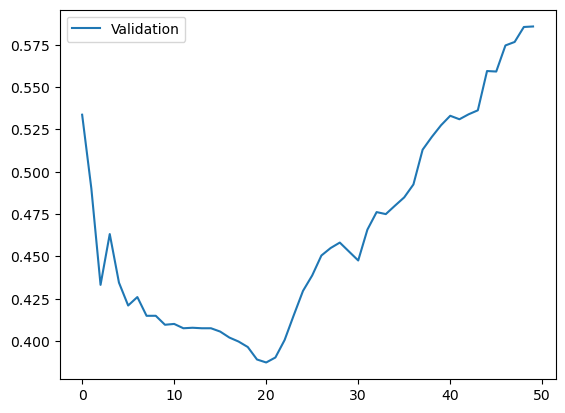

Minimum validation ECM: 0.387
Index of best parameter: 20


In [17]:
# Getting the average test scores
rlr_s_test_scores = abs(rlr_s_grid.cv_results_['mean_test_score'])

# Plotting the test scores
plt.plot(rlr_s_test_scores, label='Validation')
plt.legend(loc='best')
plt.show()

# Printing the minimum validation ECM and the index of the best parameter
print('Minimum validation ECM:', round(min(rlr_s_test_scores),3))
print('Index of best parameter:', np.argmin(rlr_s_test_scores))

In [18]:
# Best parameter
rlr_s_best_param = rlr_s_grid.best_params_
print(rlr_s_best_param)

# Get the best model from the grid search
rlr_s_best_model = rlr_s_grid.best_estimator_

# Predict on the test data using the best parameters
rlr_y_s_pred = rlr_s_best_model.predict(X_srlr_test)
rlr_y_s_pred_proba = rlr_s_best_model.predict_proba(X_srlr_test)[:, 1]

{'lr__C': 0.00018420699693267144, 'lr__penalty': 'l2'}


In [19]:
# Calculate the custom scorer for different threshold values
thresholds = np.arange(0.0, 1.0, 0.00001)
scores = []
for threshold in thresholds:
    preds = (rlr_y_s_pred_proba >= threshold).astype(int)
    score = ECM(y_srlr_test.values.ravel(), preds)
    scores.append(score)

# Find the threshold that gives the best score
rlr_s_best_threshold = thresholds[np.argmin(scores)]
print("Best threshold:", rlr_s_best_threshold)

# Adjusting predictions based on optimal threshold
rlr_y_s_pred = rlr_y_s_pred_proba >= rlr_s_best_threshold

# Calculating the various performance metrics
rlr_s_roc_auc = roc_auc_score(y_srlr_test.values.ravel(), rlr_y_s_pred_proba)
rlr_s_tn, rlr_s_fp, rlr_s_fn, rlr_s_tp = confusion_matrix(y_srlr_test.values.ravel(), rlr_y_s_pred).ravel()
rlr_s_sensitivity = rlr_s_tp / (rlr_s_tp + rlr_s_fn)
rlr_s_specificity = rlr_s_tn / (rlr_s_tn + rlr_s_fp)
rlr_s_accuracy = accuracy_score(y_srlr_test.values.ravel(),rlr_y_s_pred)
rlr_s_f1 = f1_score(y_srlr_test.values.ravel(), rlr_y_s_pred)
rlr_s_ecm_score = ECM(y_srlr_test.values.ravel(),rlr_y_s_pred)

# Printing the performance metrics
print("ROC AUC Score: {:.3f}".format(rlr_s_roc_auc))
print("Accuracy Score: {:.3f}".format(rlr_s_accuracy))
print("Specificity Score: {:.3f}".format(rlr_s_specificity))
print("Sensitivity Score: {:.3f}".format(rlr_s_sensitivity))
print("F1 Score: {:.3f}".format(rlr_s_f1))
print("ECM: {:.3f}".format(rlr_s_ecm_score))

Best threshold: 0.5336700000000001
ROC AUC Score: 0.682
Accuracy Score: 0.867
Specificity Score: 0.875
Sensitivity Score: 0.440
F1 Score: 0.102
ECM: 0.484


In [205]:
# Start timer
start_time = time.time()

# Fit model on data
rlr_s_best_model.fit(X_srlr_train, y_srlr_train)

# End timer
end_time = time.time()

# Calculate time taken to fit model
time_taken = end_time - start_time

# Print time taken
print(f"Time taken to fit SAPSO RLR: {time_taken:.5f} seconds")

Time taken to fit SAPSO RLR: 0.07032 seconds


## PSO Performance

In [14]:
# Importing the PSO data
pso = pd.read_csv('rlr_pso_data.csv')

# Defining X and y
y_prlr = pd.Series(data=pso['Target'])
X_prlr = pso.drop(columns=['Target'])

# Splitting the data
X_prlr_train, X_prlr_test, y_prlr_train, y_prlr_test = train_test_split(X_prlr, y_prlr, test_size=0.3, stratify=y_prlr,random_state=42)

# Numerical columns - PSO
num_cols_p = list(X_prlr_train.select_dtypes(include=['float']).columns)
# Non numerical columns - PSO
non_num_cols_p = list(X_prlr_train.select_dtypes(exclude=['float']).columns)

In [15]:
# Preprocessor
rlr_p_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols_p),
        ('non_num', 'passthrough', non_num_cols_p)
    ])

# Pipeline steps
rlr_p_pteps = [
    ("prep", rlr_p_preprocessor),
    ("over", SMOTE(random_state=42)), 
    ("lr", LogisticRegression(random_state=21, solver='lbfgs', max_iter=1000000)), 
]

# Pipeline
rlr_p_pipeline = Pipeline(rlr_p_pteps)

# Set up the grid search parameters
rlr_p_parameters = {'lr__C': np.logspace(-7,1,50),
                 'lr__penalty': ['l2']}

# Setting up the GridSearch with CV
rlr_p_grid = GridSearchCV(rlr_p_pipeline, rlr_p_parameters, cv=kf, verbose = 10, scoring=rlr_scoring)

# Fit the grid search object to the training data
rlr_p_grid.fit(X_prlr_train, y_prlr_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5; 1/50] START lr__C=1e-07, lr__penalty=l2................................
[CV 1/5; 1/50] END lr__C=1e-07, lr__penalty=l2;, score=-0.648 total time=   1.4s
[CV 2/5; 1/50] START lr__C=1e-07, lr__penalty=l2................................
[CV 2/5; 1/50] END lr__C=1e-07, lr__penalty=l2;, score=-0.418 total time=   1.2s
[CV 3/5; 1/50] START lr__C=1e-07, lr__penalty=l2................................
[CV 3/5; 1/50] END lr__C=1e-07, lr__penalty=l2;, score=-0.524 total time=   1.1s
[CV 4/5; 1/50] START lr__C=1e-07, lr__penalty=l2................................
[CV 4/5; 1/50] END lr__C=1e-07, lr__penalty=l2;, score=-0.489 total time=   1.0s
[CV 5/5; 1/50] START lr__C=1e-07, lr__penalty=l2................................
[CV 5/5; 1/50] END lr__C=1e-07, lr__penalty=l2;, score=-0.614 total time=   1.1s
[CV 1/5; 2/50] START lr__C=1.4563484775012443e-07, lr__penalty=l2...............
[CV 1/5; 2/50] END lr__C=1.4563484775012443e-07

[CV 2/5; 10/50] END lr__C=2.94705170255181e-06, lr__penalty=l2;, score=-0.412 total time=   1.1s
[CV 3/5; 10/50] START lr__C=2.94705170255181e-06, lr__penalty=l2................
[CV 3/5; 10/50] END lr__C=2.94705170255181e-06, lr__penalty=l2;, score=-0.474 total time=   1.0s
[CV 4/5; 10/50] START lr__C=2.94705170255181e-06, lr__penalty=l2................
[CV 4/5; 10/50] END lr__C=2.94705170255181e-06, lr__penalty=l2;, score=-0.328 total time=   1.0s
[CV 5/5; 10/50] START lr__C=2.94705170255181e-06, lr__penalty=l2................
[CV 5/5; 10/50] END lr__C=2.94705170255181e-06, lr__penalty=l2;, score=-0.493 total time=   1.0s
[CV 1/5; 11/50] START lr__C=4.291934260128778e-06, lr__penalty=l2...............
[CV 1/5; 11/50] END lr__C=4.291934260128778e-06, lr__penalty=l2;, score=-0.552 total time=   0.9s
[CV 2/5; 11/50] START lr__C=4.291934260128778e-06, lr__penalty=l2...............
[CV 2/5; 11/50] END lr__C=4.291934260128778e-06, lr__penalty=l2;, score=-0.412 total time=   1.1s
[CV 3/5; 11

[CV 3/5; 19/50] END lr__C=8.68511373751352e-05, lr__penalty=l2;, score=-0.451 total time=   1.0s
[CV 4/5; 19/50] START lr__C=8.68511373751352e-05, lr__penalty=l2................
[CV 4/5; 19/50] END lr__C=8.68511373751352e-05, lr__penalty=l2;, score=-0.286 total time=   1.0s
[CV 5/5; 19/50] START lr__C=8.68511373751352e-05, lr__penalty=l2................
[CV 5/5; 19/50] END lr__C=8.68511373751352e-05, lr__penalty=l2;, score=-0.467 total time=   1.0s
[CV 1/5; 20/50] START lr__C=0.00012648552168552957, lr__penalty=l2..............
[CV 1/5; 20/50] END lr__C=0.00012648552168552957, lr__penalty=l2;, score=-0.513 total time=   1.0s
[CV 2/5; 20/50] START lr__C=0.00012648552168552957, lr__penalty=l2..............
[CV 2/5; 20/50] END lr__C=0.00012648552168552957, lr__penalty=l2;, score=-0.411 total time=   1.0s
[CV 3/5; 20/50] START lr__C=0.00012648552168552957, lr__penalty=l2..............
[CV 3/5; 20/50] END lr__C=0.00012648552168552957, lr__penalty=l2;, score=-0.436 total time=   1.0s
[CV 4/5

[CV 4/5; 28/50] END lr__C=0.0025595479226995332, lr__penalty=l2;, score=-0.403 total time=   1.2s
[CV 5/5; 28/50] START lr__C=0.0025595479226995332, lr__penalty=l2...............
[CV 5/5; 28/50] END lr__C=0.0025595479226995332, lr__penalty=l2;, score=-0.584 total time=   1.1s
[CV 1/5; 29/50] START lr__C=0.003727593720314938, lr__penalty=l2................
[CV 1/5; 29/50] END lr__C=0.003727593720314938, lr__penalty=l2;, score=-0.589 total time=   1.3s
[CV 2/5; 29/50] START lr__C=0.003727593720314938, lr__penalty=l2................
[CV 2/5; 29/50] END lr__C=0.003727593720314938, lr__penalty=l2;, score=-0.396 total time=   1.2s
[CV 3/5; 29/50] START lr__C=0.003727593720314938, lr__penalty=l2................
[CV 3/5; 29/50] END lr__C=0.003727593720314938, lr__penalty=l2;, score=-0.509 total time=   1.2s
[CV 4/5; 29/50] START lr__C=0.003727593720314938, lr__penalty=l2................
[CV 4/5; 29/50] END lr__C=0.003727593720314938, lr__penalty=l2;, score=-0.409 total time=   1.2s
[CV 5/5; 29

[CV 1/5; 38/50] END lr__C=0.10985411419875572, lr__penalty=l2;, score=-0.668 total time=   1.2s
[CV 2/5; 38/50] START lr__C=0.10985411419875572, lr__penalty=l2.................
[CV 2/5; 38/50] END lr__C=0.10985411419875572, lr__penalty=l2;, score=-0.469 total time=   1.3s
[CV 3/5; 38/50] START lr__C=0.10985411419875572, lr__penalty=l2.................
[CV 3/5; 38/50] END lr__C=0.10985411419875572, lr__penalty=l2;, score=-0.505 total time=   1.2s
[CV 4/5; 38/50] START lr__C=0.10985411419875572, lr__penalty=l2.................
[CV 4/5; 38/50] END lr__C=0.10985411419875572, lr__penalty=l2;, score=-0.506 total time=   1.2s
[CV 5/5; 38/50] START lr__C=0.10985411419875572, lr__penalty=l2.................
[CV 5/5; 38/50] END lr__C=0.10985411419875572, lr__penalty=l2;, score=-0.605 total time=   1.3s
[CV 1/5; 39/50] START lr__C=0.15998587196060574, lr__penalty=l2.................
[CV 1/5; 39/50] END lr__C=0.15998587196060574, lr__penalty=l2;, score=-0.659 total time=   1.2s
[CV 2/5; 39/50] STA

[CV 3/5; 47/50] END lr__C=3.2374575428176398, lr__penalty=l2;, score=-0.510 total time=   1.5s
[CV 4/5; 47/50] START lr__C=3.2374575428176398, lr__penalty=l2..................
[CV 4/5; 47/50] END lr__C=3.2374575428176398, lr__penalty=l2;, score=-0.463 total time=   1.4s
[CV 5/5; 47/50] START lr__C=3.2374575428176398, lr__penalty=l2..................
[CV 5/5; 47/50] END lr__C=3.2374575428176398, lr__penalty=l2;, score=-0.600 total time=   1.5s
[CV 1/5; 48/50] START lr__C=4.714866363457389, lr__penalty=l2...................
[CV 1/5; 48/50] END lr__C=4.714866363457389, lr__penalty=l2;, score=-0.571 total time=   1.6s
[CV 2/5; 48/50] START lr__C=4.714866363457389, lr__penalty=l2...................
[CV 2/5; 48/50] END lr__C=4.714866363457389, lr__penalty=l2;, score=-0.667 total time=   1.5s
[CV 3/5; 48/50] START lr__C=4.714866363457389, lr__penalty=l2...................
[CV 3/5; 48/50] END lr__C=4.714866363457389, lr__penalty=l2;, score=-0.507 total time=   1.5s
[CV 4/5; 48/50] START lr__C=

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=25, shuffle=True),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['ARtS',
                                                                          'AFDA',
                                                                          'AFDAtNS',
                                                                          'cItS',
                                                                          'DiRI',
                                                                          'DfF',
                                                                          '4GSGR',
                                                                          'GM',
                                                

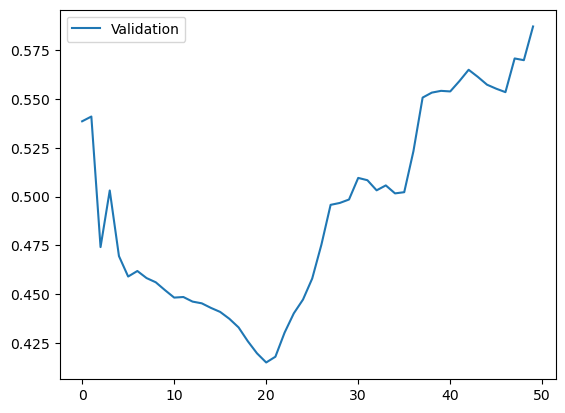

Minimum validation ECM: 0.415
Index of best parameter: 20


In [16]:
# Getting the average test scores
rlr_p_test_scores = abs(rlr_p_grid.cv_results_['mean_test_score'])

# Plotting the test scores
plt.plot(rlr_p_test_scores, label='Validation')
plt.legend(loc='best')
plt.show()

# Printing the minimum validation ECM and the index of the best parameter
print('Minimum validation ECM:', round(min(rlr_p_test_scores),3))
print('Index of best parameter:', np.argmin(rlr_p_test_scores))

In [17]:
# Best parameter
rlr_p_best_param = rlr_p_grid.best_params_
print(rlr_p_best_param)

# Get the best model from the grid search
rlr_p_best_model = rlr_p_grid.best_estimator_

# Predict on the test data using the best parameters
rlr_y_p_pred = rlr_p_best_model.predict(X_prlr_test)
rlr_y_p_pred_proba = rlr_p_best_model.predict_proba(X_prlr_test)[:, 1]

{'lr__C': 0.00018420699693267144, 'lr__penalty': 'l2'}


In [18]:
# Calculate the custom scorer for different threshold values
thresholds = np.arange(0.0, 1.0, 0.00001)
scores = []
for threshold in thresholds:
    preds = (rlr_y_p_pred_proba >= threshold).astype(int)
    score = ECM(y_prlr_test.values.ravel(), preds)
    scores.append(score)

# Find the threshold that gives the best score
rlr_p_best_threshold = thresholds[np.argmin(scores)]
print("Best threshold:", rlr_p_best_threshold)

# Adjusting predictions based on optimal threshold
rlr_y_p_pred = rlr_y_p_pred_proba >= rlr_p_best_threshold

# Calculating the various performance metrics
rlr_p_roc_auc = roc_auc_score(y_prlr_test.values.ravel(), rlr_y_p_pred_proba)
rlr_p_tn, rlr_p_fp, rlr_p_fn, rlr_p_tp = confusion_matrix(y_prlr_test.values.ravel(), rlr_y_p_pred).ravel()
rlr_p_sensitivity = rlr_p_tp / (rlr_p_tp + rlr_p_fn)
rlr_p_specificity = rlr_p_tn / (rlr_p_tn + rlr_p_fp)
rlr_p_accuracy = accuracy_score(y_prlr_test.values.ravel(),rlr_y_p_pred)
rlr_p_f1 = f1_score(y_prlr_test.values.ravel(), rlr_y_p_pred)
rlr_p_ecm_score = ECM(y_prlr_test.values.ravel(),rlr_y_p_pred)

# Printing the performance metrics
print("ROC AUC Score: {:.3f}".format(rlr_p_roc_auc))
print("Accuracy Score: {:.3f}".format(rlr_p_accuracy))
print("Specificity Score: {:.3f}".format(rlr_p_specificity))
print("Sensitivity Score: {:.3f}".format(rlr_p_sensitivity))
print("F1 Score: {:.3f}".format(rlr_p_f1))
print("ECM: {:.3f}".format(rlr_p_ecm_score))

Best threshold: 0.5439900000000001
ROC AUC Score: 0.672
Accuracy Score: 0.886
Specificity Score: 0.893
Sensitivity Score: 0.480
F1 Score: 0.126
ECM: 0.440


In [19]:
# Start timer
start_time = time.time()

# Fit model on data
rlr_p_best_model.fit(X_prlr_train, y_prlr_train)

# End timer
end_time = time.time()

# Calculate time taken to fit model
time_taken = end_time - start_time

# Print time taken
print(f"Time taken to fit PSO RLR: {time_taken:.5f} seconds")

Time taken to fit PSO RLR: 0.09586 seconds


# K-Nearest Neighbors

## Baseline Performance

In [98]:
# Preprocessor
knn_b_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols_b),
        ('non_num', 'passthrough', non_num_cols_b)
    ])

# Pipeline steps
knn_b_steps = [
    ("prep", knn_b_preprocessor),
    ("over", SMOTE(random_state=42)), 
    ("knn", KNeighborsClassifier())
]

# Pipeline
knn_b_pipeline = Pipeline(knn_b_steps)

# Set up the grid search parameters
knn_b_parameters = {'knn__n_neighbors': np.arange(1, 30, 2),
                    'knn__p': [2],
                   'knn__weights':['distance']}

# Setting up the GridSearch with CV
knn_b_grid = GridSearchCV(knn_b_pipeline, knn_b_parameters, cv=kf, verbose = 10, scoring=knn_scoring)

# Fit the grid search object to the training data
knn_b_grid.fit(X_b_train, y_b_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5; 1/15] START knn__n_neighbors=1, knn__p=2, knn__weights=distance........
[CV 1/5; 1/15] END knn__n_neighbors=1, knn__p=2, knn__weights=distance;, score=-0.540 total time=   1.1s
[CV 2/5; 1/15] START knn__n_neighbors=1, knn__p=2, knn__weights=distance........
[CV 2/5; 1/15] END knn__n_neighbors=1, knn__p=2, knn__weights=distance;, score=-0.667 total time=   1.1s
[CV 3/5; 1/15] START knn__n_neighbors=1, knn__p=2, knn__weights=distance........
[CV 3/5; 1/15] END knn__n_neighbors=1, knn__p=2, knn__weights=distance;, score=-0.446 total time=   1.1s
[CV 4/5; 1/15] START knn__n_neighbors=1, knn__p=2, knn__weights=distance........
[CV 4/5; 1/15] END knn__n_neighbors=1, knn__p=2, knn__weights=distance;, score=-0.653 total time=   1.1s
[CV 5/5; 1/15] START knn__n_neighbors=1, knn__p=2, knn__weights=distance........
[CV 5/5; 1/15] END knn__n_neighbors=1, knn__p=2, knn__weights=distance;, score=-0.552 total time=   1.1s
[CV 1/5; 

[CV 5/5; 9/15] END knn__n_neighbors=17, knn__p=2, knn__weights=distance;, score=-0.547 total time=   1.2s
[CV 1/5; 10/15] START knn__n_neighbors=19, knn__p=2, knn__weights=distance......
[CV 1/5; 10/15] END knn__n_neighbors=19, knn__p=2, knn__weights=distance;, score=-0.478 total time=   1.1s
[CV 2/5; 10/15] START knn__n_neighbors=19, knn__p=2, knn__weights=distance......
[CV 2/5; 10/15] END knn__n_neighbors=19, knn__p=2, knn__weights=distance;, score=-0.534 total time=   1.5s
[CV 3/5; 10/15] START knn__n_neighbors=19, knn__p=2, knn__weights=distance......
[CV 3/5; 10/15] END knn__n_neighbors=19, knn__p=2, knn__weights=distance;, score=-0.467 total time=   1.4s
[CV 4/5; 10/15] START knn__n_neighbors=19, knn__p=2, knn__weights=distance......
[CV 4/5; 10/15] END knn__n_neighbors=19, knn__p=2, knn__weights=distance;, score=-0.580 total time=   1.4s
[CV 5/5; 10/15] START knn__n_neighbors=19, knn__p=2, knn__weights=distance......
[CV 5/5; 10/15] END knn__n_neighbors=19, knn__p=2, knn__weigh

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=25, shuffle=True),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['ARtS',
                                                                          'ARtTA',
                                                                          'AFDA',
                                                                          'AFDAtAR',
                                                                          'AFDAtNS',
                                                                          'Zscore',
                                                                          'Big4',
                                                                          'cItS',
                                        

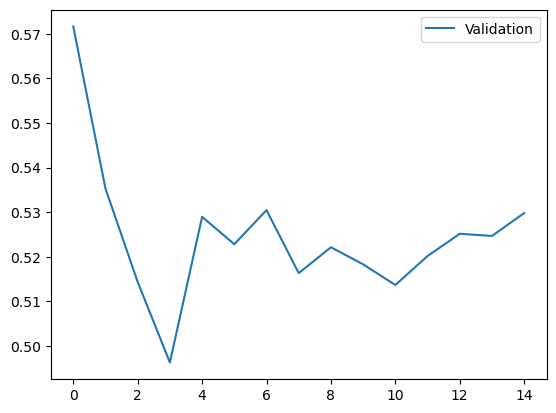

Minimum validation ECM: 0.496
Index of best parameter: 3


In [99]:
# Getting the average test scores
knn_b_test_scores = abs(knn_b_grid.cv_results_['mean_test_score'])
knn_b_param_values = knn_b_grid.param_grid['knn__n_neighbors']

# Plotting the test scores
plt.plot(knn_b_test_scores, label='Validation')
plt.legend(loc='best')
plt.show()

# Printing the minimum validation ECM and the index of the best parameter
print('Minimum validation ECM:', round(min(knn_b_test_scores),3))
print('Index of best parameter:', np.argmin(knn_b_test_scores))

In [100]:
# Best parameter
knn_b_best_param = knn_b_grid.best_params_
print(knn_b_best_param)

# Get the best model from the grid search
knn_b_best_model = knn_b_grid.best_estimator_

# Predict on the test data using the best parameters
knn_y_b_pred = knn_b_best_model.predict(X_b_test)
knn_y_b_pred_proba = knn_b_best_model.predict_proba(X_b_test)[:, 1]

{'knn__n_neighbors': 7, 'knn__p': 2, 'knn__weights': 'distance'}


In [101]:
# Calculate the custom scorer for different threshold values
thresholds = np.arange(0.0, 1.0, 0.00001)
scores = []
for threshold in thresholds:
    preds = (knn_y_b_pred_proba >= threshold).astype(int)
    score = ECM(y_b_test.values.ravel(), preds)
    scores.append(score)

# Find the threshold that gives the best score
knn_b_best_threshold = thresholds[np.argmin(scores)]
print("Best threshold:", knn_b_best_threshold)

# Adjusting predictions based on optimal threshold
knn_y_b_pred = knn_y_b_pred_proba >= knn_b_best_threshold

# Calculating the various performance metrics
knn_b_roc_auc = roc_auc_score(y_b_test.values.ravel(), knn_y_b_pred_proba)
knn_b_tn, knn_b_fp, knn_b_fn, knn_b_tp = confusion_matrix(y_b_test.values.ravel(), knn_y_b_pred).ravel()
knn_b_sensitivity = knn_b_tp / (knn_b_tp + knn_b_fn)
knn_b_specificity = knn_b_tn / (knn_b_tn + knn_b_fp)
knn_b_accuracy = accuracy_score(y_b_test.values.ravel(),knn_y_b_pred)
knn_b_f1 = f1_score(y_b_test.values.ravel(), knn_y_b_pred)
knn_b_ecm_score = ECM(y_b_test.values.ravel(),knn_y_b_pred)

# Printing the performance metrics
print("ROC AUC Score: {:.3f}".format(knn_b_roc_auc))
print("Accuracy Score: {:.3f}".format(knn_b_accuracy))
print("Specificity Score: {:.3f}".format(knn_b_specificity))
print("Sensitivity Score: {:.3f}".format(knn_b_sensitivity))
print("F1 Score: {:.3f}".format(knn_b_f1))
print("ECM: {:.3f}".format(knn_b_ecm_score))

Best threshold: 0.7070700000000001
ROC AUC Score: 0.621
Accuracy Score: 0.877
Specificity Score: 0.884
Sensitivity Score: 0.440
F1 Score: 0.109
ECM: 0.475


In [236]:
# Start timer
start_time = time.time()

# Fit model on data
knn_b_best_model.fit(X_b_train, y_b_train)

# End timer
end_time = time.time()

# Calculate time taken to fit model
time_taken = end_time - start_time

# Print time taken
print(f"Time taken to fit baseline KNN: {time_taken:.5f} seconds")

Time taken to fit baseline KNN: 0.06144 seconds


## MD&A Performance

In [102]:
# Preprocessor
knn_m_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols_m),
        ('non_num', 'passthrough', non_num_cols_m)
    ])

# Pipeline steps
knn_m_steps = [
    ("prep", knn_m_preprocessor),
    ("over", SMOTE(random_state=42)), 
    ("knn", KNeighborsClassifier())
]

# Pipeline
knn_m_pipeline = Pipeline(knn_m_steps)

# Set up the grid search parameters
knn_m_parameters = {'knn__n_neighbors': np.arange(1, 30, 2),
                    'knn__p': [2],
                   'knn__weights':['distance']}

# Setting up the GridSearch with CV
knn_m_grid = GridSearchCV(knn_m_pipeline, knn_m_parameters, cv=kf, verbose = 10, scoring=knn_scoring)

# Fit the grid search object to the training data
knn_m_grid.fit(X_m_train, y_m_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5; 1/15] START knn__n_neighbors=1, knn__p=2, knn__weights=distance........
[CV 1/5; 1/15] END knn__n_neighbors=1, knn__p=2, knn__weights=distance;, score=-0.490 total time=   0.8s
[CV 2/5; 1/15] START knn__n_neighbors=1, knn__p=2, knn__weights=distance........
[CV 2/5; 1/15] END knn__n_neighbors=1, knn__p=2, knn__weights=distance;, score=-0.674 total time=   0.9s
[CV 3/5; 1/15] START knn__n_neighbors=1, knn__p=2, knn__weights=distance........
[CV 3/5; 1/15] END knn__n_neighbors=1, knn__p=2, knn__weights=distance;, score=-0.460 total time=   1.0s
[CV 4/5; 1/15] START knn__n_neighbors=1, knn__p=2, knn__weights=distance........
[CV 4/5; 1/15] END knn__n_neighbors=1, knn__p=2, knn__weights=distance;, score=-0.617 total time=   1.1s
[CV 5/5; 1/15] START knn__n_neighbors=1, knn__p=2, knn__weights=distance........
[CV 5/5; 1/15] END knn__n_neighbors=1, knn__p=2, knn__weights=distance;, score=-0.617 total time=   1.0s
[CV 1/5; 

[CV 5/5; 9/15] END knn__n_neighbors=17, knn__p=2, knn__weights=distance;, score=-0.440 total time=   0.9s
[CV 1/5; 10/15] START knn__n_neighbors=19, knn__p=2, knn__weights=distance......
[CV 1/5; 10/15] END knn__n_neighbors=19, knn__p=2, knn__weights=distance;, score=-0.455 total time=   0.9s
[CV 2/5; 10/15] START knn__n_neighbors=19, knn__p=2, knn__weights=distance......
[CV 2/5; 10/15] END knn__n_neighbors=19, knn__p=2, knn__weights=distance;, score=-0.568 total time=   0.9s
[CV 3/5; 10/15] START knn__n_neighbors=19, knn__p=2, knn__weights=distance......
[CV 3/5; 10/15] END knn__n_neighbors=19, knn__p=2, knn__weights=distance;, score=-0.470 total time=   0.9s
[CV 4/5; 10/15] START knn__n_neighbors=19, knn__p=2, knn__weights=distance......
[CV 4/5; 10/15] END knn__n_neighbors=19, knn__p=2, knn__weights=distance;, score=-0.611 total time=   1.0s
[CV 5/5; 10/15] START knn__n_neighbors=19, knn__p=2, knn__weights=distance......
[CV 5/5; 10/15] END knn__n_neighbors=19, knn__p=2, knn__weigh

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=25, shuffle=True),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['ARtS',
                                                                          'ARtTA',
                                                                          'AFDA',
                                                                          'AFDAtAR',
                                                                          'AFDAtNS',
                                                                          'Zscore',
                                                                          'Big4',
                                                                          'cItS',
                                        

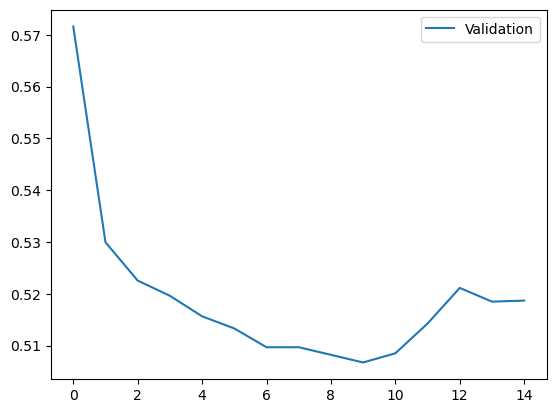

Minimum validation ECM: 0.507
Index of best parameter: 9


In [103]:
# Getting the average test scores
knn_m_test_scores = abs(knn_m_grid.cv_results_['mean_test_score'])
knn_m_param_values = knn_m_grid.param_grid['knn__n_neighbors']

# Plotting the test scores
plt.plot(knn_m_test_scores, label='Validation')
plt.legend(loc='best')
plt.show()

# Printing the minimum validation ECM and the index of the best parameter
print('Minimum validation ECM:', round(min(knn_m_test_scores),3))
print('Index of best parameter:', np.argmin(knn_m_test_scores))

In [104]:
# Best parameter
knn_m_best_param = knn_m_grid.best_params_
print(knn_m_best_param)

# Get the best model from the grid search
knn_m_best_model = knn_m_grid.best_estimator_

# Predict on the test data using the best parameters
knn_y_m_pred = knn_m_best_model.predict(X_m_test)
knn_y_m_pred_proba = knn_m_best_model.predict_proba(X_m_test)[:, 1]

{'knn__n_neighbors': 19, 'knn__p': 2, 'knn__weights': 'distance'}


In [105]:
# Calculate the custom scorer for different threshold values
thresholds = np.arange(0.0, 1.0, 0.00001)
scores = []
for threshold in thresholds:
    preds = (knn_y_m_pred_proba >= threshold).astype(int)
    score = ECM(y_m_test.values.ravel(), preds)
    scores.append(score)

# Find the threshold that gives the best score
knn_m_best_threshold = thresholds[np.argmin(scores)]
print("Best threshold:", knn_m_best_threshold)

# Adjusting predictions based on optimal threshold
knn_y_m_pred = knn_y_m_pred_proba >= knn_m_best_threshold

# Calculating the various performance metrics
knn_m_roc_auc = roc_auc_score(y_m_test.values.ravel(), knn_y_m_pred_proba)
knn_m_tn, knn_m_fp, knn_m_fn, knn_m_tp = confusion_matrix(y_m_test.values.ravel(), knn_y_m_pred).ravel()
knn_m_sensitivity = knn_m_tp / (knn_m_tp + knn_m_fn)
knn_m_specificity = knn_m_tn / (knn_m_tn + knn_m_fp)
knn_m_accuracy = accuracy_score(y_m_test.values.ravel(),knn_y_m_pred)
knn_m_f1 = f1_score(y_m_test.values.ravel(), knn_y_m_pred)
knn_m_ecm_score = ECM(y_m_test.values.ravel(),knn_y_m_pred)

# Printing the performance metrics
print("ROC AUC Score: {:.3f}".format(knn_m_roc_auc))
print("Accuracy Score: {:.3f}".format(knn_m_accuracy))
print("Specificity Score: {:.3f}".format(knn_m_specificity))
print("Sensitivity Score: {:.3f}".format(knn_m_sensitivity))
print("F1 Score: {:.3f}".format(knn_m_f1))
print("ECM: {:.3f}".format(knn_m_ecm_score))

Best threshold: 0.7905300000000001
ROC AUC Score: 0.599
Accuracy Score: 0.867
Specificity Score: 0.876
Sensitivity Score: 0.360
F1 Score: 0.085
ECM: 0.535


In [235]:
# Start timer
start_time = time.time()

# Fit model on data
knn_m_best_model.fit(X_m_train, y_m_train)

# End timer
end_time = time.time()

# Calculate time taken to fit model
time_taken = end_time - start_time

# Print time taken
print(f"Time taken to fit MD&A KNN: {time_taken:.5f} seconds")

Time taken to fit MD&A KNN: 0.06370 seconds


## ECT Performance

In [106]:
# Preprocessor
knn_e_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols_e),
        ('non_num', 'passthrough', non_num_cols_e)
    ])

# Pipeline steps
knn_e_steps = [
    ("prep", knn_e_preprocessor),
    ("over", SMOTE(random_state=42)), 
    ("knn", KNeighborsClassifier())
]

# Pipeline
knn_e_pipeline = Pipeline(knn_e_steps)

# Set up the grid search parameters
knn_e_parameters = {'knn__n_neighbors': np.arange(1, 30, 2),
                    'knn__p': [2],
                   'knn__weights':['distance']}

# Setting up the GridSearch with CV
knn_e_grid = GridSearchCV(knn_e_pipeline, knn_e_parameters, cv=kf, verbose = 10, scoring=knn_scoring)

# Fit the grid search object to the training data
knn_e_grid.fit(X_e_train, y_e_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5; 1/15] START knn__n_neighbors=1, knn__p=2, knn__weights=distance........
[CV 1/5; 1/15] END knn__n_neighbors=1, knn__p=2, knn__weights=distance;, score=-0.556 total time=   1.0s
[CV 2/5; 1/15] START knn__n_neighbors=1, knn__p=2, knn__weights=distance........
[CV 2/5; 1/15] END knn__n_neighbors=1, knn__p=2, knn__weights=distance;, score=-0.593 total time=   1.0s
[CV 3/5; 1/15] START knn__n_neighbors=1, knn__p=2, knn__weights=distance........
[CV 3/5; 1/15] END knn__n_neighbors=1, knn__p=2, knn__weights=distance;, score=-0.519 total time=   0.9s
[CV 4/5; 1/15] START knn__n_neighbors=1, knn__p=2, knn__weights=distance........
[CV 4/5; 1/15] END knn__n_neighbors=1, knn__p=2, knn__weights=distance;, score=-0.607 total time=   0.9s
[CV 5/5; 1/15] START knn__n_neighbors=1, knn__p=2, knn__weights=distance........
[CV 5/5; 1/15] END knn__n_neighbors=1, knn__p=2, knn__weights=distance;, score=-0.598 total time=   1.0s
[CV 1/5; 

[CV 5/5; 9/15] END knn__n_neighbors=17, knn__p=2, knn__weights=distance;, score=-0.510 total time=   1.1s
[CV 1/5; 10/15] START knn__n_neighbors=19, knn__p=2, knn__weights=distance......
[CV 1/5; 10/15] END knn__n_neighbors=19, knn__p=2, knn__weights=distance;, score=-0.471 total time=   1.1s
[CV 2/5; 10/15] START knn__n_neighbors=19, knn__p=2, knn__weights=distance......
[CV 2/5; 10/15] END knn__n_neighbors=19, knn__p=2, knn__weights=distance;, score=-0.564 total time=   1.1s
[CV 3/5; 10/15] START knn__n_neighbors=19, knn__p=2, knn__weights=distance......
[CV 3/5; 10/15] END knn__n_neighbors=19, knn__p=2, knn__weights=distance;, score=-0.484 total time=   1.2s
[CV 4/5; 10/15] START knn__n_neighbors=19, knn__p=2, knn__weights=distance......
[CV 4/5; 10/15] END knn__n_neighbors=19, knn__p=2, knn__weights=distance;, score=-0.612 total time=   1.1s
[CV 5/5; 10/15] START knn__n_neighbors=19, knn__p=2, knn__weights=distance......
[CV 5/5; 10/15] END knn__n_neighbors=19, knn__p=2, knn__weigh

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=25, shuffle=True),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['ARtS',
                                                                          'ARtTA',
                                                                          'AFDA',
                                                                          'AFDAtAR',
                                                                          'AFDAtNS',
                                                                          'Zscore',
                                                                          'Big4',
                                                                          'cItS',
                                        

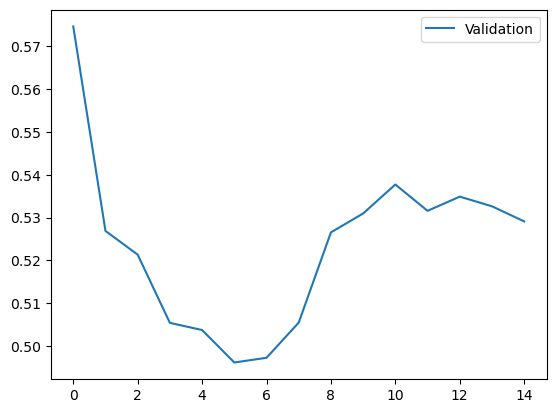

Minimum validation ECM: 0.496
Index of best parameter: 5


In [107]:
# Getting the average test scores
knn_e_test_scores = abs(knn_e_grid.cv_results_['mean_test_score'])
knn_e_param_values = knn_e_grid.param_grid['knn__n_neighbors']

# Plotting the test scores
plt.plot(knn_e_test_scores, label='Validation')
plt.legend(loc='best')
plt.show()

# Printing the minimum validation ECM and the index of the best parameter
print('Minimum validation ECM:', round(min(knn_e_test_scores),3))
print('Index of best parameter:', np.argmin(knn_e_test_scores))

In [108]:
# Best parameter
knn_e_best_param = knn_e_grid.best_params_
print(knn_e_best_param)

# Get the best model from the grid search
knn_e_best_model = knn_e_grid.best_estimator_

# Predict on the test data using the best parameters
knn_y_e_pred = knn_e_best_model.predict(X_e_test)
knn_y_e_pred_proba = knn_e_best_model.predict_proba(X_e_test)[:, 1]

{'knn__n_neighbors': 11, 'knn__p': 2, 'knn__weights': 'distance'}


In [109]:
# Calculate the custom scorer for different threshold values
thresholds = np.arange(0.0, 1.0, 0.00001)
scores = []
for threshold in thresholds:
    preds = (knn_y_e_pred_proba >= threshold).astype(int)
    score = ECM(y_e_test.values.ravel(), preds)
    scores.append(score)

# Find the threshold that gives the best score
knn_e_best_threshold = thresholds[np.argmin(scores)]
print("Best threshold:", knn_e_best_threshold)

# Adjusting predictions based on optimal threshold
knn_y_e_pred = knn_y_e_pred_proba >= knn_e_best_threshold

# Calculating the various performance metrics
knn_e_roc_auc = roc_auc_score(y_e_test.values.ravel(), knn_y_e_pred_proba)
knn_e_tn, knn_e_fp, knn_e_fn, knn_e_tp = confusion_matrix(y_e_test.values.ravel(), knn_y_e_pred).ravel()
knn_e_sensitivity = knn_e_tp / (knn_e_tp + knn_e_fn)
knn_e_specificity = knn_e_tn / (knn_e_tn + knn_e_fp)
knn_e_accuracy = accuracy_score(y_e_test.values.ravel(),knn_y_e_pred)
knn_e_f1 = f1_score(y_e_test.values.ravel(), knn_y_e_pred)
knn_e_ecm_score = ECM(y_e_test.values.ravel(),knn_y_e_pred)

# Printing the performance metrics
print("ROC AUC Score: {:.3f}".format(knn_e_roc_auc))
print("Accuracy Score: {:.3f}".format(knn_e_accuracy))
print("Specificity Score: {:.3f}".format(knn_e_specificity))
print("Sensitivity Score: {:.3f}".format(knn_e_sensitivity))
print("F1 Score: {:.3f}".format(knn_e_f1))
print("ECM: {:.3f}".format(knn_e_ecm_score))

Best threshold: 0.81701
ROC AUC Score: 0.625
Accuracy Score: 0.873
Specificity Score: 0.883
Sensitivity Score: 0.320
F1 Score: 0.080
ECM: 0.554


In [234]:
# Start timer
start_time = time.time()

# Fit model on data
knn_e_best_model.fit(X_e_train, y_e_train)

# End timer
end_time = time.time()

# Calculate time taken to fit model
time_taken = end_time - start_time

# Print time taken
print(f"Time taken to fit ECT KNN: {time_taken:.5f} seconds")

Time taken to fit ECT KNN: 0.08817 seconds


## Full Model Performance

In [110]:
# Preprocessor
knn_f_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols_f),
        ('non_num', 'passthrough', non_num_cols_f)
    ])

# Pipeline steps
knn_f_steps = [
    ("prep", knn_f_preprocessor),
    ("over", SMOTE(random_state=42)), 
    ("knn", KNeighborsClassifier())
]

# Pipeline
knn_f_pipeline = Pipeline(knn_f_steps)

# Set up the grid search parameters
knn_f_parameters = {'knn__n_neighbors': np.arange(1, 30, 2),
                    'knn__p': [2],
                   'knn__weights':['distance']}

# Setting up the GridSearch with CV
knn_f_grid = GridSearchCV(knn_f_pipeline, knn_f_parameters, cv=kf, verbose = 10, scoring=knn_scoring)

# Fit the grid search object to the training data
knn_f_grid.fit(X_f_train, y_f_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5; 1/15] START knn__n_neighbors=1, knn__p=2, knn__weights=distance........
[CV 1/5; 1/15] END knn__n_neighbors=1, knn__p=2, knn__weights=distance;, score=-0.551 total time=   1.2s
[CV 2/5; 1/15] START knn__n_neighbors=1, knn__p=2, knn__weights=distance........
[CV 2/5; 1/15] END knn__n_neighbors=1, knn__p=2, knn__weights=distance;, score=-0.584 total time=   1.1s
[CV 3/5; 1/15] START knn__n_neighbors=1, knn__p=2, knn__weights=distance........
[CV 3/5; 1/15] END knn__n_neighbors=1, knn__p=2, knn__weights=distance;, score=-0.579 total time=   1.1s
[CV 4/5; 1/15] START knn__n_neighbors=1, knn__p=2, knn__weights=distance........
[CV 4/5; 1/15] END knn__n_neighbors=1, knn__p=2, knn__weights=distance;, score=-0.611 total time=   0.9s
[CV 5/5; 1/15] START knn__n_neighbors=1, knn__p=2, knn__weights=distance........
[CV 5/5; 1/15] END knn__n_neighbors=1, knn__p=2, knn__weights=distance;, score=-0.602 total time=   1.0s
[CV 1/5; 

[CV 5/5; 9/15] END knn__n_neighbors=17, knn__p=2, knn__weights=distance;, score=-0.586 total time=   1.0s
[CV 1/5; 10/15] START knn__n_neighbors=19, knn__p=2, knn__weights=distance......
[CV 1/5; 10/15] END knn__n_neighbors=19, knn__p=2, knn__weights=distance;, score=-0.484 total time=   1.0s
[CV 2/5; 10/15] START knn__n_neighbors=19, knn__p=2, knn__weights=distance......
[CV 2/5; 10/15] END knn__n_neighbors=19, knn__p=2, knn__weights=distance;, score=-0.558 total time=   1.0s
[CV 3/5; 10/15] START knn__n_neighbors=19, knn__p=2, knn__weights=distance......
[CV 3/5; 10/15] END knn__n_neighbors=19, knn__p=2, knn__weights=distance;, score=-0.485 total time=   1.0s
[CV 4/5; 10/15] START knn__n_neighbors=19, knn__p=2, knn__weights=distance......
[CV 4/5; 10/15] END knn__n_neighbors=19, knn__p=2, knn__weights=distance;, score=-0.603 total time=   1.2s
[CV 5/5; 10/15] START knn__n_neighbors=19, knn__p=2, knn__weights=distance......
[CV 5/5; 10/15] END knn__n_neighbors=19, knn__p=2, knn__weigh

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=25, shuffle=True),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['ARtS',
                                                                          'ARtTA',
                                                                          'AFDA',
                                                                          'AFDAtAR',
                                                                          'AFDAtNS',
                                                                          'Zscore',
                                                                          'Big4',
                                                                          'cItS',
                                        

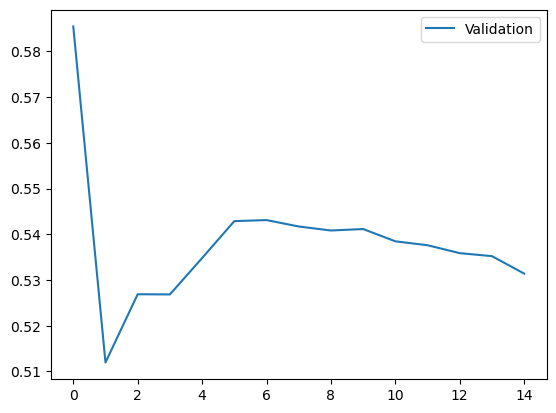

Minimum validation ECM: 0.512
Index of best parameter: 1


In [111]:
# Getting the average test scores
knn_f_test_scores = abs(knn_f_grid.cv_results_['mean_test_score'])
knn_f_param_values = knn_f_grid.param_grid['knn__n_neighbors']

# Plotting the test scores
plt.plot(knn_f_test_scores, label='Validation')
plt.legend(loc='best')
plt.show()

# Printing the minimum validation ECM and the index of the best parameter
print('Minimum validation ECM:', round(min(knn_f_test_scores),3))
print('Index of best parameter:', np.argmin(knn_f_test_scores))

In [112]:
# Best parameter
knn_f_best_param = knn_f_grid.best_params_
print(knn_f_best_param)

# Get the best model from the grid search
knn_f_best_model = knn_f_grid.best_estimator_

# Predict on the test data using the best parameters
knn_y_f_pred = knn_f_best_model.predict(X_f_test)
knn_y_f_pred_proba = knn_f_best_model.predict_proba(X_f_test)[:, 1]

{'knn__n_neighbors': 3, 'knn__p': 2, 'knn__weights': 'distance'}


In [113]:
# Calculate the custom scorer for different threshold values
thresholds = np.arange(0.0, 1.0, 0.00001)
scores = []
for threshold in thresholds:
    preds = (knn_y_f_pred_proba >= threshold).astype(int)
    score = ECM(y_f_test.values.ravel(), preds)
    scores.append(score)

# Find the threshold that gives the best score
knn_f_best_threshold = thresholds[np.argmin(scores)]
print("Best threshold:", knn_f_best_threshold)

# Adjusting predictions based on optimal threshold
knn_y_f_pred = knn_y_f_pred_proba >= knn_f_best_threshold

# Calculating the various performance metrics
knn_f_roc_auc = roc_auc_score(y_f_test.values.ravel(), knn_y_f_pred_proba)
knn_f_tn, knn_f_fp, knn_f_fn, knn_f_tp = confusion_matrix(y_f_test.values.ravel(), knn_y_f_pred).ravel()
knn_f_sensitivity = knn_f_tp / (knn_f_tp + knn_f_fn)
knn_f_specificity = knn_f_tn / (knn_f_tn + knn_f_fp)
knn_f_accuracy = accuracy_score(y_f_test.values.ravel(),knn_y_f_pred)
knn_f_f1 = f1_score(y_f_test.values.ravel(), knn_y_f_pred)
knn_f_ecm_score = ECM(y_f_test.values.ravel(),knn_y_f_pred)

# Printing the performance metrics
print("ROC AUC Score: {:.3f}".format(knn_f_roc_auc))
print("Accuracy Score: {:.3f}".format(knn_f_accuracy))
print("Specificity Score: {:.3f}".format(knn_f_specificity))
print("Sensitivity Score: {:.3f}".format(knn_f_sensitivity))
print("F1 Score: {:.3f}".format(knn_f_f1))
print("ECM: {:.3f}".format(knn_f_ecm_score))

Best threshold: 0.6612100000000001
ROC AUC Score: 0.631
Accuracy Score: 0.867
Specificity Score: 0.876
Sensitivity Score: 0.360
F1 Score: 0.085
ECM: 0.535


In [233]:
# Start timer
start_time = time.time()

# Fit model on data
rlr_f_best_model.fit(X_f_train, y_f_train)

# End timer
end_time = time.time()

# Calculate time taken to fit model
time_taken = end_time - start_time

# Print time taken
print(f"Time taken to fit full KNN: {time_taken:.5f} seconds")

Time taken to fit full KNN: 0.12107 seconds


## SAPSO Performance

In [20]:
# Importing the SAPSO data
sapso = pd.read_csv('knn_sapso_data.csv')

# Defining X and y
y_sknn = pd.Series(data=sapso['Target'])
X_sknn = sapso.drop(columns=['Target'])

# Splitting the data
X_sknn_train, X_sknn_test, y_sknn_train, y_sknn_test = train_test_split(X_sknn, y_sknn, test_size=0.3, stratify=y_sknn,random_state=42)

# Numerical columns - SAPSO
num_cols_s = list(X_sknn_train.select_dtypes(include=['float']).columns)
# Non numerical columns - SAPSO
non_num_cols_s = list(X_sknn_train.select_dtypes(exclude=['float']).columns)

In [21]:
# Preprocessor
knn_s_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols_s),
        ('non_num', 'passthrough', non_num_cols_s)
    ])

# Pipeline steps
knn_s_steps = [
    ("prep", knn_s_preprocessor),
    ("over", SMOTE(random_state=42)), 
    ("knn", KNeighborsClassifier())
]

# Pipeline
knn_s_pipeline = Pipeline(knn_s_steps)

# Set up the grid search parameters
knn_s_parameters = {'knn__n_neighbors': np.arange(1, 30, 2),
                    'knn__p': [2],
                   'knn__weights':['distance']}

# Setting up the GridSearch with CV
knn_s_grid = GridSearchCV(knn_s_pipeline, knn_s_parameters, cv=kf, verbose = 10, scoring=knn_scoring)

# Fit the grid search object to the training data
knn_s_grid.fit(X_sknn_train, y_sknn_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5; 1/15] START knn__n_neighbors=1, knn__p=2, knn__weights=distance........
[CV 1/5; 1/15] END knn__n_neighbors=1, knn__p=2, knn__weights=distance;, score=-0.598 total time=   1.6s
[CV 2/5; 1/15] START knn__n_neighbors=1, knn__p=2, knn__weights=distance........
[CV 2/5; 1/15] END knn__n_neighbors=1, knn__p=2, knn__weights=distance;, score=-0.542 total time=   1.5s
[CV 3/5; 1/15] START knn__n_neighbors=1, knn__p=2, knn__weights=distance........
[CV 3/5; 1/15] END knn__n_neighbors=1, knn__p=2, knn__weights=distance;, score=-0.440 total time=   1.5s
[CV 4/5; 1/15] START knn__n_neighbors=1, knn__p=2, knn__weights=distance........
[CV 4/5; 1/15] END knn__n_neighbors=1, knn__p=2, knn__weights=distance;, score=-0.608 total time=   1.5s
[CV 5/5; 1/15] START knn__n_neighbors=1, knn__p=2, knn__weights=distance........
[CV 5/5; 1/15] END knn__n_neighbors=1, knn__p=2, knn__weights=distance;, score=-0.543 total time=   1.5s
[CV 1/5; 

[CV 5/5; 9/15] END knn__n_neighbors=17, knn__p=2, knn__weights=distance;, score=-0.360 total time=   1.6s
[CV 1/5; 10/15] START knn__n_neighbors=19, knn__p=2, knn__weights=distance......
[CV 1/5; 10/15] END knn__n_neighbors=19, knn__p=2, knn__weights=distance;, score=-0.394 total time=   1.7s
[CV 2/5; 10/15] START knn__n_neighbors=19, knn__p=2, knn__weights=distance......
[CV 2/5; 10/15] END knn__n_neighbors=19, knn__p=2, knn__weights=distance;, score=-0.328 total time=   1.6s
[CV 3/5; 10/15] START knn__n_neighbors=19, knn__p=2, knn__weights=distance......
[CV 3/5; 10/15] END knn__n_neighbors=19, knn__p=2, knn__weights=distance;, score=-0.474 total time=   1.5s
[CV 4/5; 10/15] START knn__n_neighbors=19, knn__p=2, knn__weights=distance......
[CV 4/5; 10/15] END knn__n_neighbors=19, knn__p=2, knn__weights=distance;, score=-0.417 total time=   1.5s
[CV 5/5; 10/15] START knn__n_neighbors=19, knn__p=2, knn__weights=distance......
[CV 5/5; 10/15] END knn__n_neighbors=19, knn__p=2, knn__weigh

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=25, shuffle=True),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['DtE',
                                                                          'DfF',
                                                                          'GM',
                                                                          'cROE',
                                                                          'ROAtTA',
                                                                          'PPEtTA',
                                                                          'StTA',
                                                                          'UEP',
                                                  

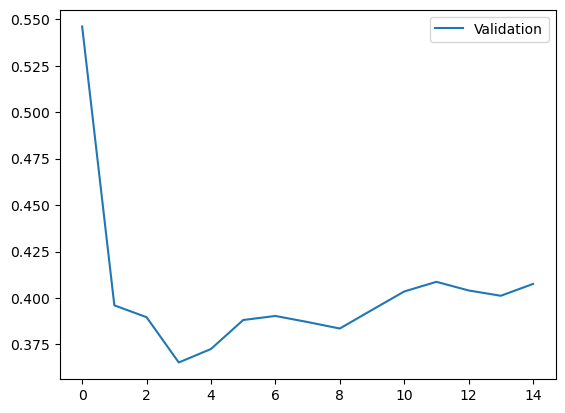

Minimum validation ECM: 0.365
Index of best parameter: 3


In [22]:
# Getting the average test scores
knn_s_test_scores = abs(knn_s_grid.cv_results_['mean_test_score'])
knn_s_param_values = knn_s_grid.param_grid['knn__n_neighbors']

# Plotting the test scores
plt.plot(knn_s_test_scores, label='Validation')
plt.legend(loc='best')
plt.show()

# Printing the minimum validation ECM and the index of the best parameter
print('Minimum validation ECM:', round(min(knn_s_test_scores),3))
print('Index of best parameter:', np.argmin(knn_s_test_scores))

In [23]:
# Best parameter
knn_s_best_param = knn_s_grid.best_params_
print(knn_s_best_param)

# Get the best model from the grid search
knn_s_best_model = knn_s_grid.best_estimator_

# Predict on the test data using the best parameters
knn_y_s_pred = knn_s_best_model.predict(X_sknn_test)
knn_y_s_pred_proba = knn_s_best_model.predict_proba(X_sknn_test)[:, 1]

{'knn__n_neighbors': 7, 'knn__p': 2, 'knn__weights': 'distance'}


In [24]:
# Calculate the custom scorer for different threshold values
thresholds = np.arange(0.0, 1.0, 0.00001)
scores = []
for threshold in thresholds:
    preds = (knn_y_s_pred_proba >= threshold).astype(int)
    score = ECM(y_sknn_test.values.ravel(), preds)
    scores.append(score)

# Find the threshold that gives the best score
knn_s_best_threshold = thresholds[np.argmin(scores)]
print("Best threshold:", knn_s_best_threshold)

# Adjusting predictions based on optimal threshold
knn_y_s_pred = knn_y_s_pred_proba >= knn_s_best_threshold

# Calculating the various performance metrics
knn_s_roc_auc = roc_auc_score(y_sknn_test.values.ravel(), knn_y_s_pred_proba)
knn_s_tn, knn_s_fp, knn_s_fn, knn_s_tp = confusion_matrix(y_sknn_test.values.ravel(), knn_y_s_pred).ravel()
knn_s_sensitivity = knn_s_tp / (knn_s_tp + knn_s_fn)
knn_s_specificity = knn_s_tn / (knn_s_tn + knn_s_fp)
knn_s_accuracy = accuracy_score(y_sknn_test.values.ravel(),knn_y_s_pred)
knn_s_f1 = f1_score(y_sknn_test.values.ravel(), knn_y_s_pred)
knn_s_ecm_score = ECM(y_sknn_test.values.ravel(),knn_y_s_pred)

# Printing the performance metrics
print("ROC AUC Score: {:.3f}".format(knn_s_roc_auc))
print("Accuracy Score: {:.3f}".format(knn_s_accuracy))
print("Specificity Score: {:.3f}".format(knn_s_specificity))
print("Sensitivity Score: {:.3f}".format(knn_s_sensitivity))
print("F1 Score: {:.3f}".format(knn_s_f1))
print("ECM: {:.3f}".format(knn_s_ecm_score))

Best threshold: 0.29023000000000004
ROC AUC Score: 0.608
Accuracy Score: 0.745
Specificity Score: 0.748
Sensitivity Score: 0.560
F1 Score: 0.070
ECM: 0.529


In [36]:
### Start timer
start_time = time.time()

# Fit model on data
knn_s_best_model.fit(X_sknn_train, y_sknn_train)

# End timer
end_time = time.time()

# Calculate time taken to fit model
time_taken = end_time - start_time

# Print time taken
print(f"Time taken to fit SAPSO KNN: {time_taken:.5f} seconds")

Time taken to fit SAPSO KNN: 0.07626 seconds


## PSO Performance

In [26]:
# Importing the PSO data
pso = pd.read_csv('knn_pso_data.csv')

# Defining X and y
y_pknn = pd.Series(data=pso['Target'])
X_pknn = pso.drop(columns=['Target'])

# Splitting the data
X_pknn_train, X_pknn_test, y_pknn_train, y_pknn_test = train_test_split(X_pknn, y_pknn, test_size=0.3, stratify=y_pknn,random_state=42)

# Numerical columns - PSO
num_cols_p = list(X_pknn_train.select_dtypes(include=['float']).columns)
# Non numerical columns - PSO
non_num_cols_p = list(X_pknn_train.select_dtypes(exclude=['float']).columns)

In [27]:
# Preprocessor
knn_p_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols_p),
        ('non_num', 'passthrough', non_num_cols_p)
    ])

# Pipeline steps
knn_p_pteps = [
    ("prep", knn_p_preprocessor),
    ("over", SMOTE(random_state=42)), 
    ("knn", KNeighborsClassifier())
]

# Pipeline
knn_p_pipeline = Pipeline(knn_p_pteps)

# Set up the grid search parameters
knn_p_parameters = {'knn__n_neighbors': np.arange(1, 30, 2),
                    'knn__p': [2],
                   'knn__weights':['distance']}

# Setting up the GridSearch with CV
knn_p_grid = GridSearchCV(knn_p_pipeline, knn_p_parameters, cv=kf, verbose = 10, scoring=knn_scoring)

# Fit the grid search object to the training data
knn_p_grid.fit(X_pknn_train, y_pknn_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5; 1/15] START knn__n_neighbors=1, knn__p=2, knn__weights=distance........
[CV 1/5; 1/15] END knn__n_neighbors=1, knn__p=2, knn__weights=distance;, score=-0.480 total time=   1.1s
[CV 2/5; 1/15] START knn__n_neighbors=1, knn__p=2, knn__weights=distance........
[CV 2/5; 1/15] END knn__n_neighbors=1, knn__p=2, knn__weights=distance;, score=-0.562 total time=   1.1s
[CV 3/5; 1/15] START knn__n_neighbors=1, knn__p=2, knn__weights=distance........
[CV 3/5; 1/15] END knn__n_neighbors=1, knn__p=2, knn__weights=distance;, score=-0.526 total time=   1.1s
[CV 4/5; 1/15] START knn__n_neighbors=1, knn__p=2, knn__weights=distance........
[CV 4/5; 1/15] END knn__n_neighbors=1, knn__p=2, knn__weights=distance;, score=-0.624 total time=   1.1s
[CV 5/5; 1/15] START knn__n_neighbors=1, knn__p=2, knn__weights=distance........
[CV 5/5; 1/15] END knn__n_neighbors=1, knn__p=2, knn__weights=distance;, score=-0.462 total time=   1.1s
[CV 1/5; 

[CV 5/5; 9/15] END knn__n_neighbors=17, knn__p=2, knn__weights=distance;, score=-0.491 total time=   1.1s
[CV 1/5; 10/15] START knn__n_neighbors=19, knn__p=2, knn__weights=distance......
[CV 1/5; 10/15] END knn__n_neighbors=19, knn__p=2, knn__weights=distance;, score=-0.366 total time=   1.1s
[CV 2/5; 10/15] START knn__n_neighbors=19, knn__p=2, knn__weights=distance......
[CV 2/5; 10/15] END knn__n_neighbors=19, knn__p=2, knn__weights=distance;, score=-0.439 total time=   1.2s
[CV 3/5; 10/15] START knn__n_neighbors=19, knn__p=2, knn__weights=distance......
[CV 3/5; 10/15] END knn__n_neighbors=19, knn__p=2, knn__weights=distance;, score=-0.450 total time=   1.1s
[CV 4/5; 10/15] START knn__n_neighbors=19, knn__p=2, knn__weights=distance......
[CV 4/5; 10/15] END knn__n_neighbors=19, knn__p=2, knn__weights=distance;, score=-0.512 total time=   1.2s
[CV 5/5; 10/15] START knn__n_neighbors=19, knn__p=2, knn__weights=distance......
[CV 5/5; 10/15] END knn__n_neighbors=19, knn__p=2, knn__weigh

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=25, shuffle=True),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Zscore',
                                                                          'DfF',
                                                                          'FAtTT',
                                                                          '4GSGR',
                                                                          'HPRiVP',
                                                                          'ItS',
                                                                          'ROAtTA',
                                                                          'StTA',
                                           

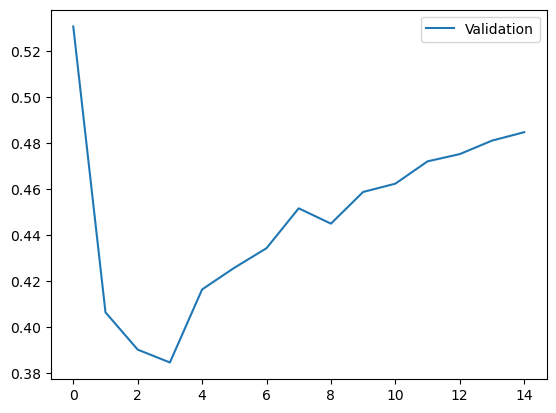

Minimum validation ECM: 0.385
Index of best parameter: 3


In [28]:
# Getting the average test scores
knn_p_test_scores = abs(knn_p_grid.cv_results_['mean_test_score'])
knn_p_param_values = knn_p_grid.param_grid['knn__n_neighbors']

# Plotting the test scores
plt.plot(knn_p_test_scores, label='Validation')
plt.legend(loc='best')
plt.show()

# Printing the minimum validation ECM and the index of the best parameter
print('Minimum validation ECM:', round(min(knn_p_test_scores),3))
print('Index of best parameter:', np.argmin(knn_p_test_scores))

In [29]:
# Best parameter
knn_p_best_param = knn_p_grid.best_params_
print(knn_p_best_param)

# Get the best model from the grid search
knn_p_best_model = knn_p_grid.best_estimator_

# Predict on the test data using the best parameters
knn_y_p_pred = knn_p_best_model.predict(X_pknn_test)
knn_y_p_pred_proba = knn_p_best_model.predict_proba(X_pknn_test)[:, 1]

{'knn__n_neighbors': 7, 'knn__p': 2, 'knn__weights': 'distance'}


In [30]:
# Calculate the custom scorer for different threshold values
thresholds = np.arange(0.0, 1.0, 0.000001)
scores = []
for threshold in thresholds:
    preds = (knn_y_p_pred_proba >= threshold).astype(int)
    score = ECM(y_pknn_test.values.ravel(), preds)
    scores.append(score)

# Find the threshold that gives the best score
knn_p_best_threshold = thresholds[np.argmin(scores)]
print("Best threshold:", knn_p_best_threshold)

# Adjusting predictions based on optimal threshold
knn_y_p_pred = knn_y_p_pred_proba >= knn_p_best_threshold

# Calculating the various performance metrics
knn_p_roc_auc = roc_auc_score(y_pknn_test.values.ravel(), knn_y_p_pred_proba)
knn_p_tn, knn_p_fp, knn_p_fn, knn_p_tp = confusion_matrix(y_pknn_test.values.ravel(), knn_y_p_pred).ravel()
knn_p_sensitivity = knn_p_tp / (knn_p_tp + knn_p_fn)
knn_p_specificity = knn_p_tn / (knn_p_tn + knn_p_fp)
knn_p_accuracy = accuracy_score(y_pknn_test.values.ravel(),knn_y_p_pred)
knn_p_f1 = f1_score(y_pknn_test.values.ravel(), knn_y_p_pred)
knn_p_ecm_score = ECM(y_pknn_test.values.ravel(),knn_y_p_pred)

# Printing the performance metrics
print("ROC AUC Score: {:.3f}".format(knn_p_roc_auc))
print("Accuracy Score: {:.3f}".format(knn_p_accuracy))
print("Specificity Score: {:.3f}".format(knn_p_specificity))
print("Sensitivity Score: {:.3f}".format(knn_p_sensitivity))
print("F1 Score: {:.3f}".format(knn_p_f1))
print("ECM: {:.3f}".format(knn_p_ecm_score))

Best threshold: 0.8402489999999999
ROC AUC Score: 0.582
Accuracy Score: 0.896
Specificity Score: 0.907
Sensitivity Score: 0.280
F1 Score: 0.084
ECM: 0.557


In [31]:
# Start timer
start_time = time.time()

# Fit model on data
knn_p_best_model.fit(X_pknn_train, y_pknn_train)

# End timer
end_time = time.time()

# Calculate time taken to fit model
time_taken = end_time - start_time

# Print time taken
print(f"Time taken to fit PSO KNN: {time_taken:.5f} seconds")

Time taken to fit PSO KNN: 0.07096 seconds


# Light GBM

## Baseline Performance

In [117]:
# Pipeline steps
lgbm_b_steps = [
    ("over", SMOTE(random_state=42)), 
    ("gb", ltb.LGBMClassifier(random_state=42, n_jobs=-1)), 
]

# Pipeline
lgbm_b_pipeline = Pipeline(lgbm_b_steps)

# Set up the grid search parameters
lgbm_b_parameters = {'gb__num_leaves': [19, 77, 307, 1229],
                    'gb__max_depth': np.arange(5, 12, 2),
                    'gb__learning_rate': [0.05, 0.1],
                     'gb__min_child_samples': [20, 50, 75, 100],
                    'gb__reg_lambda': [5, 10]}

# Setting up the GridSearch with CV
lgbm_b_grid = GridSearchCV(lgbm_b_pipeline, lgbm_b_parameters, cv=kf, verbose = 10, scoring=lgbm_scoring)

# Fit the grid search object to the training data
lgbm_b_grid.fit(X_b_train, y_b_train)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
[CV 1/5; 1/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5
[CV 1/5; 1/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.531 total time=   1.9s
[CV 2/5; 1/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5
[CV 2/5; 1/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.480 total time=   1.9s
[CV 3/5; 1/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5
[CV 3/5; 1/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.410 total time=   1.7s
[CV 4/5; 1/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, g

[CV 5/5; 6/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.661 total time=   1.8s
[CV 1/5; 7/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=5
[CV 1/5; 7/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.537 total time=   1.9s
[CV 2/5; 7/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=5
[CV 2/5; 7/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.478 total time=   2.0s
[CV 3/5; 7/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=5
[CV 3/5; 7/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.429 to

[CV 4/5; 12/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.517 total time=   1.4s
[CV 5/5; 12/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10
[CV 5/5; 12/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.633 total time=   1.5s
[CV 1/5; 13/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=5
[CV 1/5; 13/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.555 total time=   2.1s
[CV 2/5; 13/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=5
[CV 2/5; 13/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.481 to

[CV 3/5; 18/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.441 total time=   1.6s
[CV 4/5; 18/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 4/5; 18/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.567 total time=   1.4s
[CV 5/5; 18/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 5/5; 18/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.686 total time=   1.4s
[CV 1/5; 19/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=5
[CV 1/5; 19/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.562 tota

[CV 2/5; 24/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.522 total time=   1.6s
[CV 3/5; 24/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10
[CV 3/5; 24/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.438 total time=   1.8s
[CV 4/5; 24/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10
[CV 4/5; 24/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.567 total time=   1.7s
[CV 5/5; 24/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10
[CV 5/5; 24/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, s

[CV 1/5; 30/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.590 total time=   1.4s
[CV 2/5; 30/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10
[CV 2/5; 30/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.480 total time=   1.5s
[CV 3/5; 30/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10
[CV 3/5; 30/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.436 total time=   1.6s
[CV 4/5; 30/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10
[CV 4/5; 30/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10;, s

[CV 5/5; 35/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.595 total time=   2.2s
[CV 1/5; 36/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10
[CV 1/5; 36/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.468 total time=   2.0s
[CV 2/5; 36/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10
[CV 2/5; 36/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.440 total time=   1.9s
[CV 3/5; 36/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10
[CV 3/5; 36/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.463 tot

[CV 4/5; 41/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.558 total time=   1.9s
[CV 5/5; 41/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5
[CV 5/5; 41/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.586 total time=   2.0s
[CV 1/5; 42/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=10
[CV 1/5; 42/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.512 total time=   2.1s
[CV 2/5; 42/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=10
[CV 2/5; 42/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.436 total

[CV 3/5; 47/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.452 total time=   1.7s
[CV 4/5; 47/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5
[CV 4/5; 47/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.541 total time=   1.7s
[CV 5/5; 47/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5
[CV 5/5; 47/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.577 total time=   1.6s
[CV 1/5; 48/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=10
[CV 1/5; 48/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=10;, score=

[CV 2/5; 53/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.433 total time=   1.6s
[CV 3/5; 53/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5
[CV 3/5; 53/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.459 total time=   1.5s
[CV 4/5; 53/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5
[CV 4/5; 53/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.532 total time=   1.6s
[CV 5/5; 53/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5
[CV 5/5; 53/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.580 to

[CV 1/5; 59/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.512 total time=   1.6s
[CV 2/5; 59/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5
[CV 2/5; 59/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.447 total time=   1.7s
[CV 3/5; 59/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5
[CV 3/5; 59/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.418 total time=   1.5s
[CV 4/5; 59/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5
[CV 4/5; 59/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.502 to

[CV 5/5; 64/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.635 total time=   1.7s
[CV 1/5; 65/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5
[CV 1/5; 65/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.481 total time=   1.8s
[CV 2/5; 65/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5
[CV 2/5; 65/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.462 total time=   1.8s
[CV 3/5; 65/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5
[CV 3/5; 65/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.474 total

[CV 4/5; 70/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.486 total time=   2.0s
[CV 5/5; 70/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10
[CV 5/5; 70/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.634 total time=   1.9s
[CV 1/5; 71/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=5
[CV 1/5; 71/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.482 total time=   2.0s
[CV 2/5; 71/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=5
[CV 2/5; 71/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0

[CV 3/5; 76/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.469 total time=   2.0s
[CV 4/5; 76/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10
[CV 4/5; 76/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.519 total time=   1.8s
[CV 5/5; 76/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10
[CV 5/5; 76/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.607 total time=   1.9s
[CV 1/5; 77/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=5
[CV 1/5; 77/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.469 to

[CV 2/5; 82/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.424 total time=   1.6s
[CV 3/5; 82/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 3/5; 82/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.475 total time=   1.8s
[CV 4/5; 82/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 4/5; 82/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.508 total time=   1.6s
[CV 5/5; 82/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 5/5; 82/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.604 to

[CV 1/5; 88/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.522 total time=   1.3s
[CV 2/5; 88/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10
[CV 2/5; 88/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.455 total time=   1.8s
[CV 3/5; 88/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10
[CV 3/5; 88/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.483 total time=   1.7s
[CV 4/5; 88/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10
[CV 4/5; 88/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, s

[CV 5/5; 93/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.584 total time=   1.4s
[CV 1/5; 94/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10
[CV 1/5; 94/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.527 total time=   2.1s
[CV 2/5; 94/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10
[CV 2/5; 94/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.444 total time=   2.0s
[CV 3/5; 94/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10
[CV 3/5; 94/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10;, sc

[CV 4/5; 99/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.488 total time=   2.5s
[CV 5/5; 99/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5
[CV 5/5; 99/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.593 total time=  11.2s
[CV 1/5; 100/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10
[CV 1/5; 100/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.512 total time=   2.4s
[CV 2/5; 100/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10
[CV 2/5; 100/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10;, score=-

[CV 3/5; 105/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.428 total time=   1.8s
[CV 4/5; 105/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5
[CV 4/5; 105/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.537 total time=   1.9s
[CV 5/5; 105/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5
[CV 5/5; 105/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.566 total time=   1.8s
[CV 1/5; 106/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=10
[CV 1/5; 106/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=10;, score=

[CV 2/5; 111/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.498 total time=   2.1s
[CV 3/5; 111/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5
[CV 3/5; 111/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.488 total time=   2.2s
[CV 4/5; 111/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5
[CV 4/5; 111/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.511 total time=   2.1s
[CV 5/5; 111/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5
[CV 5/5; 111/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambd

[CV 1/5; 117/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.542 total time=   2.0s
[CV 2/5; 117/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5
[CV 2/5; 117/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.461 total time=   1.9s
[CV 3/5; 117/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5
[CV 3/5; 117/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.459 total time=   2.0s
[CV 4/5; 117/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5
[CV 4/5; 117/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, s

[CV 5/5; 122/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.614 total time=   1.6s
[CV 1/5; 123/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5
[CV 1/5; 123/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.508 total time=   1.8s
[CV 2/5; 123/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5
[CV 2/5; 123/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.482 total time=   1.8s
[CV 3/5; 123/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5
[CV 3/5; 123/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5;, 

[CV 3/5; 128/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.481 total time=   2.6s
[CV 4/5; 128/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10
[CV 4/5; 128/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.491 total time=   1.8s
[CV 5/5; 128/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10
[CV 5/5; 128/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.596 total time=   1.8s
[CV 1/5; 129/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5
[CV 1/5; 129/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lam

[CV 2/5; 134/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.405 total time=   1.7s
[CV 3/5; 134/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10
[CV 3/5; 134/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.454 total time=   2.0s
[CV 4/5; 134/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10
[CV 4/5; 134/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.489 total time=  10.2s
[CV 5/5; 134/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10
[CV 5/5; 134/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0

[CV 1/5; 140/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.506 total time=   2.1s
[CV 2/5; 140/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10
[CV 2/5; 140/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.418 total time=   2.3s
[CV 3/5; 140/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10
[CV 3/5; 140/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.420 total time=   2.1s
[CV 4/5; 140/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10
[CV 4/5; 140/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.476 to

[CV 5/5; 145/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.552 total time=   1.7s
[CV 1/5; 146/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 1/5; 146/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.495 total time=   1.6s
[CV 2/5; 146/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 2/5; 146/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.428 total time=   1.8s
[CV 3/5; 146/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 3/5; 146/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.432 tot

[CV 4/5; 151/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.517 total time=   2.0s
[CV 5/5; 151/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5
[CV 5/5; 151/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.545 total time=   1.9s
[CV 1/5; 152/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10
[CV 1/5; 152/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.522 total time=   2.2s
[CV 2/5; 152/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10
[CV 2/5; 152/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, scor

[CV 3/5; 157/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.440 total time=   1.5s
[CV 4/5; 157/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5
[CV 4/5; 157/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.526 total time=   1.6s
[CV 5/5; 157/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5
[CV 5/5; 157/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.548 total time=   1.6s
[CV 1/5; 158/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10
[CV 1/5; 158/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10;, score=

[CV 2/5; 163/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.437 total time=   2.0s
[CV 3/5; 163/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5
[CV 3/5; 163/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.487 total time=   2.0s
[CV 4/5; 163/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5
[CV 4/5; 163/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.508 total time=   2.0s
[CV 5/5; 163/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5
[CV 5/5; 163/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.560 total tim

[CV 1/5; 169/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.487 total time=   1.6s
[CV 2/5; 169/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5
[CV 2/5; 169/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.439 total time=   1.7s
[CV 3/5; 169/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5
[CV 3/5; 169/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.427 total time=   1.7s
[CV 4/5; 169/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5
[CV 4/5; 169/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.514 total tim

[CV 5/5; 174/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.573 total time=   1.7s
[CV 1/5; 175/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5
[CV 1/5; 175/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.500 total time=   1.8s
[CV 2/5; 175/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5
[CV 2/5; 175/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.415 total time=   2.0s
[CV 3/5; 175/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5
[CV 3/5; 175/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0

[CV 4/5; 180/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.497 total time=   1.6s
[CV 5/5; 180/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=10
[CV 5/5; 180/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.551 total time=   1.5s
[CV 1/5; 181/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5
[CV 1/5; 181/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.495 total time=   1.5s
[CV 2/5; 181/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5
[CV 2/5; 181/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.397 to

[CV 3/5; 186/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.413 total time=   1.8s
[CV 4/5; 186/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10
[CV 4/5; 186/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.482 total time=   1.7s
[CV 5/5; 186/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10
[CV 5/5; 186/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.539 total time=   1.5s
[CV 1/5; 187/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5
[CV 1/5; 187/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.5

[CV 2/5; 192/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.386 total time=   1.5s
[CV 3/5; 192/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10
[CV 3/5; 192/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.467 total time=   1.6s
[CV 4/5; 192/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10
[CV 4/5; 192/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.521 total time=   1.6s
[CV 5/5; 192/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10
[CV 5/5; 192/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda

[CV 1/5; 198/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.536 total time=   1.4s
[CV 2/5; 198/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10
[CV 2/5; 198/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.452 total time=   1.5s
[CV 3/5; 198/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10
[CV 3/5; 198/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.463 total time=   1.7s
[CV 4/5; 198/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10
[CV 4/5; 198/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0

[CV 5/5; 203/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.546 total time=   1.4s
[CV 1/5; 204/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10
[CV 1/5; 204/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.469 total time=   1.4s
[CV 2/5; 204/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10
[CV 2/5; 204/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.387 total time=   1.4s
[CV 3/5; 204/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10
[CV 3/5; 204/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.427 tot

[CV 4/5; 209/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.517 total time=   1.9s
[CV 5/5; 209/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=5
[CV 5/5; 209/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.530 total time=   1.9s
[CV 1/5; 210/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 1/5; 210/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.518 total time=   2.0s
[CV 2/5; 210/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 2/5; 210/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.409 total

[CV 3/5; 215/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.412 total time=   1.9s
[CV 4/5; 215/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5
[CV 4/5; 215/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.514 total time=   1.9s
[CV 5/5; 215/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5
[CV 5/5; 215/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.551 total time=   1.7s
[CV 1/5; 216/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10
[CV 1/5; 216/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, score=

[CV 2/5; 221/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.434 total time=   2.1s
[CV 3/5; 221/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5
[CV 3/5; 221/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.409 total time=   1.8s
[CV 4/5; 221/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5
[CV 4/5; 221/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.514 total time=   1.9s
[CV 5/5; 221/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5
[CV 5/5; 221/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5;, score=-0

[CV 1/5; 227/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.506 total time=   2.8s
[CV 2/5; 227/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5
[CV 2/5; 227/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.428 total time=   3.0s
[CV 3/5; 227/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5
[CV 3/5; 227/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.449 total time=   3.2s
[CV 4/5; 227/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5
[CV 4/5; 227/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.482 to

[CV 5/5; 232/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.571 total time=   2.6s
[CV 1/5; 233/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5
[CV 1/5; 233/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.498 total time=   1.8s
[CV 2/5; 233/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5
[CV 2/5; 233/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.468 total time=   2.0s
[CV 3/5; 233/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5
[CV 3/5; 233/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.427

[CV 4/5; 238/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.524 total time=   2.0s
[CV 5/5; 238/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=10
[CV 5/5; 238/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.566 total time=   2.4s
[CV 1/5; 239/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5
[CV 1/5; 239/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.534 total time=   2.4s
[CV 2/5; 239/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5
[CV 2/5; 239/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5;, s

[CV 3/5; 244/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.431 total time=   2.0s
[CV 4/5; 244/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=10
[CV 4/5; 244/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.510 total time=   2.2s
[CV 5/5; 244/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=10
[CV 5/5; 244/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.564 total time=   1.8s
[CV 1/5; 245/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5
[CV 1/5; 245/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0

[CV 2/5; 250/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.450 total time=   1.7s
[CV 3/5; 250/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10
[CV 3/5; 250/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.444 total time=   1.9s
[CV 4/5; 250/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10
[CV 4/5; 250/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.457 total time=   2.0s
[CV 5/5; 250/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10
[CV 5/5; 250/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10;, s

[CV 1/5; 256/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.504 total time=   2.5s
[CV 2/5; 256/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10
[CV 2/5; 256/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.444 total time=   2.2s
[CV 3/5; 256/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10
[CV 3/5; 256/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.449 total time=   3.9s
[CV 4/5; 256/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10
[CV 4/5; 256/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=25, shuffle=True),
             estimator=Pipeline(steps=[('over', SMOTE(random_state=42)),
                                       ('gb',
                                        LGBMClassifier(random_state=42))]),
             param_grid={'gb__learning_rate': [0.05, 0.1],
                         'gb__max_depth': array([ 5,  7,  9, 11]),
                         'gb__min_child_samples': [20, 50, 75, 100],
                         'gb__num_leaves': [19, 77, 307, 1229],
                         'gb__reg_lambda': [5, 10]},
             scoring=make_scorer(LGBM_ECM, greater_is_better=False, needs_proba=True),
             verbose=10)

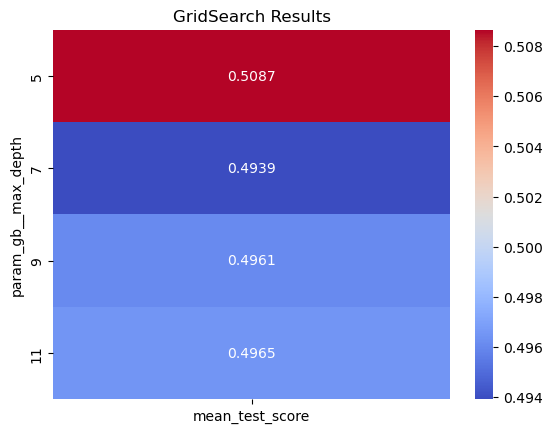

Minimum validation ECM: 0.459


In [118]:
# Getting the average test scores
lgbm_b_results = pd.DataFrame(lgbm_b_grid.cv_results_)
lgbm_b_results['mean_test_score'] = abs(lgbm_b_results['mean_test_score'])

# Plotting the test scores
lgbm_b_heatmap_data = pd.pivot_table(data=lgbm_b_results, values='mean_test_score', index='param_gb__max_depth')
sns.heatmap(lgbm_b_heatmap_data, annot=True, fmt='.4g', cmap='coolwarm')
plt.title('GridSearch Results')
plt.show()

# Printing the minimum validation ECM and the index of the best parameter
print('Minimum validation ECM:', round(min(lgbm_b_results['mean_test_score']),3))

In [119]:
# Best parameter
lgbm_b_best_param = lgbm_b_grid.best_params_
print(lgbm_b_best_param)

# Get the best model from the grid search
lgbm_b_best_model = lgbm_b_grid.best_estimator_

# Predict on the test data using the best parameters
lgbm_y_b_pred = lgbm_b_best_model.predict(X_b_test)
lgbm_y_b_pred_proba = lgbm_b_best_model.predict_proba(X_b_test)[:, 1]

{'gb__learning_rate': 0.1, 'gb__max_depth': 5, 'gb__min_child_samples': 100, 'gb__num_leaves': 19, 'gb__reg_lambda': 10}


In [120]:
# Calculate the custom scorer for different threshold values
thresholds = np.arange(0.0, 0.15, 0.000001)
scores = []
for threshold in thresholds:
    preds = (lgbm_y_b_pred_proba >= threshold).astype(int)
    score = ECM(y_b_test.values.ravel(), preds)
    scores.append(score)

# Find the threshold that gives the best score
lgbm_b_best_threshold = thresholds[np.argmin(scores)]
print("Best threshold:", lgbm_b_best_threshold)

# Adjusting predictions based on optimal threshold
lgbm_y_b_pred = lgbm_y_b_pred_proba >= lgbm_b_best_threshold

# Calculating the various performance metrics
lgbm_b_roc_auc = roc_auc_score(y_b_test.values.ravel(), lgbm_y_b_pred_proba)
lgbm_b_tn, lgbm_b_fp, lgbm_b_fn, lgbm_b_tp = confusion_matrix(y_b_test.values.ravel(), lgbm_y_b_pred).ravel()
lgbm_b_sensitivity = lgbm_b_tp / (lgbm_b_tp + lgbm_b_fn)
lgbm_b_specificity = lgbm_b_tn / (lgbm_b_tn + lgbm_b_fp)
lgbm_b_accuracy = accuracy_score(y_b_test.values.ravel(),lgbm_y_b_pred)
lgbm_b_f1 = f1_score(y_b_test.values.ravel(), lgbm_y_b_pred)
lgbm_b_ecm_score = ECM(y_b_test.values.ravel(),lgbm_y_b_pred)

# Printing the performance metrics
print("ROC AUC Score: {:.3f}".format(lgbm_b_roc_auc))
print("Accuracy Score: {:.3f}".format(lgbm_b_accuracy))
print("Specificity Score: {:.3f}".format(lgbm_b_specificity))
print("Sensitivity Score: {:.3f}".format(lgbm_b_sensitivity))
print("F1 Score: {:.3f}".format(lgbm_b_f1))
print("ECM: {:.3f}".format(lgbm_b_ecm_score))

Best threshold: 0.04149
ROC AUC Score: 0.754
Accuracy Score: 0.840
Specificity Score: 0.846
Sensitivity Score: 0.520
F1 Score: 0.100
ECM: 0.460


In [215]:
# Start timer
start_time = time.time()

# Fit model on data
lgbm_b_best_model.fit(X_b_train, y_b_train)

# End timer
end_time = time.time()

# Calculate time taken to fit model
time_taken = end_time - start_time

# Print time taken
print(f"Time taken to fit baseline LGBM: {time_taken:.5f} seconds")

Time taken to fit baseline LGBM: 0.28319 seconds


## MD&A Performance

In [121]:
# Pipeline steps
lgbm_m_steps = [
    ("over", SMOTE(random_state=42)), 
    ("gb", ltb.LGBMClassifier(random_state=42, n_jobs=-1)), 
]

# Pipeline
lgbm_m_pipeline = Pipeline(lgbm_m_steps)

# Set up the grid search parameters
lgbm_m_parameters = {'gb__num_leaves': [19, 77, 307, 1229],
                    'gb__max_depth': np.arange(5, 12, 2),
                    'gb__learning_rate': [0.05, 0.1],
                     'gb__min_child_samples': [20, 50, 75, 100],
                    'gb__reg_lambda': [5, 10]}

# Setting up the GridSearch with CV
lgbm_m_grid = GridSearchCV(lgbm_m_pipeline, lgbm_m_parameters, cv=kf, verbose = 10, scoring=lgbm_scoring)

# Fit the grid search object to the training data
lgbm_m_grid.fit(X_m_train, y_m_train)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
[CV 1/5; 1/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5
[CV 1/5; 1/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.558 total time=   1.8s
[CV 2/5; 1/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5
[CV 2/5; 1/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.487 total time=   2.1s
[CV 3/5; 1/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5
[CV 3/5; 1/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.503 total time=   2.0s
[CV 4/5; 1/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, g

[CV 5/5; 6/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.576 total time=   1.6s
[CV 1/5; 7/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=5
[CV 1/5; 7/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.544 total time=   1.6s
[CV 2/5; 7/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=5
[CV 2/5; 7/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.469 total time=   1.6s
[CV 3/5; 7/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=5
[CV 3/5; 7/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.528 to

[CV 4/5; 12/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.468 total time=   1.4s
[CV 5/5; 12/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10
[CV 5/5; 12/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.581 total time=   1.4s
[CV 1/5; 13/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=5
[CV 1/5; 13/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.586 total time=   1.4s
[CV 2/5; 13/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=5
[CV 2/5; 13/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.480 to

[CV 3/5; 18/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.494 total time=   1.7s
[CV 4/5; 18/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 4/5; 18/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.488 total time=   1.3s
[CV 5/5; 18/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 5/5; 18/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.502 total time=   1.3s
[CV 1/5; 19/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=5
[CV 1/5; 19/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.586 tota

[CV 2/5; 24/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.531 total time=   1.4s
[CV 3/5; 24/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10
[CV 3/5; 24/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.479 total time=   1.4s
[CV 4/5; 24/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10
[CV 4/5; 24/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.477 total time=   1.5s
[CV 5/5; 24/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10
[CV 5/5; 24/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, s

[CV 1/5; 30/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.541 total time=   1.6s
[CV 2/5; 30/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10
[CV 2/5; 30/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.499 total time=   1.5s
[CV 3/5; 30/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10
[CV 3/5; 30/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.522 total time=   1.7s
[CV 4/5; 30/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10
[CV 4/5; 30/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10;, s

[CV 5/5; 35/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.536 total time=   1.7s
[CV 1/5; 36/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10
[CV 1/5; 36/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.507 total time=   1.6s
[CV 2/5; 36/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10
[CV 2/5; 36/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.477 total time=   1.8s
[CV 3/5; 36/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10
[CV 3/5; 36/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.478 tot

[CV 4/5; 41/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.487 total time=   1.7s
[CV 5/5; 41/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5
[CV 5/5; 41/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.530 total time=   1.6s
[CV 1/5; 42/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=10
[CV 1/5; 42/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.504 total time=   1.6s
[CV 2/5; 42/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=10
[CV 2/5; 42/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.489 total

[CV 3/5; 47/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.466 total time=   1.7s
[CV 4/5; 47/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5
[CV 4/5; 47/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.466 total time=   1.6s
[CV 5/5; 47/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5
[CV 5/5; 47/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.499 total time=   1.7s
[CV 1/5; 48/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=10
[CV 1/5; 48/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=10;, score=

[CV 2/5; 53/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.478 total time=   1.6s
[CV 3/5; 53/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5
[CV 3/5; 53/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.413 total time=   1.6s
[CV 4/5; 53/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5
[CV 4/5; 53/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.518 total time=   1.7s
[CV 5/5; 53/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5
[CV 5/5; 53/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.519 to

[CV 1/5; 59/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.524 total time=   1.5s
[CV 2/5; 59/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5
[CV 2/5; 59/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.508 total time=   1.5s
[CV 3/5; 59/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5
[CV 3/5; 59/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.440 total time=   1.6s
[CV 4/5; 59/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5
[CV 4/5; 59/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.426 to

[CV 5/5; 64/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.496 total time=   1.6s
[CV 1/5; 65/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5
[CV 1/5; 65/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.509 total time=   2.4s
[CV 2/5; 65/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5
[CV 2/5; 65/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.474 total time=   2.0s
[CV 3/5; 65/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5
[CV 3/5; 65/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.425 total

[CV 4/5; 70/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.465 total time=   1.9s
[CV 5/5; 70/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10
[CV 5/5; 70/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.516 total time=   2.2s
[CV 1/5; 71/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=5
[CV 1/5; 71/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.462 total time=   2.1s
[CV 2/5; 71/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=5
[CV 2/5; 71/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0

[CV 3/5; 76/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.475 total time=   1.6s
[CV 4/5; 76/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10
[CV 4/5; 76/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.451 total time=   1.6s
[CV 5/5; 76/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10
[CV 5/5; 76/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.513 total time=   1.9s
[CV 1/5; 77/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=5
[CV 1/5; 77/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.545 to

[CV 2/5; 82/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.493 total time=   1.5s
[CV 3/5; 82/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 3/5; 82/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.472 total time=   1.6s
[CV 4/5; 82/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 4/5; 82/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.477 total time=   1.6s
[CV 5/5; 82/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 5/5; 82/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.467 to

[CV 1/5; 88/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.522 total time=   1.5s
[CV 2/5; 88/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10
[CV 2/5; 88/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.468 total time=   1.6s
[CV 3/5; 88/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10
[CV 3/5; 88/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.472 total time=   1.5s
[CV 4/5; 88/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10
[CV 4/5; 88/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, s

[CV 5/5; 93/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.567 total time=   1.5s
[CV 1/5; 94/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10
[CV 1/5; 94/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.533 total time=   1.5s
[CV 2/5; 94/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10
[CV 2/5; 94/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.452 total time=   1.4s
[CV 3/5; 94/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10
[CV 3/5; 94/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10;, sc

[CV 4/5; 99/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.521 total time=   1.9s
[CV 5/5; 99/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5
[CV 5/5; 99/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.510 total time=   1.8s
[CV 1/5; 100/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10
[CV 1/5; 100/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.475 total time=   1.7s
[CV 2/5; 100/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10
[CV 2/5; 100/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10;, score=-

[CV 3/5; 105/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.433 total time=   1.5s
[CV 4/5; 105/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5
[CV 4/5; 105/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.452 total time=   1.5s
[CV 5/5; 105/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5
[CV 5/5; 105/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.509 total time=   1.5s
[CV 1/5; 106/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=10
[CV 1/5; 106/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=10;, score=

[CV 2/5; 111/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.480 total time=   1.8s
[CV 3/5; 111/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5
[CV 3/5; 111/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.469 total time=   1.7s
[CV 4/5; 111/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5
[CV 4/5; 111/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.489 total time=   1.8s
[CV 5/5; 111/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5
[CV 5/5; 111/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambd

[CV 1/5; 117/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.508 total time=   1.5s
[CV 2/5; 117/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5
[CV 2/5; 117/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.449 total time=   1.4s
[CV 3/5; 117/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5
[CV 3/5; 117/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.452 total time=   1.4s
[CV 4/5; 117/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5
[CV 4/5; 117/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, s

[CV 5/5; 122/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.529 total time=   1.3s
[CV 1/5; 123/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5
[CV 1/5; 123/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.518 total time=   1.4s
[CV 2/5; 123/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5
[CV 2/5; 123/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.452 total time=   1.4s
[CV 3/5; 123/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5
[CV 3/5; 123/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5;, 

[CV 3/5; 128/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.486 total time=   1.5s
[CV 4/5; 128/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10
[CV 4/5; 128/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.435 total time=   1.5s
[CV 5/5; 128/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10
[CV 5/5; 128/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.510 total time=   1.6s
[CV 1/5; 129/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5
[CV 1/5; 129/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lam

[CV 2/5; 134/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.396 total time=   1.9s
[CV 3/5; 134/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10
[CV 3/5; 134/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.456 total time=   1.9s
[CV 4/5; 134/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10
[CV 4/5; 134/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.463 total time=   1.8s
[CV 5/5; 134/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10
[CV 5/5; 134/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0

[CV 1/5; 140/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.512 total time=   1.6s
[CV 2/5; 140/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10
[CV 2/5; 140/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.409 total time=   1.5s
[CV 3/5; 140/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10
[CV 3/5; 140/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.393 total time=   1.6s
[CV 4/5; 140/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10
[CV 4/5; 140/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.473 to

[CV 5/5; 145/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.481 total time=   1.6s
[CV 1/5; 146/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 1/5; 146/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.523 total time=   1.6s
[CV 2/5; 146/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 2/5; 146/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.442 total time=   1.5s
[CV 3/5; 146/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 3/5; 146/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.404 tot

[CV 4/5; 151/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.478 total time=   1.6s
[CV 5/5; 151/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5
[CV 5/5; 151/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.479 total time=   1.6s
[CV 1/5; 152/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10
[CV 1/5; 152/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.490 total time=   1.5s
[CV 2/5; 152/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10
[CV 2/5; 152/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, scor

[CV 3/5; 157/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.437 total time=   1.5s
[CV 4/5; 157/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5
[CV 4/5; 157/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.485 total time=   1.5s
[CV 5/5; 157/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5
[CV 5/5; 157/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.457 total time=   1.6s
[CV 1/5; 158/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10
[CV 1/5; 158/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10;, score=

[CV 2/5; 163/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.417 total time=   1.7s
[CV 3/5; 163/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5
[CV 3/5; 163/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.430 total time=   2.1s
[CV 4/5; 163/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5
[CV 4/5; 163/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.480 total time=   1.9s
[CV 5/5; 163/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5
[CV 5/5; 163/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.511 total tim

[CV 1/5; 169/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.514 total time=   1.6s
[CV 2/5; 169/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5
[CV 2/5; 169/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.436 total time=   1.9s
[CV 3/5; 169/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5
[CV 3/5; 169/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.433 total time=   2.0s
[CV 4/5; 169/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5
[CV 4/5; 169/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.488 total tim

[CV 5/5; 174/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.527 total time=   1.8s
[CV 1/5; 175/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5
[CV 1/5; 175/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.522 total time=   1.7s
[CV 2/5; 175/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5
[CV 2/5; 175/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.501 total time=   1.9s
[CV 3/5; 175/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5
[CV 3/5; 175/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0

[CV 4/5; 180/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.464 total time=   2.2s
[CV 5/5; 180/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=10
[CV 5/5; 180/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.510 total time=   1.8s
[CV 1/5; 181/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5
[CV 1/5; 181/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.517 total time=   1.7s
[CV 2/5; 181/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5
[CV 2/5; 181/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.442 to

[CV 3/5; 186/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.443 total time=   1.7s
[CV 4/5; 186/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10
[CV 4/5; 186/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.373 total time=   1.6s
[CV 5/5; 186/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10
[CV 5/5; 186/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.500 total time=   1.7s
[CV 1/5; 187/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5
[CV 1/5; 187/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.4

[CV 2/5; 192/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.446 total time=   1.7s
[CV 3/5; 192/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10
[CV 3/5; 192/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.449 total time=   1.9s
[CV 4/5; 192/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10
[CV 4/5; 192/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.457 total time=   1.6s
[CV 5/5; 192/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10
[CV 5/5; 192/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda

[CV 1/5; 198/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.469 total time=   1.9s
[CV 2/5; 198/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10
[CV 2/5; 198/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.446 total time=   2.4s
[CV 3/5; 198/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10
[CV 3/5; 198/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.465 total time=   2.1s
[CV 4/5; 198/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10
[CV 4/5; 198/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0

[CV 5/5; 203/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.507 total time=   1.7s
[CV 1/5; 204/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10
[CV 1/5; 204/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.509 total time=   1.6s
[CV 2/5; 204/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10
[CV 2/5; 204/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.452 total time=   2.0s
[CV 3/5; 204/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10
[CV 3/5; 204/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.455 tot

[CV 4/5; 209/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.469 total time=   1.4s
[CV 5/5; 209/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=5
[CV 5/5; 209/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.500 total time=   1.5s
[CV 1/5; 210/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 1/5; 210/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.490 total time=   1.4s
[CV 2/5; 210/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 2/5; 210/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.406 total

[CV 3/5; 215/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.409 total time=   1.5s
[CV 4/5; 215/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5
[CV 4/5; 215/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.444 total time=   1.5s
[CV 5/5; 215/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5
[CV 5/5; 215/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.519 total time=   1.5s
[CV 1/5; 216/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10
[CV 1/5; 216/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, score=

[CV 2/5; 221/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.442 total time=   1.4s
[CV 3/5; 221/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5
[CV 3/5; 221/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.415 total time=   1.4s
[CV 4/5; 221/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5
[CV 4/5; 221/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.462 total time=   1.5s
[CV 5/5; 221/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5
[CV 5/5; 221/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5;, score=-0

[CV 1/5; 227/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.453 total time=   1.7s
[CV 2/5; 227/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5
[CV 2/5; 227/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.453 total time=   1.6s
[CV 3/5; 227/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5
[CV 3/5; 227/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.449 total time=   1.8s
[CV 4/5; 227/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5
[CV 4/5; 227/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.438 to

[CV 5/5; 232/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.504 total time=   2.1s
[CV 1/5; 233/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5
[CV 1/5; 233/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.560 total time=   1.8s
[CV 2/5; 233/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5
[CV 2/5; 233/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.412 total time=   1.4s
[CV 3/5; 233/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5
[CV 3/5; 233/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.459

[CV 4/5; 238/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.466 total time=   1.5s
[CV 5/5; 238/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=10
[CV 5/5; 238/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.513 total time=   1.6s
[CV 1/5; 239/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5
[CV 1/5; 239/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.525 total time=   1.9s
[CV 2/5; 239/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5
[CV 2/5; 239/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5;, s

[CV 3/5; 244/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.444 total time=   1.6s
[CV 4/5; 244/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=10
[CV 4/5; 244/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.427 total time=   1.4s
[CV 5/5; 244/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=10
[CV 5/5; 244/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.512 total time=   1.5s
[CV 1/5; 245/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5
[CV 1/5; 245/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0

[CV 2/5; 250/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.447 total time=   1.8s
[CV 3/5; 250/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10
[CV 3/5; 250/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.474 total time=   1.6s
[CV 4/5; 250/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10
[CV 4/5; 250/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.411 total time=   1.5s
[CV 5/5; 250/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10
[CV 5/5; 250/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10;, s

[CV 1/5; 256/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.527 total time=   1.9s
[CV 2/5; 256/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10
[CV 2/5; 256/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.477 total time=   1.6s
[CV 3/5; 256/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10
[CV 3/5; 256/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.462 total time=   1.7s
[CV 4/5; 256/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10
[CV 4/5; 256/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=25, shuffle=True),
             estimator=Pipeline(steps=[('over', SMOTE(random_state=42)),
                                       ('gb',
                                        LGBMClassifier(random_state=42))]),
             param_grid={'gb__learning_rate': [0.05, 0.1],
                         'gb__max_depth': array([ 5,  7,  9, 11]),
                         'gb__min_child_samples': [20, 50, 75, 100],
                         'gb__num_leaves': [19, 77, 307, 1229],
                         'gb__reg_lambda': [5, 10]},
             scoring=make_scorer(LGBM_ECM, greater_is_better=False, needs_proba=True),
             verbose=10)

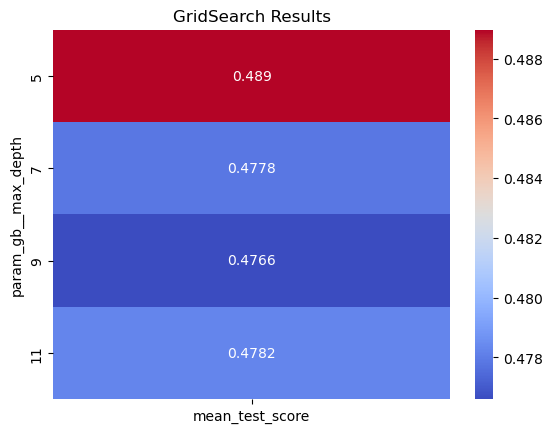

Minimum validation ECM: 0.448


In [122]:
# Getting the average test scores
lgbm_m_results = pd.DataFrame(lgbm_m_grid.cv_results_)
lgbm_m_results['mean_test_score'] = abs(lgbm_m_results['mean_test_score'])

# Plotting the test scores
lgbm_m_heatmap_data = pd.pivot_table(data=lgbm_m_results, values='mean_test_score', index='param_gb__max_depth')
sns.heatmap(lgbm_m_heatmap_data, annot=True, fmt='.4g', cmap='coolwarm')
plt.title('GridSearch Results')
plt.show()

# Printing the minimum validation ECM and the index of the best parameter
print('Minimum validation ECM:', round(min(lgbm_m_results['mean_test_score']),3))

In [123]:
# Best parameter
lgbm_m_best_param = lgbm_m_grid.best_params_
print(lgbm_m_best_param)

# Get the best model from the grid search
lgbm_m_best_model = lgbm_m_grid.best_estimator_

# Predict on the test data using the best parameters
lgbm_y_m_pred = lgbm_m_best_model.predict(X_m_test)
lgbm_y_m_pred_proba = lgbm_m_best_model.predict_proba(X_m_test)[:, 1]

{'gb__learning_rate': 0.1, 'gb__max_depth': 7, 'gb__min_child_samples': 100, 'gb__num_leaves': 19, 'gb__reg_lambda': 10}


In [124]:
# Calculate the custom scorer for different threshold values
thresholds = np.arange(0.0, 0.15, 0.000001)
scores = []
for threshold in thresholds:
    preds = (lgbm_y_m_pred_proba >= threshold).astype(int)
    score = ECM(y_m_test.values.ravel(), preds)
    scores.append(score)

# Find the threshold that gives the best score
lgbm_m_best_threshold = thresholds[np.argmin(scores)]
print("Best threshold:", lgbm_m_best_threshold)

# Adjusting predictions based on optimal threshold
lgbm_y_m_pred = lgbm_y_m_pred_proba >= lgbm_m_best_threshold

# Calculating the various performance metrics
lgbm_m_roc_auc = roc_auc_score(y_m_test.values.ravel(), lgbm_y_m_pred_proba)
lgbm_m_tn, lgbm_m_fp, lgbm_m_fn, lgbm_m_tp = confusion_matrix(y_m_test.values.ravel(), lgbm_y_m_pred).ravel()
lgbm_m_sensitivity = lgbm_m_tp / (lgbm_m_tp + lgbm_m_fn)
lgbm_m_specificity = lgbm_m_tn / (lgbm_m_tn + lgbm_m_fp)
lgbm_m_accuracy = accuracy_score(y_m_test.values.ravel(),lgbm_y_m_pred)
lgbm_m_f1 = f1_score(y_m_test.values.ravel(), lgbm_y_m_pred)
lgbm_m_ecm_score = ECM(y_m_test.values.ravel(),lgbm_y_m_pred)

# Printing the performance metrics
print("ROC AUC Score: {:.3f}".format(lgbm_m_roc_auc))
print("Accuracy Score: {:.3f}".format(lgbm_m_accuracy))
print("Specificity Score: {:.3f}".format(lgbm_m_specificity))
print("Sensitivity Score: {:.3f}".format(lgbm_m_sensitivity))
print("F1 Score: {:.3f}".format(lgbm_m_f1))
print("ECM: {:.3f}".format(lgbm_m_ecm_score))

Best threshold: 0.02727
ROC AUC Score: 0.737
Accuracy Score: 0.828
Specificity Score: 0.833
Sensitivity Score: 0.520
F1 Score: 0.094
ECM: 0.472


In [214]:
# Start timer
start_time = time.time()

# Fit model on data
lgbm_m_best_model.fit(X_m_train, y_m_train)

# End timer
end_time = time.time()

# Calculate time taken to fit model
time_taken = end_time - start_time

# Print time taken
print(f"Time taken to fit MD&A LGBM: {time_taken:.5f} seconds")

Time taken to fit MD&A LGBM: 0.45163 seconds


## ECT Performance

In [125]:
# Pipeline steps
lgbm_e_steps = [
    ("over", SMOTE(random_state=42)), 
    ("gb", ltb.LGBMClassifier(random_state=42, n_jobs=-1)), 
]

# Pipeline
lgbm_e_pipeline = Pipeline(lgbm_e_steps)

# Set up the grid search parameters
lgbm_e_parameters = {'gb__num_leaves': [19, 77, 307, 1229],
                    'gb__max_depth': np.arange(5, 12, 2),
                    'gb__learning_rate': [0.05, 0.1],
                     'gb__min_child_samples': [20, 50, 75, 100],
                    'gb__reg_lambda': [5, 10]}

# Setting up the GridSearch with CV
lgbm_e_grid = GridSearchCV(lgbm_e_pipeline, lgbm_e_parameters, cv=kf, verbose = 10, scoring=lgbm_scoring)

# Fit the grid search object to the training data
lgbm_e_grid.fit(X_e_train, y_e_train)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
[CV 1/5; 1/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5
[CV 1/5; 1/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.505 total time=   1.7s
[CV 2/5; 1/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5
[CV 2/5; 1/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.527 total time=   1.7s
[CV 3/5; 1/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5
[CV 3/5; 1/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.466 total time=   1.5s
[CV 4/5; 1/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, g

[CV 5/5; 6/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.493 total time=   1.5s
[CV 1/5; 7/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=5
[CV 1/5; 7/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.527 total time=   1.6s
[CV 2/5; 7/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=5
[CV 2/5; 7/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.524 total time=   1.7s
[CV 3/5; 7/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=5
[CV 3/5; 7/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.484 to

[CV 4/5; 12/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.531 total time=   1.6s
[CV 5/5; 12/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10
[CV 5/5; 12/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.464 total time=   1.8s
[CV 1/5; 13/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=5
[CV 1/5; 13/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.515 total time=   1.8s
[CV 2/5; 13/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=5
[CV 2/5; 13/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.530 to

[CV 3/5; 18/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.518 total time=   1.5s
[CV 4/5; 18/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 4/5; 18/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.544 total time=   1.4s
[CV 5/5; 18/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 5/5; 18/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.453 total time=   1.5s
[CV 1/5; 19/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=5
[CV 1/5; 19/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.555 tota

[CV 2/5; 24/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.543 total time=   1.7s
[CV 3/5; 24/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10
[CV 3/5; 24/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.526 total time=   1.6s
[CV 4/5; 24/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10
[CV 4/5; 24/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.536 total time=   1.4s
[CV 5/5; 24/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10
[CV 5/5; 24/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, s

[CV 1/5; 30/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.555 total time=   1.5s
[CV 2/5; 30/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10
[CV 2/5; 30/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.491 total time=   1.5s
[CV 3/5; 30/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10
[CV 3/5; 30/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.517 total time=   1.4s
[CV 4/5; 30/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10
[CV 4/5; 30/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10;, s

[CV 5/5; 35/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.513 total time=   2.0s
[CV 1/5; 36/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10
[CV 1/5; 36/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.509 total time=   1.9s
[CV 2/5; 36/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10
[CV 2/5; 36/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.482 total time=   3.3s
[CV 3/5; 36/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10
[CV 3/5; 36/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.465 tot

[CV 4/5; 41/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.526 total time=   2.3s
[CV 5/5; 41/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5
[CV 5/5; 41/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.478 total time=   2.1s
[CV 1/5; 42/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=10
[CV 1/5; 42/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.513 total time=   2.8s
[CV 2/5; 42/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=10
[CV 2/5; 42/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.534 total

[CV 3/5; 47/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.490 total time=   2.4s
[CV 4/5; 47/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5
[CV 4/5; 47/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.498 total time=   2.5s
[CV 5/5; 47/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5
[CV 5/5; 47/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.480 total time=   2.8s
[CV 1/5; 48/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=10
[CV 1/5; 48/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=10;, score=

[CV 2/5; 53/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.500 total time=   1.7s
[CV 3/5; 53/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5
[CV 3/5; 53/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.526 total time=   1.6s
[CV 4/5; 53/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5
[CV 4/5; 53/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.484 total time=   1.7s
[CV 5/5; 53/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5
[CV 5/5; 53/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.478 to

[CV 1/5; 59/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.524 total time=   1.7s
[CV 2/5; 59/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5
[CV 2/5; 59/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.462 total time=   1.6s
[CV 3/5; 59/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5
[CV 3/5; 59/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.522 total time=   1.6s
[CV 4/5; 59/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5
[CV 4/5; 59/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.446 to

[CV 5/5; 64/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.510 total time=   1.6s
[CV 1/5; 65/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5
[CV 1/5; 65/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.478 total time=   1.7s
[CV 2/5; 65/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5
[CV 2/5; 65/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.605 total time=   1.7s
[CV 3/5; 65/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5
[CV 3/5; 65/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.506 total

[CV 4/5; 70/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.519 total time=   1.9s
[CV 5/5; 70/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10
[CV 5/5; 70/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.468 total time=   2.2s
[CV 1/5; 71/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=5
[CV 1/5; 71/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.479 total time=   2.0s
[CV 2/5; 71/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=5
[CV 2/5; 71/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0

[CV 3/5; 76/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.499 total time=   1.8s
[CV 4/5; 76/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10
[CV 4/5; 76/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.514 total time=   2.0s
[CV 5/5; 76/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10
[CV 5/5; 76/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.487 total time=   2.0s
[CV 1/5; 77/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=5
[CV 1/5; 77/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.528 to

[CV 2/5; 82/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.489 total time=   1.7s
[CV 3/5; 82/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 3/5; 82/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.528 total time=   1.8s
[CV 4/5; 82/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 4/5; 82/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.477 total time=   1.6s
[CV 5/5; 82/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 5/5; 82/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.491 to

[CV 1/5; 88/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.574 total time=   1.7s
[CV 2/5; 88/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10
[CV 2/5; 88/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.481 total time=   1.9s
[CV 3/5; 88/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10
[CV 3/5; 88/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.515 total time=   1.7s
[CV 4/5; 88/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10
[CV 4/5; 88/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, s

[CV 5/5; 93/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.481 total time=   1.8s
[CV 1/5; 94/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10
[CV 1/5; 94/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.558 total time=   1.8s
[CV 2/5; 94/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10
[CV 2/5; 94/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.384 total time=   1.8s
[CV 3/5; 94/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10
[CV 3/5; 94/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10;, sc

[CV 4/5; 99/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.520 total time=   2.4s
[CV 5/5; 99/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5
[CV 5/5; 99/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.450 total time=   2.3s
[CV 1/5; 100/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10
[CV 1/5; 100/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.500 total time=   2.8s
[CV 2/5; 100/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10
[CV 2/5; 100/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10;, score=-

[CV 3/5; 105/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.500 total time=   1.8s
[CV 4/5; 105/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5
[CV 4/5; 105/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.489 total time=   1.7s
[CV 5/5; 105/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5
[CV 5/5; 105/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.483 total time=   1.8s
[CV 1/5; 106/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=10
[CV 1/5; 106/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=10;, score=

[CV 2/5; 111/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.543 total time=   2.1s
[CV 3/5; 111/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5
[CV 3/5; 111/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.485 total time=   2.1s
[CV 4/5; 111/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5
[CV 4/5; 111/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.485 total time=   2.0s
[CV 5/5; 111/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5
[CV 5/5; 111/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambd

[CV 1/5; 117/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.503 total time=   1.8s
[CV 2/5; 117/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5
[CV 2/5; 117/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.537 total time=   1.9s
[CV 3/5; 117/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5
[CV 3/5; 117/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.498 total time=   2.2s
[CV 4/5; 117/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5
[CV 4/5; 117/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, s

[CV 5/5; 122/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.500 total time=   1.9s
[CV 1/5; 123/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5
[CV 1/5; 123/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.546 total time=   1.9s
[CV 2/5; 123/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5
[CV 2/5; 123/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.509 total time=   1.6s
[CV 3/5; 123/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5
[CV 3/5; 123/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5;, 

[CV 3/5; 128/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.542 total time=   1.9s
[CV 4/5; 128/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10
[CV 4/5; 128/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.490 total time=   1.9s
[CV 5/5; 128/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10
[CV 5/5; 128/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.479 total time=   1.8s
[CV 1/5; 129/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5
[CV 1/5; 129/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lam

[CV 2/5; 134/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.464 total time=   1.8s
[CV 3/5; 134/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10
[CV 3/5; 134/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.458 total time=   1.7s
[CV 4/5; 134/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10
[CV 4/5; 134/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.481 total time=   1.7s
[CV 5/5; 134/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10
[CV 5/5; 134/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0

[CV 1/5; 140/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.522 total time=   1.8s
[CV 2/5; 140/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10
[CV 2/5; 140/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.470 total time=   1.7s
[CV 3/5; 140/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10
[CV 3/5; 140/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.470 total time=   2.0s
[CV 4/5; 140/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10
[CV 4/5; 140/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.474 to

[CV 5/5; 145/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.427 total time=   1.6s
[CV 1/5; 146/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 1/5; 146/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.531 total time=   1.7s
[CV 2/5; 146/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 2/5; 146/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.453 total time=   1.8s
[CV 3/5; 146/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 3/5; 146/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.442 tot

[CV 4/5; 151/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.469 total time=   1.4s
[CV 5/5; 151/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5
[CV 5/5; 151/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.432 total time=   2.0s
[CV 1/5; 152/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10
[CV 1/5; 152/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.533 total time=   1.4s
[CV 2/5; 152/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10
[CV 2/5; 152/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, scor

[CV 3/5; 157/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.447 total time=   1.7s
[CV 4/5; 157/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5
[CV 4/5; 157/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.485 total time=   1.6s
[CV 5/5; 157/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5
[CV 5/5; 157/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.444 total time=   1.7s
[CV 1/5; 158/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10
[CV 1/5; 158/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10;, score=

[CV 2/5; 163/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.480 total time=   2.0s
[CV 3/5; 163/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5
[CV 3/5; 163/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.430 total time=   1.9s
[CV 4/5; 163/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5
[CV 4/5; 163/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.477 total time=   2.1s
[CV 5/5; 163/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5
[CV 5/5; 163/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.469 total tim

[CV 1/5; 169/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.537 total time=   1.7s
[CV 2/5; 169/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5
[CV 2/5; 169/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.502 total time=   1.6s
[CV 3/5; 169/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5
[CV 3/5; 169/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.448 total time=   1.7s
[CV 4/5; 169/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5
[CV 4/5; 169/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.514 total tim

[CV 5/5; 174/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.434 total time=   1.8s
[CV 1/5; 175/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5
[CV 1/5; 175/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.499 total time=   1.7s
[CV 2/5; 175/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5
[CV 2/5; 175/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.465 total time=   1.6s
[CV 3/5; 175/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5
[CV 3/5; 175/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0

[CV 4/5; 180/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.500 total time=   1.9s
[CV 5/5; 180/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=10
[CV 5/5; 180/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.428 total time=   1.5s
[CV 1/5; 181/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5
[CV 1/5; 181/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.471 total time=   2.2s
[CV 2/5; 181/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5
[CV 2/5; 181/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.482 to

[CV 3/5; 186/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.463 total time=   1.8s
[CV 4/5; 186/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10
[CV 4/5; 186/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.460 total time=   1.6s
[CV 5/5; 186/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10
[CV 5/5; 186/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.443 total time=   1.6s
[CV 1/5; 187/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5
[CV 1/5; 187/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.5

[CV 2/5; 192/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.431 total time=   1.9s
[CV 3/5; 192/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10
[CV 3/5; 192/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.481 total time=   1.7s
[CV 4/5; 192/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10
[CV 4/5; 192/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.458 total time=   1.6s
[CV 5/5; 192/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10
[CV 5/5; 192/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda

[CV 1/5; 198/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.518 total time=   2.2s
[CV 2/5; 198/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10
[CV 2/5; 198/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.524 total time=   2.0s
[CV 3/5; 198/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10
[CV 3/5; 198/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.434 total time=   2.1s
[CV 4/5; 198/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10
[CV 4/5; 198/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0

[CV 5/5; 203/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.424 total time=   2.1s
[CV 1/5; 204/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10
[CV 1/5; 204/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.567 total time=   1.9s
[CV 2/5; 204/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10
[CV 2/5; 204/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.449 total time=   1.7s
[CV 3/5; 204/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10
[CV 3/5; 204/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.452 tot

[CV 4/5; 209/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.505 total time=   1.8s
[CV 5/5; 209/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=5
[CV 5/5; 209/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.430 total time=   2.8s
[CV 1/5; 210/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 1/5; 210/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.511 total time=   1.6s
[CV 2/5; 210/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 2/5; 210/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.446 total

[CV 3/5; 215/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.464 total time=   3.0s
[CV 4/5; 215/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5
[CV 4/5; 215/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.456 total time=   1.6s
[CV 5/5; 215/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5
[CV 5/5; 215/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.469 total time=   1.7s
[CV 1/5; 216/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10
[CV 1/5; 216/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, score=

[CV 2/5; 221/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.446 total time=   2.8s
[CV 3/5; 221/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5
[CV 3/5; 221/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.504 total time=   1.6s
[CV 4/5; 221/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5
[CV 4/5; 221/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.432 total time=   1.6s
[CV 5/5; 221/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5
[CV 5/5; 221/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5;, score=-0

[CV 1/5; 227/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.487 total time=   2.1s
[CV 2/5; 227/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5
[CV 2/5; 227/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.442 total time=   2.3s
[CV 3/5; 227/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5
[CV 3/5; 227/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.446 total time=   2.1s
[CV 4/5; 227/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5
[CV 4/5; 227/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.504 to

[CV 5/5; 232/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.444 total time=   2.5s
[CV 1/5; 233/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5
[CV 1/5; 233/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.527 total time=   2.0s
[CV 2/5; 233/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5
[CV 2/5; 233/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.484 total time=   1.9s
[CV 3/5; 233/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5
[CV 3/5; 233/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.460

[CV 4/5; 238/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.488 total time=   2.0s
[CV 5/5; 238/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=10
[CV 5/5; 238/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.431 total time=   2.0s
[CV 1/5; 239/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5
[CV 1/5; 239/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.561 total time=   2.2s
[CV 2/5; 239/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5
[CV 2/5; 239/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5;, s

[CV 3/5; 244/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.457 total time=   1.7s
[CV 4/5; 244/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=10
[CV 4/5; 244/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.510 total time=   1.8s
[CV 5/5; 244/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=10
[CV 5/5; 244/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.441 total time=   1.7s
[CV 1/5; 245/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5
[CV 1/5; 245/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0

[CV 2/5; 250/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.425 total time=   1.5s
[CV 3/5; 250/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10
[CV 3/5; 250/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.464 total time=   1.7s
[CV 4/5; 250/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10
[CV 4/5; 250/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.466 total time=   2.1s
[CV 5/5; 250/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10
[CV 5/5; 250/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10;, s

[CV 1/5; 256/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.572 total time=   1.7s
[CV 2/5; 256/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10
[CV 2/5; 256/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.415 total time=   1.9s
[CV 3/5; 256/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10
[CV 3/5; 256/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.466 total time=   1.9s
[CV 4/5; 256/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10
[CV 4/5; 256/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=25, shuffle=True),
             estimator=Pipeline(steps=[('over', SMOTE(random_state=42)),
                                       ('gb',
                                        LGBMClassifier(random_state=42))]),
             param_grid={'gb__learning_rate': [0.05, 0.1],
                         'gb__max_depth': array([ 5,  7,  9, 11]),
                         'gb__min_child_samples': [20, 50, 75, 100],
                         'gb__num_leaves': [19, 77, 307, 1229],
                         'gb__reg_lambda': [5, 10]},
             scoring=make_scorer(LGBM_ECM, greater_is_better=False, needs_proba=True),
             verbose=10)

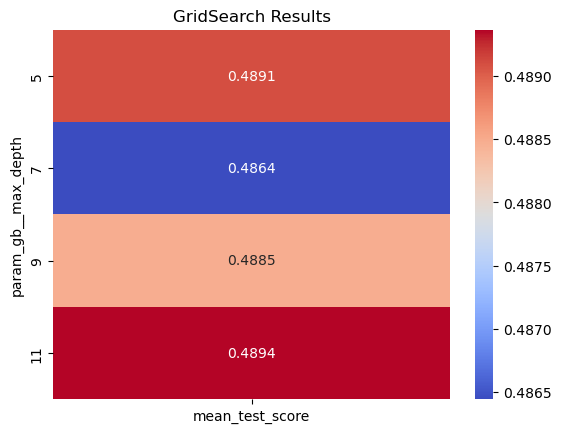

Minimum validation ECM: 0.456


In [126]:
# Getting the average test scores
lgbm_e_results = pd.DataFrame(lgbm_e_grid.cv_results_)
lgbm_e_results['mean_test_score'] = abs(lgbm_e_results['mean_test_score'])

# Plotting the test scores
lgbm_e_heatmap_data = pd.pivot_table(data=lgbm_e_results, values='mean_test_score', index='param_gb__max_depth')
sns.heatmap(lgbm_e_heatmap_data, annot=True, fmt='.4g', cmap='coolwarm')
plt.title('GridSearch Results')
plt.show()

# Printing the minimum validation ECM and the index of the best parameter
print('Minimum validation ECM:', round(min(lgbm_e_results['mean_test_score']),3))

In [127]:
# Best parameter
lgbm_e_best_param = lgbm_e_grid.best_params_
print(lgbm_e_best_param)

# Get the best model from the grid search
lgbm_e_best_model = lgbm_e_grid.best_estimator_

# Predict on the test data using the best parameters
lgbm_y_e_pred = lgbm_e_best_model.predict(X_e_test)
lgbm_y_e_pred_proba = lgbm_e_best_model.predict_proba(X_e_test)[:, 1]

{'gb__learning_rate': 0.1, 'gb__max_depth': 5, 'gb__min_child_samples': 50, 'gb__num_leaves': 77, 'gb__reg_lambda': 5}


In [128]:
# Calculate the custom scorer for different threshold values
thresholds = np.arange(0.0, 0.15, 0.000001)
scores = []
for threshold in thresholds:
    preds = (lgbm_y_e_pred_proba >= threshold).astype(int)
    score = ECM(y_e_test.values.ravel(), preds)
    scores.append(score)

# Find the threshold that gives the best score
lgbm_e_best_threshold = thresholds[np.argmin(scores)]
print("Best threshold:", lgbm_e_best_threshold)

# Adjusting predictions based on optimal threshold
lgbm_y_e_pred = lgbm_y_e_pred_proba >= lgbm_e_best_threshold

# Calculating the various performance metrics
lgbm_e_roc_auc = roc_auc_score(y_e_test.values.ravel(), lgbm_y_e_pred_proba)
lgbm_e_tn, lgbm_e_fp, lgbm_e_fn, lgbm_e_tp = confusion_matrix(y_e_test.values.ravel(), lgbm_y_e_pred).ravel()
lgbm_e_sensitivity = lgbm_e_tp / (lgbm_e_tp + lgbm_e_fn)
lgbm_e_specificity = lgbm_e_tn / (lgbm_e_tn + lgbm_e_fp)
lgbm_e_accuracy = accuracy_score(y_e_test.values.ravel(),lgbm_y_e_pred)
lgbm_e_f1 = f1_score(y_e_test.values.ravel(), lgbm_y_e_pred)
lgbm_e_ecm_score = ECM(y_e_test.values.ravel(),lgbm_y_e_pred)

# Printing the performance metrics
print("ROC AUC Score: {:.3f}".format(lgbm_e_roc_auc))
print("Accuracy Score: {:.3f}".format(lgbm_e_accuracy))
print("Specificity Score: {:.3f}".format(lgbm_e_specificity))
print("Sensitivity Score: {:.3f}".format(lgbm_e_sensitivity))
print("F1 Score: {:.3f}".format(lgbm_e_f1))
print("ECM: {:.3f}".format(lgbm_e_ecm_score))

Best threshold: 0.032207
ROC AUC Score: 0.698
Accuracy Score: 0.856
Specificity Score: 0.863
Sensitivity Score: 0.480
F1 Score: 0.103
ECM: 0.470


In [213]:
# Start timer
start_time = time.time()

# Fit model on data
lgbm_e_best_model.fit(X_e_train, y_e_train)

# End timer
end_time = time.time()

# Calculate time taken to fit model
time_taken = end_time - start_time

# Print time taken
print(f"Time taken to fit ECT LGBM: {time_taken:.5f} seconds")

Time taken to fit ECT LGBM: 0.47909 seconds


## Full Model Performance

In [129]:
# Pipeline steps
lgbm_f_steps = [
    ("over", SMOTE(random_state=42)), 
    ("gb", ltb.LGBMClassifier(random_state=42, n_jobs=-1)), 
]

# Pipeline
lgbm_f_pipeline = Pipeline(lgbm_f_steps)

# Set up the grid search parameters
lgbm_f_parameters = {'gb__num_leaves': [19, 77, 307, 1229],
                    'gb__max_depth': np.arange(5, 12, 2),
                    'gb__learning_rate': [0.05, 0.1],
                     'gb__min_child_samples': [20, 50, 75, 100],
                    'gb__reg_lambda': [5, 10]}

# Setting up the GridSearch with CV
lgbm_f_grid = GridSearchCV(lgbm_f_pipeline, lgbm_f_parameters, cv=kf, verbose = 10, scoring=lgbm_scoring)

# Fit the grid search object to the training data
lgbm_f_grid.fit(X_f_train, y_f_train)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
[CV 1/5; 1/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5
[CV 1/5; 1/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.450 total time=   2.0s
[CV 2/5; 1/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5
[CV 2/5; 1/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.458 total time=   2.7s
[CV 3/5; 1/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5
[CV 3/5; 1/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.457 total time=   2.9s
[CV 4/5; 1/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, g

[CV 5/5; 6/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.515 total time=   2.3s
[CV 1/5; 7/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=5
[CV 1/5; 7/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.465 total time=   1.7s
[CV 2/5; 7/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=5
[CV 2/5; 7/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.421 total time=   1.6s
[CV 3/5; 7/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=5
[CV 3/5; 7/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.451 to

[CV 4/5; 12/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.537 total time=   1.6s
[CV 5/5; 12/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10
[CV 5/5; 12/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.555 total time=   1.4s
[CV 1/5; 13/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=5
[CV 1/5; 13/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.477 total time=   1.4s
[CV 2/5; 13/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=5
[CV 2/5; 13/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.441 to

[CV 3/5; 18/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.533 total time=   1.3s
[CV 4/5; 18/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 4/5; 18/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.571 total time=   1.3s
[CV 5/5; 18/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 5/5; 18/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.564 total time=   1.3s
[CV 1/5; 19/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=5
[CV 1/5; 19/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.455 tota

[CV 2/5; 24/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.469 total time=   1.2s
[CV 3/5; 24/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10
[CV 3/5; 24/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.530 total time=   1.5s
[CV 4/5; 24/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10
[CV 4/5; 24/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.565 total time=   1.2s
[CV 5/5; 24/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10
[CV 5/5; 24/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, s

[CV 1/5; 30/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.493 total time=   1.3s
[CV 2/5; 30/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10
[CV 2/5; 30/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.499 total time=   1.3s
[CV 3/5; 30/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10
[CV 3/5; 30/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.507 total time=   1.2s
[CV 4/5; 30/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10
[CV 4/5; 30/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10;, s

[CV 5/5; 35/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.504 total time=   2.1s
[CV 1/5; 36/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10
[CV 1/5; 36/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.382 total time=   1.7s
[CV 2/5; 36/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10
[CV 2/5; 36/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.462 total time=   1.5s
[CV 3/5; 36/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10
[CV 3/5; 36/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.463 tot

[CV 4/5; 41/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.557 total time=   1.8s
[CV 5/5; 41/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5
[CV 5/5; 41/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.512 total time=   2.0s
[CV 1/5; 42/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=10
[CV 1/5; 42/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.412 total time=   1.9s
[CV 2/5; 42/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=10
[CV 2/5; 42/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.471 total

[CV 3/5; 47/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.446 total time=   1.8s
[CV 4/5; 47/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5
[CV 4/5; 47/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.525 total time=   2.1s
[CV 5/5; 47/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5
[CV 5/5; 47/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.455 total time=   1.5s
[CV 1/5; 48/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=10
[CV 1/5; 48/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=10;, score=

[CV 2/5; 53/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.458 total time=   2.2s
[CV 3/5; 53/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5
[CV 3/5; 53/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.466 total time=   1.7s
[CV 4/5; 53/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5
[CV 4/5; 53/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.564 total time=   1.4s
[CV 5/5; 53/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5
[CV 5/5; 53/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.484 to

[CV 1/5; 59/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.457 total time=   1.4s
[CV 2/5; 59/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5
[CV 2/5; 59/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.480 total time=   1.6s
[CV 3/5; 59/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5
[CV 3/5; 59/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.511 total time=   1.6s
[CV 4/5; 59/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5
[CV 4/5; 59/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.549 to

[CV 5/5; 64/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.429 total time=   2.3s
[CV 1/5; 65/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5
[CV 1/5; 65/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.437 total time=   2.5s
[CV 2/5; 65/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5
[CV 2/5; 65/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.431 total time=   2.3s
[CV 3/5; 65/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5
[CV 3/5; 65/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.400 total

[CV 4/5; 70/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.555 total time=   2.4s
[CV 5/5; 70/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10
[CV 5/5; 70/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.449 total time=   3.0s
[CV 1/5; 71/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=5
[CV 1/5; 71/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.419 total time=   2.9s
[CV 2/5; 71/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=5
[CV 2/5; 71/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0

[CV 3/5; 76/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.467 total time=   2.5s
[CV 4/5; 76/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10
[CV 4/5; 76/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.457 total time=   3.0s
[CV 5/5; 76/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10
[CV 5/5; 76/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.436 total time=   3.9s
[CV 1/5; 77/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=5
[CV 1/5; 77/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.400 to

[CV 2/5; 82/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.464 total time=   2.0s
[CV 3/5; 82/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 3/5; 82/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.430 total time=   2.1s
[CV 4/5; 82/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 4/5; 82/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.516 total time=   2.2s
[CV 5/5; 82/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 5/5; 82/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.490 to

[CV 1/5; 88/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.369 total time=   2.2s
[CV 2/5; 88/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10
[CV 2/5; 88/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.469 total time=   2.1s
[CV 3/5; 88/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10
[CV 3/5; 88/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.516 total time=   1.9s
[CV 4/5; 88/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10
[CV 4/5; 88/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, s

[CV 5/5; 93/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.428 total time=   2.5s
[CV 1/5; 94/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10
[CV 1/5; 94/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.475 total time=   1.8s
[CV 2/5; 94/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10
[CV 2/5; 94/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.484 total time=   1.8s
[CV 3/5; 94/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10
[CV 3/5; 94/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10;, sc

[CV 4/5; 99/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.526 total time=   2.3s
[CV 5/5; 99/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5
[CV 5/5; 99/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.434 total time=   2.9s
[CV 1/5; 100/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10
[CV 1/5; 100/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.441 total time=   2.8s
[CV 2/5; 100/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10
[CV 2/5; 100/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10;, score=-

[CV 3/5; 105/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.439 total time=   3.2s
[CV 4/5; 105/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5
[CV 4/5; 105/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.500 total time=   2.8s
[CV 5/5; 105/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5
[CV 5/5; 105/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.522 total time=   3.0s
[CV 1/5; 106/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=10
[CV 1/5; 106/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=10;, score=

[CV 2/5; 111/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.440 total time=   3.2s
[CV 3/5; 111/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5
[CV 3/5; 111/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.512 total time=   3.0s
[CV 4/5; 111/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5
[CV 4/5; 111/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.503 total time=   3.1s
[CV 5/5; 111/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5
[CV 5/5; 111/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambd

[CV 1/5; 117/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.491 total time=   2.2s
[CV 2/5; 117/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5
[CV 2/5; 117/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.430 total time=   2.0s
[CV 3/5; 117/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5
[CV 3/5; 117/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.471 total time=   2.0s
[CV 4/5; 117/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5
[CV 4/5; 117/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, s

[CV 5/5; 122/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.438 total time=   2.3s
[CV 1/5; 123/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5
[CV 1/5; 123/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.472 total time=   2.4s
[CV 2/5; 123/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5
[CV 2/5; 123/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.465 total time=   2.3s
[CV 3/5; 123/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5
[CV 3/5; 123/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5;, 

[CV 3/5; 128/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.501 total time=   2.3s
[CV 4/5; 128/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10
[CV 4/5; 128/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.537 total time=   2.3s
[CV 5/5; 128/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10
[CV 5/5; 128/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.408 total time=   2.4s
[CV 1/5; 129/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5
[CV 1/5; 129/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lam

[CV 2/5; 134/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.406 total time=   2.3s
[CV 3/5; 134/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10
[CV 3/5; 134/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.501 total time=   2.0s
[CV 4/5; 134/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10
[CV 4/5; 134/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.489 total time=   2.1s
[CV 5/5; 134/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10
[CV 5/5; 134/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0

[CV 1/5; 140/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.481 total time=   1.8s
[CV 2/5; 140/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10
[CV 2/5; 140/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.443 total time=   2.0s
[CV 3/5; 140/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10
[CV 3/5; 140/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.441 total time=   1.9s
[CV 4/5; 140/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10
[CV 4/5; 140/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.478 to

[CV 5/5; 145/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.476 total time=   2.0s
[CV 1/5; 146/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 1/5; 146/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.453 total time=   1.9s
[CV 2/5; 146/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 2/5; 146/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.403 total time=   2.0s
[CV 3/5; 146/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 3/5; 146/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.510 tot

[CV 4/5; 151/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.497 total time=   2.1s
[CV 5/5; 151/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5
[CV 5/5; 151/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.485 total time=   1.9s
[CV 1/5; 152/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10
[CV 1/5; 152/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.462 total time=   1.8s
[CV 2/5; 152/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10
[CV 2/5; 152/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, scor

[CV 3/5; 157/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.442 total time=   1.9s
[CV 4/5; 157/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5
[CV 4/5; 157/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.432 total time=   2.2s
[CV 5/5; 157/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5
[CV 5/5; 157/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.476 total time=   1.8s
[CV 1/5; 158/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10
[CV 1/5; 158/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10;, score=

[CV 2/5; 163/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.405 total time=   2.4s
[CV 3/5; 163/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5
[CV 3/5; 163/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.474 total time=   2.3s
[CV 4/5; 163/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5
[CV 4/5; 163/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.554 total time=   2.3s
[CV 5/5; 163/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5
[CV 5/5; 163/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.492 total tim

[CV 1/5; 169/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.459 total time=   1.9s
[CV 2/5; 169/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5
[CV 2/5; 169/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.430 total time=   2.1s
[CV 3/5; 169/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5
[CV 3/5; 169/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.459 total time=   2.0s
[CV 4/5; 169/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5
[CV 4/5; 169/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.518 total tim

[CV 5/5; 174/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.450 total time=   2.0s
[CV 1/5; 175/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5
[CV 1/5; 175/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.455 total time=   2.1s
[CV 2/5; 175/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5
[CV 2/5; 175/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.403 total time=   2.1s
[CV 3/5; 175/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5
[CV 3/5; 175/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0

[CV 4/5; 180/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.503 total time=   2.0s
[CV 5/5; 180/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=10
[CV 5/5; 180/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.443 total time=   2.0s
[CV 1/5; 181/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5
[CV 1/5; 181/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.417 total time=   2.2s
[CV 2/5; 181/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5
[CV 2/5; 181/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.409 to

[CV 3/5; 186/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.477 total time=   2.1s
[CV 4/5; 186/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10
[CV 4/5; 186/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.485 total time=   1.9s
[CV 5/5; 186/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10
[CV 5/5; 186/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.463 total time=   1.9s
[CV 1/5; 187/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5
[CV 1/5; 187/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.4

[CV 2/5; 192/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.409 total time=   2.0s
[CV 3/5; 192/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10
[CV 3/5; 192/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.545 total time=   1.8s
[CV 4/5; 192/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10
[CV 4/5; 192/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.453 total time=   2.1s
[CV 5/5; 192/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10
[CV 5/5; 192/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda

[CV 1/5; 198/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.428 total time=   2.7s
[CV 2/5; 198/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10
[CV 2/5; 198/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.468 total time=   2.8s
[CV 3/5; 198/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10
[CV 3/5; 198/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.534 total time=   2.6s
[CV 4/5; 198/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10
[CV 4/5; 198/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0

[CV 5/5; 203/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.472 total time=   2.3s
[CV 1/5; 204/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10
[CV 1/5; 204/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.438 total time=   2.6s
[CV 2/5; 204/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10
[CV 2/5; 204/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.418 total time=   2.6s
[CV 3/5; 204/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10
[CV 3/5; 204/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.464 tot

[CV 4/5; 209/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.505 total time=   2.1s
[CV 5/5; 209/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=5
[CV 5/5; 209/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.484 total time=   2.0s
[CV 1/5; 210/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 1/5; 210/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.487 total time=   2.0s
[CV 2/5; 210/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 2/5; 210/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.415 total

[CV 3/5; 215/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.500 total time=   2.1s
[CV 4/5; 215/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5
[CV 4/5; 215/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.535 total time=   2.3s
[CV 5/5; 215/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5
[CV 5/5; 215/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.430 total time=   2.2s
[CV 1/5; 216/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10
[CV 1/5; 216/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, score=

[CV 2/5; 221/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.437 total time=   2.3s
[CV 3/5; 221/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5
[CV 3/5; 221/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.492 total time=   2.3s
[CV 4/5; 221/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5
[CV 4/5; 221/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.480 total time=   2.2s
[CV 5/5; 221/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5
[CV 5/5; 221/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5;, score=-0

[CV 1/5; 227/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.421 total time=   2.6s
[CV 2/5; 227/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5
[CV 2/5; 227/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.417 total time=   2.4s
[CV 3/5; 227/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5
[CV 3/5; 227/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.543 total time=   2.6s
[CV 4/5; 227/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5
[CV 4/5; 227/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.551 to

[CV 5/5; 232/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.479 total time=   2.7s
[CV 1/5; 233/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5
[CV 1/5; 233/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.487 total time=   2.6s
[CV 2/5; 233/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5
[CV 2/5; 233/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.405 total time=   2.1s
[CV 3/5; 233/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5
[CV 3/5; 233/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.432

[CV 4/5; 238/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.514 total time=   2.2s
[CV 5/5; 238/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=10
[CV 5/5; 238/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.474 total time=   2.2s
[CV 1/5; 239/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5
[CV 1/5; 239/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.444 total time=   2.6s
[CV 2/5; 239/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5
[CV 2/5; 239/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5;, s

[CV 3/5; 244/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.509 total time=   2.2s
[CV 4/5; 244/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=10
[CV 4/5; 244/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.533 total time=   2.2s
[CV 5/5; 244/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=10
[CV 5/5; 244/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.472 total time=   2.2s
[CV 1/5; 245/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5
[CV 1/5; 245/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0

[CV 2/5; 250/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.455 total time=   2.4s
[CV 3/5; 250/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10
[CV 3/5; 250/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.480 total time=   2.0s
[CV 4/5; 250/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10
[CV 4/5; 250/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.520 total time=   1.9s
[CV 5/5; 250/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10
[CV 5/5; 250/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10;, s

[CV 1/5; 256/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.468 total time=   2.5s
[CV 2/5; 256/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10
[CV 2/5; 256/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.425 total time=   2.2s
[CV 3/5; 256/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10
[CV 3/5; 256/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.534 total time=   2.3s
[CV 4/5; 256/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10
[CV 4/5; 256/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=25, shuffle=True),
             estimator=Pipeline(steps=[('over', SMOTE(random_state=42)),
                                       ('gb',
                                        LGBMClassifier(random_state=42))]),
             param_grid={'gb__learning_rate': [0.05, 0.1],
                         'gb__max_depth': array([ 5,  7,  9, 11]),
                         'gb__min_child_samples': [20, 50, 75, 100],
                         'gb__num_leaves': [19, 77, 307, 1229],
                         'gb__reg_lambda': [5, 10]},
             scoring=make_scorer(LGBM_ECM, greater_is_better=False, needs_proba=True),
             verbose=10)

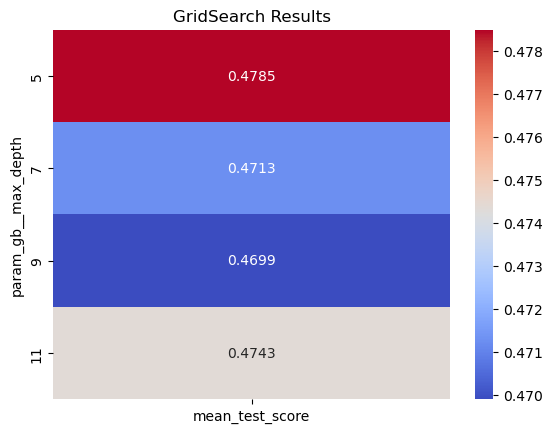

Minimum validation ECM: 0.444


In [130]:
# Getting the average test scores
lgbm_f_results = pd.DataFrame(lgbm_f_grid.cv_results_)
lgbm_f_results['mean_test_score'] = abs(lgbm_f_results['mean_test_score'])

# Plotting the test scores
lgbm_f_heatmap_data = pd.pivot_table(data=lgbm_f_results, values='mean_test_score', index='param_gb__max_depth')
sns.heatmap(lgbm_f_heatmap_data, annot=True, fmt='.4g', cmap='coolwarm')
plt.title('GridSearch Results')
plt.show()

# Printing the minimum validation ECM and the index of the best parameter
print('Minimum validation ECM:', round(min(lgbm_f_results['mean_test_score']),3))

In [131]:
# Best parameter
lgbm_f_best_param = lgbm_f_grid.best_params_
print(lgbm_f_best_param)

# Get the best model from the grid search
lgbm_f_best_model = lgbm_f_grid.best_estimator_

# Predict on the test data using the best parameters
lgbm_y_f_pred = lgbm_f_best_model.predict(X_f_test)
lgbm_y_f_pred_proba = lgbm_f_best_model.predict_proba(X_f_test)[:, 1]

{'gb__learning_rate': 0.1, 'gb__max_depth': 5, 'gb__min_child_samples': 100, 'gb__num_leaves': 19, 'gb__reg_lambda': 10}


In [132]:
# Calculate the custom scorer for different threshold values
thresholds = np.arange(0.0, 0.15, 0.000001)
scores = []
for threshold in thresholds:
    preds = (lgbm_y_f_pred_proba >= threshold).astype(int)
    score = ECM(y_f_test.values.ravel(), preds)
    scores.append(score)

# Find the threshold that gives the best score
lgbm_f_best_threshold = thresholds[np.argmin(scores)]
print("Best threshold:", lgbm_f_best_threshold)

# Adjusting predictions based on optimal threshold
lgbm_y_f_pred = lgbm_y_f_pred_proba >= lgbm_f_best_threshold

# Calculating the various performance metrics
lgbm_f_roc_auc = roc_auc_score(y_f_test.values.ravel(), lgbm_y_f_pred_proba)
lgbm_f_tn, lgbm_f_fp, lgbm_f_fn, lgbm_f_tp = confusion_matrix(y_f_test.values.ravel(), lgbm_y_f_pred).ravel()
lgbm_f_sensitivity = lgbm_f_tp / (lgbm_f_tp + lgbm_f_fn)
lgbm_f_specificity = lgbm_f_tn / (lgbm_f_tn + lgbm_f_fp)
lgbm_f_accuracy = accuracy_score(y_f_test.values.ravel(),lgbm_y_f_pred)
lgbm_f_f1 = f1_score(y_f_test.values.ravel(), lgbm_y_f_pred)
lgbm_f_ecm_score = ECM(y_f_test.values.ravel(),lgbm_y_f_pred)

# Printing the performance metrics
print("ROC AUC Score: {:.3f}".format(lgbm_f_roc_auc))
print("Accuracy Score: {:.3f}".format(lgbm_f_accuracy))
print("Specificity Score: {:.3f}".format(lgbm_f_specificity))
print("Sensitivity Score: {:.3f}".format(lgbm_f_sensitivity))
print("F1 Score: {:.3f}".format(lgbm_f_f1))
print("ECM: {:.3f}".format(lgbm_f_ecm_score))

Best threshold: 0.10352199999999999
ROC AUC Score: 0.635
Accuracy Score: 0.942
Specificity Score: 0.956
Sensitivity Score: 0.160
F1 Score: 0.087
ECM: 0.587


In [207]:
# Start timer
start_time = time.time()

# Fit model on data
lgbm_f_best_model.fit(X_f_train, y_f_train)

# End timer
end_time = time.time()

# Calculate time taken to fit model
time_taken = end_time - start_time

# Print time taken
print(f"Time taken to fit full LGBM: {time_taken:.5f} seconds")

Time taken to fit full LGBM: 0.41794 seconds


## SAPSO Performance

In [194]:
# Importing the SAPSO data
sapso = pd.read_csv('lgbm_sapso_data.csv')

# Defining X and y
y_slgbm = pd.Series(data=sapso['Target'])
X_slgbm = sapso.drop(columns=['Target'])

# Splitting the data
X_slgbm_train, X_slgbm_test, y_slgbm_train, y_slgbm_test = train_test_split(X_slgbm, y_slgbm, test_size=0.3, stratify=y_slgbm,random_state=42)

# Numerical columns - SAPSO
num_cols_s = list(X_slgbm_train.select_dtypes(include=['float']).columns)
# Non numerical columns - SAPSO
non_num_cols_s = list(X_slgbm_train.select_dtypes(exclude=['float']).columns)

In [195]:
# Pipeline steps
lgbm_s_steps = [
    ("over", SMOTE(random_state=42)), 
    ("gb", ltb.LGBMClassifier(random_state=42, n_jobs=-1)), 
]

# Pipeline
lgbm_s_pipeline = Pipeline(lgbm_s_steps)

# Set up the grid search parameters
lgbm_s_parameters = {'gb__num_leaves': np.arange(25, 126, 25),
                    'gb__max_depth': np.arange(5, 16, 2),
                    'gb__learning_rate': [0.05, 0.01, 0.1],
                    'gb__reg_lambda': [0.1, 1, 5]}

# Setting up the GridSearch with CV
lgbm_s_grid = GridSearchCV(lgbm_s_pipeline, lgbm_s_parameters, cv=kf, verbose = 10, scoring=lgbm_scoring)

# Fit the grid search object to the training data
lgbm_s_grid.fit(X_slgbm_train, y_slgbm_train)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits
[CV 1/5; 1/270] START gb__learning_rate=0.05, gb__max_depth=5, gb__num_leaves=25, gb__reg_lambda=0.1
[CV 1/5; 1/270] END gb__learning_rate=0.05, gb__max_depth=5, gb__num_leaves=25, gb__reg_lambda=0.1;, score=-0.605 total time=   0.6s
[CV 2/5; 1/270] START gb__learning_rate=0.05, gb__max_depth=5, gb__num_leaves=25, gb__reg_lambda=0.1
[CV 2/5; 1/270] END gb__learning_rate=0.05, gb__max_depth=5, gb__num_leaves=25, gb__reg_lambda=0.1;, score=-0.602 total time=   0.6s
[CV 3/5; 1/270] START gb__learning_rate=0.05, gb__max_depth=5, gb__num_leaves=25, gb__reg_lambda=0.1
[CV 3/5; 1/270] END gb__learning_rate=0.05, gb__max_depth=5, gb__num_leaves=25, gb__reg_lambda=0.1;, score=-0.556 total time=   0.6s
[CV 4/5; 1/270] START gb__learning_rate=0.05, gb__max_depth=5, gb__num_leaves=25, gb__reg_lambda=0.1
[CV 4/5; 1/270] END gb__learning_rate=0.05, gb__max_depth=5, gb__num_leaves=25, gb__reg_lambda=0.1;, score=-0.606 total time=   0.6s


[CV 1/5; 8/270] END gb__learning_rate=0.05, gb__max_depth=5, gb__num_leaves=75, gb__reg_lambda=1;, score=-0.604 total time=   0.6s
[CV 2/5; 8/270] START gb__learning_rate=0.05, gb__max_depth=5, gb__num_leaves=75, gb__reg_lambda=1
[CV 2/5; 8/270] END gb__learning_rate=0.05, gb__max_depth=5, gb__num_leaves=75, gb__reg_lambda=1;, score=-0.602 total time=   0.6s
[CV 3/5; 8/270] START gb__learning_rate=0.05, gb__max_depth=5, gb__num_leaves=75, gb__reg_lambda=1
[CV 3/5; 8/270] END gb__learning_rate=0.05, gb__max_depth=5, gb__num_leaves=75, gb__reg_lambda=1;, score=-0.555 total time=   0.6s
[CV 4/5; 8/270] START gb__learning_rate=0.05, gb__max_depth=5, gb__num_leaves=75, gb__reg_lambda=1
[CV 4/5; 8/270] END gb__learning_rate=0.05, gb__max_depth=5, gb__num_leaves=75, gb__reg_lambda=1;, score=-0.606 total time=   0.6s
[CV 5/5; 8/270] START gb__learning_rate=0.05, gb__max_depth=5, gb__num_leaves=75, gb__reg_lambda=1
[CV 5/5; 8/270] END gb__learning_rate=0.05, gb__max_depth=5, gb__num_leaves=75, 

[CV 2/5; 15/270] END gb__learning_rate=0.05, gb__max_depth=5, gb__num_leaves=125, gb__reg_lambda=5;, score=-0.604 total time=   0.7s
[CV 3/5; 15/270] START gb__learning_rate=0.05, gb__max_depth=5, gb__num_leaves=125, gb__reg_lambda=5
[CV 3/5; 15/270] END gb__learning_rate=0.05, gb__max_depth=5, gb__num_leaves=125, gb__reg_lambda=5;, score=-0.556 total time=   0.6s
[CV 4/5; 15/270] START gb__learning_rate=0.05, gb__max_depth=5, gb__num_leaves=125, gb__reg_lambda=5
[CV 4/5; 15/270] END gb__learning_rate=0.05, gb__max_depth=5, gb__num_leaves=125, gb__reg_lambda=5;, score=-0.612 total time=   0.6s
[CV 5/5; 15/270] START gb__learning_rate=0.05, gb__max_depth=5, gb__num_leaves=125, gb__reg_lambda=5
[CV 5/5; 15/270] END gb__learning_rate=0.05, gb__max_depth=5, gb__num_leaves=125, gb__reg_lambda=5;, score=-0.625 total time=   0.7s
[CV 1/5; 16/270] START gb__learning_rate=0.05, gb__max_depth=7, gb__num_leaves=25, gb__reg_lambda=0.1
[CV 1/5; 16/270] END gb__learning_rate=0.05, gb__max_depth=7, g

[CV 3/5; 22/270] END gb__learning_rate=0.05, gb__max_depth=7, gb__num_leaves=75, gb__reg_lambda=0.1;, score=-0.549 total time=   0.8s
[CV 4/5; 22/270] START gb__learning_rate=0.05, gb__max_depth=7, gb__num_leaves=75, gb__reg_lambda=0.1
[CV 4/5; 22/270] END gb__learning_rate=0.05, gb__max_depth=7, gb__num_leaves=75, gb__reg_lambda=0.1;, score=-0.600 total time=   0.7s
[CV 5/5; 22/270] START gb__learning_rate=0.05, gb__max_depth=7, gb__num_leaves=75, gb__reg_lambda=0.1
[CV 5/5; 22/270] END gb__learning_rate=0.05, gb__max_depth=7, gb__num_leaves=75, gb__reg_lambda=0.1;, score=-0.657 total time=   0.7s
[CV 1/5; 23/270] START gb__learning_rate=0.05, gb__max_depth=7, gb__num_leaves=75, gb__reg_lambda=1
[CV 1/5; 23/270] END gb__learning_rate=0.05, gb__max_depth=7, gb__num_leaves=75, gb__reg_lambda=1;, score=-0.602 total time=   0.7s
[CV 2/5; 23/270] START gb__learning_rate=0.05, gb__max_depth=7, gb__num_leaves=75, gb__reg_lambda=1
[CV 2/5; 23/270] END gb__learning_rate=0.05, gb__max_depth=7, 

[CV 3/5; 29/270] END gb__learning_rate=0.05, gb__max_depth=7, gb__num_leaves=125, gb__reg_lambda=1;, score=-0.544 total time=   0.7s
[CV 4/5; 29/270] START gb__learning_rate=0.05, gb__max_depth=7, gb__num_leaves=125, gb__reg_lambda=1
[CV 4/5; 29/270] END gb__learning_rate=0.05, gb__max_depth=7, gb__num_leaves=125, gb__reg_lambda=1;, score=-0.600 total time=   0.8s
[CV 5/5; 29/270] START gb__learning_rate=0.05, gb__max_depth=7, gb__num_leaves=125, gb__reg_lambda=1
[CV 5/5; 29/270] END gb__learning_rate=0.05, gb__max_depth=7, gb__num_leaves=125, gb__reg_lambda=1;, score=-0.658 total time=   0.7s
[CV 1/5; 30/270] START gb__learning_rate=0.05, gb__max_depth=7, gb__num_leaves=125, gb__reg_lambda=5
[CV 1/5; 30/270] END gb__learning_rate=0.05, gb__max_depth=7, gb__num_leaves=125, gb__reg_lambda=5;, score=-0.602 total time=   0.7s
[CV 2/5; 30/270] START gb__learning_rate=0.05, gb__max_depth=7, gb__num_leaves=125, gb__reg_lambda=5
[CV 2/5; 30/270] END gb__learning_rate=0.05, gb__max_depth=7, gb

[CV 4/5; 36/270] END gb__learning_rate=0.05, gb__max_depth=9, gb__num_leaves=50, gb__reg_lambda=5;, score=-0.597 total time=   0.7s
[CV 5/5; 36/270] START gb__learning_rate=0.05, gb__max_depth=9, gb__num_leaves=50, gb__reg_lambda=5
[CV 5/5; 36/270] END gb__learning_rate=0.05, gb__max_depth=9, gb__num_leaves=50, gb__reg_lambda=5;, score=-0.657 total time=   0.8s
[CV 1/5; 37/270] START gb__learning_rate=0.05, gb__max_depth=9, gb__num_leaves=75, gb__reg_lambda=0.1
[CV 1/5; 37/270] END gb__learning_rate=0.05, gb__max_depth=9, gb__num_leaves=75, gb__reg_lambda=0.1;, score=-0.601 total time=   0.8s
[CV 2/5; 37/270] START gb__learning_rate=0.05, gb__max_depth=9, gb__num_leaves=75, gb__reg_lambda=0.1
[CV 2/5; 37/270] END gb__learning_rate=0.05, gb__max_depth=9, gb__num_leaves=75, gb__reg_lambda=0.1;, score=-0.592 total time=   0.8s
[CV 3/5; 37/270] START gb__learning_rate=0.05, gb__max_depth=9, gb__num_leaves=75, gb__reg_lambda=0.1
[CV 3/5; 37/270] END gb__learning_rate=0.05, gb__max_depth=9, 

[CV 4/5; 43/270] END gb__learning_rate=0.05, gb__max_depth=9, gb__num_leaves=125, gb__reg_lambda=0.1;, score=-0.597 total time=   0.7s
[CV 5/5; 43/270] START gb__learning_rate=0.05, gb__max_depth=9, gb__num_leaves=125, gb__reg_lambda=0.1
[CV 5/5; 43/270] END gb__learning_rate=0.05, gb__max_depth=9, gb__num_leaves=125, gb__reg_lambda=0.1;, score=-0.657 total time=   0.8s
[CV 1/5; 44/270] START gb__learning_rate=0.05, gb__max_depth=9, gb__num_leaves=125, gb__reg_lambda=1
[CV 1/5; 44/270] END gb__learning_rate=0.05, gb__max_depth=9, gb__num_leaves=125, gb__reg_lambda=1;, score=-0.596 total time=   0.8s
[CV 2/5; 44/270] START gb__learning_rate=0.05, gb__max_depth=9, gb__num_leaves=125, gb__reg_lambda=1
[CV 2/5; 44/270] END gb__learning_rate=0.05, gb__max_depth=9, gb__num_leaves=125, gb__reg_lambda=1;, score=-0.592 total time=   0.8s
[CV 3/5; 44/270] START gb__learning_rate=0.05, gb__max_depth=9, gb__num_leaves=125, gb__reg_lambda=1
[CV 3/5; 44/270] END gb__learning_rate=0.05, gb__max_depth

[CV 4/5; 50/270] END gb__learning_rate=0.05, gb__max_depth=11, gb__num_leaves=50, gb__reg_lambda=1;, score=-0.595 total time=   0.9s
[CV 5/5; 50/270] START gb__learning_rate=0.05, gb__max_depth=11, gb__num_leaves=50, gb__reg_lambda=1
[CV 5/5; 50/270] END gb__learning_rate=0.05, gb__max_depth=11, gb__num_leaves=50, gb__reg_lambda=1;, score=-0.654 total time=   0.8s
[CV 1/5; 51/270] START gb__learning_rate=0.05, gb__max_depth=11, gb__num_leaves=50, gb__reg_lambda=5
[CV 1/5; 51/270] END gb__learning_rate=0.05, gb__max_depth=11, gb__num_leaves=50, gb__reg_lambda=5;, score=-0.595 total time=   0.7s
[CV 2/5; 51/270] START gb__learning_rate=0.05, gb__max_depth=11, gb__num_leaves=50, gb__reg_lambda=5
[CV 2/5; 51/270] END gb__learning_rate=0.05, gb__max_depth=11, gb__num_leaves=50, gb__reg_lambda=5;, score=-0.595 total time=   0.8s
[CV 3/5; 51/270] START gb__learning_rate=0.05, gb__max_depth=11, gb__num_leaves=50, gb__reg_lambda=5
[CV 3/5; 51/270] END gb__learning_rate=0.05, gb__max_depth=11, g

[CV 4/5; 57/270] END gb__learning_rate=0.05, gb__max_depth=11, gb__num_leaves=100, gb__reg_lambda=5;, score=-0.597 total time=   0.7s
[CV 5/5; 57/270] START gb__learning_rate=0.05, gb__max_depth=11, gb__num_leaves=100, gb__reg_lambda=5
[CV 5/5; 57/270] END gb__learning_rate=0.05, gb__max_depth=11, gb__num_leaves=100, gb__reg_lambda=5;, score=-0.655 total time=   0.8s
[CV 1/5; 58/270] START gb__learning_rate=0.05, gb__max_depth=11, gb__num_leaves=125, gb__reg_lambda=0.1
[CV 1/5; 58/270] END gb__learning_rate=0.05, gb__max_depth=11, gb__num_leaves=125, gb__reg_lambda=0.1;, score=-0.654 total time=   0.8s
[CV 2/5; 58/270] START gb__learning_rate=0.05, gb__max_depth=11, gb__num_leaves=125, gb__reg_lambda=0.1
[CV 2/5; 58/270] END gb__learning_rate=0.05, gb__max_depth=11, gb__num_leaves=125, gb__reg_lambda=0.1;, score=-0.593 total time=   0.8s
[CV 3/5; 58/270] START gb__learning_rate=0.05, gb__max_depth=11, gb__num_leaves=125, gb__reg_lambda=0.1
[CV 3/5; 58/270] END gb__learning_rate=0.05, g

[CV 4/5; 64/270] END gb__learning_rate=0.05, gb__max_depth=13, gb__num_leaves=50, gb__reg_lambda=0.1;, score=-0.597 total time=   0.8s
[CV 5/5; 64/270] START gb__learning_rate=0.05, gb__max_depth=13, gb__num_leaves=50, gb__reg_lambda=0.1
[CV 5/5; 64/270] END gb__learning_rate=0.05, gb__max_depth=13, gb__num_leaves=50, gb__reg_lambda=0.1;, score=-0.652 total time=   0.9s
[CV 1/5; 65/270] START gb__learning_rate=0.05, gb__max_depth=13, gb__num_leaves=50, gb__reg_lambda=1
[CV 1/5; 65/270] END gb__learning_rate=0.05, gb__max_depth=13, gb__num_leaves=50, gb__reg_lambda=1;, score=-0.651 total time=   0.9s
[CV 2/5; 65/270] START gb__learning_rate=0.05, gb__max_depth=13, gb__num_leaves=50, gb__reg_lambda=1
[CV 2/5; 65/270] END gb__learning_rate=0.05, gb__max_depth=13, gb__num_leaves=50, gb__reg_lambda=1;, score=-0.535 total time=   0.8s
[CV 3/5; 65/270] START gb__learning_rate=0.05, gb__max_depth=13, gb__num_leaves=50, gb__reg_lambda=1
[CV 3/5; 65/270] END gb__learning_rate=0.05, gb__max_depth

[CV 4/5; 71/270] END gb__learning_rate=0.05, gb__max_depth=13, gb__num_leaves=100, gb__reg_lambda=1;, score=-0.595 total time=   0.8s
[CV 5/5; 71/270] START gb__learning_rate=0.05, gb__max_depth=13, gb__num_leaves=100, gb__reg_lambda=1
[CV 5/5; 71/270] END gb__learning_rate=0.05, gb__max_depth=13, gb__num_leaves=100, gb__reg_lambda=1;, score=-0.654 total time=   0.8s
[CV 1/5; 72/270] START gb__learning_rate=0.05, gb__max_depth=13, gb__num_leaves=100, gb__reg_lambda=5
[CV 1/5; 72/270] END gb__learning_rate=0.05, gb__max_depth=13, gb__num_leaves=100, gb__reg_lambda=5;, score=-0.592 total time=   1.0s
[CV 2/5; 72/270] START gb__learning_rate=0.05, gb__max_depth=13, gb__num_leaves=100, gb__reg_lambda=5
[CV 2/5; 72/270] END gb__learning_rate=0.05, gb__max_depth=13, gb__num_leaves=100, gb__reg_lambda=5;, score=-0.593 total time=   1.3s
[CV 3/5; 72/270] START gb__learning_rate=0.05, gb__max_depth=13, gb__num_leaves=100, gb__reg_lambda=5
[CV 3/5; 72/270] END gb__learning_rate=0.05, gb__max_dep

[CV 4/5; 78/270] END gb__learning_rate=0.05, gb__max_depth=15, gb__num_leaves=25, gb__reg_lambda=5;, score=-0.598 total time=   0.8s
[CV 5/5; 78/270] START gb__learning_rate=0.05, gb__max_depth=15, gb__num_leaves=25, gb__reg_lambda=5
[CV 5/5; 78/270] END gb__learning_rate=0.05, gb__max_depth=15, gb__num_leaves=25, gb__reg_lambda=5;, score=-0.657 total time=   0.8s
[CV 1/5; 79/270] START gb__learning_rate=0.05, gb__max_depth=15, gb__num_leaves=50, gb__reg_lambda=0.1
[CV 1/5; 79/270] END gb__learning_rate=0.05, gb__max_depth=15, gb__num_leaves=50, gb__reg_lambda=0.1;, score=-0.654 total time=   1.1s
[CV 2/5; 79/270] START gb__learning_rate=0.05, gb__max_depth=15, gb__num_leaves=50, gb__reg_lambda=0.1
[CV 2/5; 79/270] END gb__learning_rate=0.05, gb__max_depth=15, gb__num_leaves=50, gb__reg_lambda=0.1;, score=-0.592 total time=   1.1s
[CV 3/5; 79/270] START gb__learning_rate=0.05, gb__max_depth=15, gb__num_leaves=50, gb__reg_lambda=0.1
[CV 3/5; 79/270] END gb__learning_rate=0.05, gb__max_d

[CV 4/5; 85/270] END gb__learning_rate=0.05, gb__max_depth=15, gb__num_leaves=100, gb__reg_lambda=0.1;, score=-0.595 total time=   1.4s
[CV 5/5; 85/270] START gb__learning_rate=0.05, gb__max_depth=15, gb__num_leaves=100, gb__reg_lambda=0.1
[CV 5/5; 85/270] END gb__learning_rate=0.05, gb__max_depth=15, gb__num_leaves=100, gb__reg_lambda=0.1;, score=-0.603 total time=   1.4s
[CV 1/5; 86/270] START gb__learning_rate=0.05, gb__max_depth=15, gb__num_leaves=100, gb__reg_lambda=1
[CV 1/5; 86/270] END gb__learning_rate=0.05, gb__max_depth=15, gb__num_leaves=100, gb__reg_lambda=1;, score=-0.651 total time=   1.4s
[CV 2/5; 86/270] START gb__learning_rate=0.05, gb__max_depth=15, gb__num_leaves=100, gb__reg_lambda=1
[CV 2/5; 86/270] END gb__learning_rate=0.05, gb__max_depth=15, gb__num_leaves=100, gb__reg_lambda=1;, score=-0.592 total time=   1.5s
[CV 3/5; 86/270] START gb__learning_rate=0.05, gb__max_depth=15, gb__num_leaves=100, gb__reg_lambda=1
[CV 3/5; 86/270] END gb__learning_rate=0.05, gb__m

[CV 4/5; 92/270] END gb__learning_rate=0.01, gb__max_depth=5, gb__num_leaves=25, gb__reg_lambda=1;, score=-0.494 total time=   0.8s
[CV 5/5; 92/270] START gb__learning_rate=0.01, gb__max_depth=5, gb__num_leaves=25, gb__reg_lambda=1
[CV 5/5; 92/270] END gb__learning_rate=0.01, gb__max_depth=5, gb__num_leaves=25, gb__reg_lambda=1;, score=-0.554 total time=   0.8s
[CV 1/5; 93/270] START gb__learning_rate=0.01, gb__max_depth=5, gb__num_leaves=25, gb__reg_lambda=5
[CV 1/5; 93/270] END gb__learning_rate=0.01, gb__max_depth=5, gb__num_leaves=25, gb__reg_lambda=5;, score=-0.433 total time=   0.8s
[CV 2/5; 93/270] START gb__learning_rate=0.01, gb__max_depth=5, gb__num_leaves=25, gb__reg_lambda=5
[CV 2/5; 93/270] END gb__learning_rate=0.01, gb__max_depth=5, gb__num_leaves=25, gb__reg_lambda=5;, score=-0.511 total time=   0.8s
[CV 3/5; 93/270] START gb__learning_rate=0.01, gb__max_depth=5, gb__num_leaves=25, gb__reg_lambda=5
[CV 3/5; 93/270] END gb__learning_rate=0.01, gb__max_depth=5, gb__num_le

[CV 5/5; 99/270] END gb__learning_rate=0.01, gb__max_depth=5, gb__num_leaves=75, gb__reg_lambda=5;, score=-0.554 total time=   0.9s
[CV 1/5; 100/270] START gb__learning_rate=0.01, gb__max_depth=5, gb__num_leaves=100, gb__reg_lambda=0.1
[CV 1/5; 100/270] END gb__learning_rate=0.01, gb__max_depth=5, gb__num_leaves=100, gb__reg_lambda=0.1;, score=-0.449 total time=   0.8s
[CV 2/5; 100/270] START gb__learning_rate=0.01, gb__max_depth=5, gb__num_leaves=100, gb__reg_lambda=0.1
[CV 2/5; 100/270] END gb__learning_rate=0.01, gb__max_depth=5, gb__num_leaves=100, gb__reg_lambda=0.1;, score=-0.553 total time=   0.8s
[CV 3/5; 100/270] START gb__learning_rate=0.01, gb__max_depth=5, gb__num_leaves=100, gb__reg_lambda=0.1
[CV 3/5; 100/270] END gb__learning_rate=0.01, gb__max_depth=5, gb__num_leaves=100, gb__reg_lambda=0.1;, score=-0.550 total time=   0.8s
[CV 4/5; 100/270] START gb__learning_rate=0.01, gb__max_depth=5, gb__num_leaves=100, gb__reg_lambda=0.1
[CV 4/5; 100/270] END gb__learning_rate=0.01

[CV 5/5; 106/270] END gb__learning_rate=0.01, gb__max_depth=7, gb__num_leaves=25, gb__reg_lambda=0.1;, score=-0.533 total time=   0.9s
[CV 1/5; 107/270] START gb__learning_rate=0.01, gb__max_depth=7, gb__num_leaves=25, gb__reg_lambda=1
[CV 1/5; 107/270] END gb__learning_rate=0.01, gb__max_depth=7, gb__num_leaves=25, gb__reg_lambda=1;, score=-0.562 total time=   0.8s
[CV 2/5; 107/270] START gb__learning_rate=0.01, gb__max_depth=7, gb__num_leaves=25, gb__reg_lambda=1
[CV 2/5; 107/270] END gb__learning_rate=0.01, gb__max_depth=7, gb__num_leaves=25, gb__reg_lambda=1;, score=-0.537 total time=   0.8s
[CV 3/5; 107/270] START gb__learning_rate=0.01, gb__max_depth=7, gb__num_leaves=25, gb__reg_lambda=1
[CV 3/5; 107/270] END gb__learning_rate=0.01, gb__max_depth=7, gb__num_leaves=25, gb__reg_lambda=1;, score=-0.558 total time=   0.9s
[CV 4/5; 107/270] START gb__learning_rate=0.01, gb__max_depth=7, gb__num_leaves=25, gb__reg_lambda=1
[CV 4/5; 107/270] END gb__learning_rate=0.01, gb__max_depth=7,

[CV 5/5; 113/270] END gb__learning_rate=0.01, gb__max_depth=7, gb__num_leaves=75, gb__reg_lambda=1;, score=-0.533 total time=   1.0s
[CV 1/5; 114/270] START gb__learning_rate=0.01, gb__max_depth=7, gb__num_leaves=75, gb__reg_lambda=5
[CV 1/5; 114/270] END gb__learning_rate=0.01, gb__max_depth=7, gb__num_leaves=75, gb__reg_lambda=5;, score=-0.595 total time=   0.8s
[CV 2/5; 114/270] START gb__learning_rate=0.01, gb__max_depth=7, gb__num_leaves=75, gb__reg_lambda=5
[CV 2/5; 114/270] END gb__learning_rate=0.01, gb__max_depth=7, gb__num_leaves=75, gb__reg_lambda=5;, score=-0.562 total time=   0.9s
[CV 3/5; 114/270] START gb__learning_rate=0.01, gb__max_depth=7, gb__num_leaves=75, gb__reg_lambda=5
[CV 3/5; 114/270] END gb__learning_rate=0.01, gb__max_depth=7, gb__num_leaves=75, gb__reg_lambda=5;, score=-0.526 total time=   0.8s
[CV 4/5; 114/270] START gb__learning_rate=0.01, gb__max_depth=7, gb__num_leaves=75, gb__reg_lambda=5
[CV 4/5; 114/270] END gb__learning_rate=0.01, gb__max_depth=7, g

[CV 5/5; 120/270] END gb__learning_rate=0.01, gb__max_depth=7, gb__num_leaves=125, gb__reg_lambda=5;, score=-0.540 total time=   0.9s
[CV 1/5; 121/270] START gb__learning_rate=0.01, gb__max_depth=9, gb__num_leaves=25, gb__reg_lambda=0.1
[CV 1/5; 121/270] END gb__learning_rate=0.01, gb__max_depth=9, gb__num_leaves=25, gb__reg_lambda=0.1;, score=-0.574 total time=   1.0s
[CV 2/5; 121/270] START gb__learning_rate=0.01, gb__max_depth=9, gb__num_leaves=25, gb__reg_lambda=0.1
[CV 2/5; 121/270] END gb__learning_rate=0.01, gb__max_depth=9, gb__num_leaves=25, gb__reg_lambda=0.1;, score=-0.557 total time=   1.0s
[CV 3/5; 121/270] START gb__learning_rate=0.01, gb__max_depth=9, gb__num_leaves=25, gb__reg_lambda=0.1
[CV 3/5; 121/270] END gb__learning_rate=0.01, gb__max_depth=9, gb__num_leaves=25, gb__reg_lambda=0.1;, score=-0.538 total time=   0.9s
[CV 4/5; 121/270] START gb__learning_rate=0.01, gb__max_depth=9, gb__num_leaves=25, gb__reg_lambda=0.1
[CV 4/5; 121/270] END gb__learning_rate=0.01, gb_

[CV 5/5; 127/270] END gb__learning_rate=0.01, gb__max_depth=9, gb__num_leaves=75, gb__reg_lambda=0.1;, score=-0.526 total time=   1.1s
[CV 1/5; 128/270] START gb__learning_rate=0.01, gb__max_depth=9, gb__num_leaves=75, gb__reg_lambda=1
[CV 1/5; 128/270] END gb__learning_rate=0.01, gb__max_depth=9, gb__num_leaves=75, gb__reg_lambda=1;, score=-0.589 total time=   1.0s
[CV 2/5; 128/270] START gb__learning_rate=0.01, gb__max_depth=9, gb__num_leaves=75, gb__reg_lambda=1
[CV 2/5; 128/270] END gb__learning_rate=0.01, gb__max_depth=9, gb__num_leaves=75, gb__reg_lambda=1;, score=-0.508 total time=   1.1s
[CV 3/5; 128/270] START gb__learning_rate=0.01, gb__max_depth=9, gb__num_leaves=75, gb__reg_lambda=1
[CV 3/5; 128/270] END gb__learning_rate=0.01, gb__max_depth=9, gb__num_leaves=75, gb__reg_lambda=1;, score=-0.538 total time=   1.0s
[CV 4/5; 128/270] START gb__learning_rate=0.01, gb__max_depth=9, gb__num_leaves=75, gb__reg_lambda=1
[CV 4/5; 128/270] END gb__learning_rate=0.01, gb__max_depth=9,

[CV 5/5; 134/270] END gb__learning_rate=0.01, gb__max_depth=9, gb__num_leaves=125, gb__reg_lambda=1;, score=-0.523 total time=   1.0s
[CV 1/5; 135/270] START gb__learning_rate=0.01, gb__max_depth=9, gb__num_leaves=125, gb__reg_lambda=5
[CV 1/5; 135/270] END gb__learning_rate=0.01, gb__max_depth=9, gb__num_leaves=125, gb__reg_lambda=5;, score=-0.592 total time=   1.0s
[CV 2/5; 135/270] START gb__learning_rate=0.01, gb__max_depth=9, gb__num_leaves=125, gb__reg_lambda=5
[CV 2/5; 135/270] END gb__learning_rate=0.01, gb__max_depth=9, gb__num_leaves=125, gb__reg_lambda=5;, score=-0.554 total time=   1.0s
[CV 3/5; 135/270] START gb__learning_rate=0.01, gb__max_depth=9, gb__num_leaves=125, gb__reg_lambda=5
[CV 3/5; 135/270] END gb__learning_rate=0.01, gb__max_depth=9, gb__num_leaves=125, gb__reg_lambda=5;, score=-0.532 total time=   1.0s
[CV 4/5; 135/270] START gb__learning_rate=0.01, gb__max_depth=9, gb__num_leaves=125, gb__reg_lambda=5
[CV 4/5; 135/270] END gb__learning_rate=0.01, gb__max_de

[CV 5/5; 141/270] END gb__learning_rate=0.01, gb__max_depth=11, gb__num_leaves=50, gb__reg_lambda=5;, score=-0.518 total time=   0.9s
[CV 1/5; 142/270] START gb__learning_rate=0.01, gb__max_depth=11, gb__num_leaves=75, gb__reg_lambda=0.1
[CV 1/5; 142/270] END gb__learning_rate=0.01, gb__max_depth=11, gb__num_leaves=75, gb__reg_lambda=0.1;, score=-0.607 total time=   1.2s
[CV 2/5; 142/270] START gb__learning_rate=0.01, gb__max_depth=11, gb__num_leaves=75, gb__reg_lambda=0.1
[CV 2/5; 142/270] END gb__learning_rate=0.01, gb__max_depth=11, gb__num_leaves=75, gb__reg_lambda=0.1;, score=-0.501 total time=   1.2s
[CV 3/5; 142/270] START gb__learning_rate=0.01, gb__max_depth=11, gb__num_leaves=75, gb__reg_lambda=0.1
[CV 3/5; 142/270] END gb__learning_rate=0.01, gb__max_depth=11, gb__num_leaves=75, gb__reg_lambda=0.1;, score=-0.619 total time=   1.2s
[CV 4/5; 142/270] START gb__learning_rate=0.01, gb__max_depth=11, gb__num_leaves=75, gb__reg_lambda=0.1
[CV 4/5; 142/270] END gb__learning_rate=0.

[CV 5/5; 148/270] END gb__learning_rate=0.01, gb__max_depth=11, gb__num_leaves=125, gb__reg_lambda=0.1;, score=-0.521 total time=   1.2s
[CV 1/5; 149/270] START gb__learning_rate=0.01, gb__max_depth=11, gb__num_leaves=125, gb__reg_lambda=1
[CV 1/5; 149/270] END gb__learning_rate=0.01, gb__max_depth=11, gb__num_leaves=125, gb__reg_lambda=1;, score=-0.627 total time=   1.1s
[CV 2/5; 149/270] START gb__learning_rate=0.01, gb__max_depth=11, gb__num_leaves=125, gb__reg_lambda=1
[CV 2/5; 149/270] END gb__learning_rate=0.01, gb__max_depth=11, gb__num_leaves=125, gb__reg_lambda=1;, score=-0.498 total time=   1.1s
[CV 3/5; 149/270] START gb__learning_rate=0.01, gb__max_depth=11, gb__num_leaves=125, gb__reg_lambda=1
[CV 3/5; 149/270] END gb__learning_rate=0.01, gb__max_depth=11, gb__num_leaves=125, gb__reg_lambda=1;, score=-0.592 total time=   1.1s
[CV 4/5; 149/270] START gb__learning_rate=0.01, gb__max_depth=11, gb__num_leaves=125, gb__reg_lambda=1
[CV 4/5; 149/270] END gb__learning_rate=0.01, 

[CV 5/5; 155/270] END gb__learning_rate=0.01, gb__max_depth=13, gb__num_leaves=50, gb__reg_lambda=1;, score=-0.538 total time=   1.1s
[CV 1/5; 156/270] START gb__learning_rate=0.01, gb__max_depth=13, gb__num_leaves=50, gb__reg_lambda=5
[CV 1/5; 156/270] END gb__learning_rate=0.01, gb__max_depth=13, gb__num_leaves=50, gb__reg_lambda=5;, score=-0.611 total time=   0.9s
[CV 2/5; 156/270] START gb__learning_rate=0.01, gb__max_depth=13, gb__num_leaves=50, gb__reg_lambda=5
[CV 2/5; 156/270] END gb__learning_rate=0.01, gb__max_depth=13, gb__num_leaves=50, gb__reg_lambda=5;, score=-0.552 total time=   1.0s
[CV 3/5; 156/270] START gb__learning_rate=0.01, gb__max_depth=13, gb__num_leaves=50, gb__reg_lambda=5
[CV 3/5; 156/270] END gb__learning_rate=0.01, gb__max_depth=13, gb__num_leaves=50, gb__reg_lambda=5;, score=-0.542 total time=   1.0s
[CV 4/5; 156/270] START gb__learning_rate=0.01, gb__max_depth=13, gb__num_leaves=50, gb__reg_lambda=5
[CV 4/5; 156/270] END gb__learning_rate=0.01, gb__max_de

[CV 5/5; 162/270] END gb__learning_rate=0.01, gb__max_depth=13, gb__num_leaves=100, gb__reg_lambda=5;, score=-0.515 total time=   1.0s
[CV 1/5; 163/270] START gb__learning_rate=0.01, gb__max_depth=13, gb__num_leaves=125, gb__reg_lambda=0.1
[CV 1/5; 163/270] END gb__learning_rate=0.01, gb__max_depth=13, gb__num_leaves=125, gb__reg_lambda=0.1;, score=-0.617 total time=   1.2s
[CV 2/5; 163/270] START gb__learning_rate=0.01, gb__max_depth=13, gb__num_leaves=125, gb__reg_lambda=0.1
[CV 2/5; 163/270] END gb__learning_rate=0.01, gb__max_depth=13, gb__num_leaves=125, gb__reg_lambda=0.1;, score=-0.540 total time=   1.3s
[CV 3/5; 163/270] START gb__learning_rate=0.01, gb__max_depth=13, gb__num_leaves=125, gb__reg_lambda=0.1
[CV 3/5; 163/270] END gb__learning_rate=0.01, gb__max_depth=13, gb__num_leaves=125, gb__reg_lambda=0.1;, score=-0.619 total time=   1.2s
[CV 4/5; 163/270] START gb__learning_rate=0.01, gb__max_depth=13, gb__num_leaves=125, gb__reg_lambda=0.1
[CV 4/5; 163/270] END gb__learning

[CV 5/5; 169/270] END gb__learning_rate=0.01, gb__max_depth=15, gb__num_leaves=50, gb__reg_lambda=0.1;, score=-0.577 total time=   1.1s
[CV 1/5; 170/270] START gb__learning_rate=0.01, gb__max_depth=15, gb__num_leaves=50, gb__reg_lambda=1
[CV 1/5; 170/270] END gb__learning_rate=0.01, gb__max_depth=15, gb__num_leaves=50, gb__reg_lambda=1;, score=-0.608 total time=   1.1s
[CV 2/5; 170/270] START gb__learning_rate=0.01, gb__max_depth=15, gb__num_leaves=50, gb__reg_lambda=1
[CV 2/5; 170/270] END gb__learning_rate=0.01, gb__max_depth=15, gb__num_leaves=50, gb__reg_lambda=1;, score=-0.504 total time=   1.0s
[CV 3/5; 170/270] START gb__learning_rate=0.01, gb__max_depth=15, gb__num_leaves=50, gb__reg_lambda=1
[CV 3/5; 170/270] END gb__learning_rate=0.01, gb__max_depth=15, gb__num_leaves=50, gb__reg_lambda=1;, score=-0.572 total time=   1.1s
[CV 4/5; 170/270] START gb__learning_rate=0.01, gb__max_depth=15, gb__num_leaves=50, gb__reg_lambda=1
[CV 4/5; 170/270] END gb__learning_rate=0.01, gb__max_

[CV 5/5; 176/270] END gb__learning_rate=0.01, gb__max_depth=15, gb__num_leaves=100, gb__reg_lambda=1;, score=-0.571 total time=   1.1s
[CV 1/5; 177/270] START gb__learning_rate=0.01, gb__max_depth=15, gb__num_leaves=100, gb__reg_lambda=5
[CV 1/5; 177/270] END gb__learning_rate=0.01, gb__max_depth=15, gb__num_leaves=100, gb__reg_lambda=5;, score=-0.620 total time=   1.0s
[CV 2/5; 177/270] START gb__learning_rate=0.01, gb__max_depth=15, gb__num_leaves=100, gb__reg_lambda=5
[CV 2/5; 177/270] END gb__learning_rate=0.01, gb__max_depth=15, gb__num_leaves=100, gb__reg_lambda=5;, score=-0.548 total time=   1.1s
[CV 3/5; 177/270] START gb__learning_rate=0.01, gb__max_depth=15, gb__num_leaves=100, gb__reg_lambda=5
[CV 3/5; 177/270] END gb__learning_rate=0.01, gb__max_depth=15, gb__num_leaves=100, gb__reg_lambda=5;, score=-0.587 total time=   1.1s
[CV 4/5; 177/270] START gb__learning_rate=0.01, gb__max_depth=15, gb__num_leaves=100, gb__reg_lambda=5
[CV 4/5; 177/270] END gb__learning_rate=0.01, gb

[CV 5/5; 183/270] END gb__learning_rate=0.1, gb__max_depth=5, gb__num_leaves=25, gb__reg_lambda=5;, score=-0.654 total time=   0.8s
[CV 1/5; 184/270] START gb__learning_rate=0.1, gb__max_depth=5, gb__num_leaves=50, gb__reg_lambda=0.1
[CV 1/5; 184/270] END gb__learning_rate=0.1, gb__max_depth=5, gb__num_leaves=50, gb__reg_lambda=0.1;, score=-0.595 total time=   0.8s
[CV 2/5; 184/270] START gb__learning_rate=0.1, gb__max_depth=5, gb__num_leaves=50, gb__reg_lambda=0.1
[CV 2/5; 184/270] END gb__learning_rate=0.1, gb__max_depth=5, gb__num_leaves=50, gb__reg_lambda=0.1;, score=-0.535 total time=   0.8s
[CV 3/5; 184/270] START gb__learning_rate=0.1, gb__max_depth=5, gb__num_leaves=50, gb__reg_lambda=0.1
[CV 3/5; 184/270] END gb__learning_rate=0.1, gb__max_depth=5, gb__num_leaves=50, gb__reg_lambda=0.1;, score=-0.549 total time=   0.8s
[CV 4/5; 184/270] START gb__learning_rate=0.1, gb__max_depth=5, gb__num_leaves=50, gb__reg_lambda=0.1
[CV 4/5; 184/270] END gb__learning_rate=0.1, gb__max_depth

[CV 1/5; 191/270] END gb__learning_rate=0.1, gb__max_depth=5, gb__num_leaves=100, gb__reg_lambda=1;, score=-0.596 total time=   0.7s
[CV 2/5; 191/270] START gb__learning_rate=0.1, gb__max_depth=5, gb__num_leaves=100, gb__reg_lambda=1
[CV 2/5; 191/270] END gb__learning_rate=0.1, gb__max_depth=5, gb__num_leaves=100, gb__reg_lambda=1;, score=-0.592 total time=   0.8s
[CV 3/5; 191/270] START gb__learning_rate=0.1, gb__max_depth=5, gb__num_leaves=100, gb__reg_lambda=1
[CV 3/5; 191/270] END gb__learning_rate=0.1, gb__max_depth=5, gb__num_leaves=100, gb__reg_lambda=1;, score=-0.547 total time=   0.8s
[CV 4/5; 191/270] START gb__learning_rate=0.1, gb__max_depth=5, gb__num_leaves=100, gb__reg_lambda=1
[CV 4/5; 191/270] END gb__learning_rate=0.1, gb__max_depth=5, gb__num_leaves=100, gb__reg_lambda=1;, score=-0.601 total time=   0.7s
[CV 5/5; 191/270] START gb__learning_rate=0.1, gb__max_depth=5, gb__num_leaves=100, gb__reg_lambda=1
[CV 5/5; 191/270] END gb__learning_rate=0.1, gb__max_depth=5, gb

[CV 1/5; 198/270] END gb__learning_rate=0.1, gb__max_depth=7, gb__num_leaves=25, gb__reg_lambda=5;, score=-0.595 total time=   0.8s
[CV 2/5; 198/270] START gb__learning_rate=0.1, gb__max_depth=7, gb__num_leaves=25, gb__reg_lambda=5
[CV 2/5; 198/270] END gb__learning_rate=0.1, gb__max_depth=7, gb__num_leaves=25, gb__reg_lambda=5;, score=-0.593 total time=   0.8s
[CV 3/5; 198/270] START gb__learning_rate=0.1, gb__max_depth=7, gb__num_leaves=25, gb__reg_lambda=5
[CV 3/5; 198/270] END gb__learning_rate=0.1, gb__max_depth=7, gb__num_leaves=25, gb__reg_lambda=5;, score=-0.541 total time=   0.8s
[CV 4/5; 198/270] START gb__learning_rate=0.1, gb__max_depth=7, gb__num_leaves=25, gb__reg_lambda=5
[CV 4/5; 198/270] END gb__learning_rate=0.1, gb__max_depth=7, gb__num_leaves=25, gb__reg_lambda=5;, score=-0.601 total time=   0.8s
[CV 5/5; 198/270] START gb__learning_rate=0.1, gb__max_depth=7, gb__num_leaves=25, gb__reg_lambda=5
[CV 5/5; 198/270] END gb__learning_rate=0.1, gb__max_depth=7, gb__num_le

[CV 2/5; 205/270] END gb__learning_rate=0.1, gb__max_depth=7, gb__num_leaves=100, gb__reg_lambda=0.1;, score=-0.595 total time=   0.8s
[CV 3/5; 205/270] START gb__learning_rate=0.1, gb__max_depth=7, gb__num_leaves=100, gb__reg_lambda=0.1
[CV 3/5; 205/270] END gb__learning_rate=0.1, gb__max_depth=7, gb__num_leaves=100, gb__reg_lambda=0.1;, score=-0.541 total time=   0.9s
[CV 4/5; 205/270] START gb__learning_rate=0.1, gb__max_depth=7, gb__num_leaves=100, gb__reg_lambda=0.1
[CV 4/5; 205/270] END gb__learning_rate=0.1, gb__max_depth=7, gb__num_leaves=100, gb__reg_lambda=0.1;, score=-0.597 total time=   0.9s
[CV 5/5; 205/270] START gb__learning_rate=0.1, gb__max_depth=7, gb__num_leaves=100, gb__reg_lambda=0.1
[CV 5/5; 205/270] END gb__learning_rate=0.1, gb__max_depth=7, gb__num_leaves=100, gb__reg_lambda=0.1;, score=-0.652 total time=   0.9s
[CV 1/5; 206/270] START gb__learning_rate=0.1, gb__max_depth=7, gb__num_leaves=100, gb__reg_lambda=1
[CV 1/5; 206/270] END gb__learning_rate=0.1, gb__m

[CV 2/5; 212/270] END gb__learning_rate=0.1, gb__max_depth=9, gb__num_leaves=25, gb__reg_lambda=1;, score=-0.592 total time=   0.6s
[CV 3/5; 212/270] START gb__learning_rate=0.1, gb__max_depth=9, gb__num_leaves=25, gb__reg_lambda=1
[CV 3/5; 212/270] END gb__learning_rate=0.1, gb__max_depth=9, gb__num_leaves=25, gb__reg_lambda=1;, score=-0.595 total time=   0.6s
[CV 4/5; 212/270] START gb__learning_rate=0.1, gb__max_depth=9, gb__num_leaves=25, gb__reg_lambda=1
[CV 4/5; 212/270] END gb__learning_rate=0.1, gb__max_depth=9, gb__num_leaves=25, gb__reg_lambda=1;, score=-0.651 total time=   0.7s
[CV 5/5; 212/270] START gb__learning_rate=0.1, gb__max_depth=9, gb__num_leaves=25, gb__reg_lambda=1
[CV 5/5; 212/270] END gb__learning_rate=0.1, gb__max_depth=9, gb__num_leaves=25, gb__reg_lambda=1;, score=-0.651 total time=   0.6s
[CV 1/5; 213/270] START gb__learning_rate=0.1, gb__max_depth=9, gb__num_leaves=25, gb__reg_lambda=5
[CV 1/5; 213/270] END gb__learning_rate=0.1, gb__max_depth=9, gb__num_le

[CV 3/5; 219/270] END gb__learning_rate=0.1, gb__max_depth=9, gb__num_leaves=75, gb__reg_lambda=5;, score=-0.541 total time=   0.7s
[CV 4/5; 219/270] START gb__learning_rate=0.1, gb__max_depth=9, gb__num_leaves=75, gb__reg_lambda=5
[CV 4/5; 219/270] END gb__learning_rate=0.1, gb__max_depth=9, gb__num_leaves=75, gb__reg_lambda=5;, score=-0.595 total time=   0.7s
[CV 5/5; 219/270] START gb__learning_rate=0.1, gb__max_depth=9, gb__num_leaves=75, gb__reg_lambda=5
[CV 5/5; 219/270] END gb__learning_rate=0.1, gb__max_depth=9, gb__num_leaves=75, gb__reg_lambda=5;, score=-0.652 total time=   0.7s
[CV 1/5; 220/270] START gb__learning_rate=0.1, gb__max_depth=9, gb__num_leaves=100, gb__reg_lambda=0.1
[CV 1/5; 220/270] END gb__learning_rate=0.1, gb__max_depth=9, gb__num_leaves=100, gb__reg_lambda=0.1;, score=-0.652 total time=   0.7s
[CV 2/5; 220/270] START gb__learning_rate=0.1, gb__max_depth=9, gb__num_leaves=100, gb__reg_lambda=0.1
[CV 2/5; 220/270] END gb__learning_rate=0.1, gb__max_depth=9, g

[CV 3/5; 226/270] END gb__learning_rate=0.1, gb__max_depth=11, gb__num_leaves=25, gb__reg_lambda=0.1;, score=-0.594 total time=   0.9s
[CV 4/5; 226/270] START gb__learning_rate=0.1, gb__max_depth=11, gb__num_leaves=25, gb__reg_lambda=0.1
[CV 4/5; 226/270] END gb__learning_rate=0.1, gb__max_depth=11, gb__num_leaves=25, gb__reg_lambda=0.1;, score=-0.649 total time=   0.9s
[CV 5/5; 226/270] START gb__learning_rate=0.1, gb__max_depth=11, gb__num_leaves=25, gb__reg_lambda=0.1
[CV 5/5; 226/270] END gb__learning_rate=0.1, gb__max_depth=11, gb__num_leaves=25, gb__reg_lambda=0.1;, score=-0.651 total time=   0.8s
[CV 1/5; 227/270] START gb__learning_rate=0.1, gb__max_depth=11, gb__num_leaves=25, gb__reg_lambda=1
[CV 1/5; 227/270] END gb__learning_rate=0.1, gb__max_depth=11, gb__num_leaves=25, gb__reg_lambda=1;, score=-0.592 total time=   0.8s
[CV 2/5; 227/270] START gb__learning_rate=0.1, gb__max_depth=11, gb__num_leaves=25, gb__reg_lambda=1
[CV 2/5; 227/270] END gb__learning_rate=0.1, gb__max_d

[CV 3/5; 233/270] END gb__learning_rate=0.1, gb__max_depth=11, gb__num_leaves=75, gb__reg_lambda=1;, score=-0.595 total time=   0.8s
[CV 4/5; 233/270] START gb__learning_rate=0.1, gb__max_depth=11, gb__num_leaves=75, gb__reg_lambda=1
[CV 4/5; 233/270] END gb__learning_rate=0.1, gb__max_depth=11, gb__num_leaves=75, gb__reg_lambda=1;, score=-0.595 total time=   0.8s
[CV 5/5; 233/270] START gb__learning_rate=0.1, gb__max_depth=11, gb__num_leaves=75, gb__reg_lambda=1
[CV 5/5; 233/270] END gb__learning_rate=0.1, gb__max_depth=11, gb__num_leaves=75, gb__reg_lambda=1;, score=-0.652 total time=   0.8s
[CV 1/5; 234/270] START gb__learning_rate=0.1, gb__max_depth=11, gb__num_leaves=75, gb__reg_lambda=5
[CV 1/5; 234/270] END gb__learning_rate=0.1, gb__max_depth=11, gb__num_leaves=75, gb__reg_lambda=5;, score=-0.649 total time=   0.8s
[CV 2/5; 234/270] START gb__learning_rate=0.1, gb__max_depth=11, gb__num_leaves=75, gb__reg_lambda=5
[CV 2/5; 234/270] END gb__learning_rate=0.1, gb__max_depth=11, g

[CV 3/5; 240/270] END gb__learning_rate=0.1, gb__max_depth=11, gb__num_leaves=125, gb__reg_lambda=5;, score=-0.649 total time=   0.8s
[CV 4/5; 240/270] START gb__learning_rate=0.1, gb__max_depth=11, gb__num_leaves=125, gb__reg_lambda=5
[CV 4/5; 240/270] END gb__learning_rate=0.1, gb__max_depth=11, gb__num_leaves=125, gb__reg_lambda=5;, score=-0.598 total time=   0.7s
[CV 5/5; 240/270] START gb__learning_rate=0.1, gb__max_depth=11, gb__num_leaves=125, gb__reg_lambda=5
[CV 5/5; 240/270] END gb__learning_rate=0.1, gb__max_depth=11, gb__num_leaves=125, gb__reg_lambda=5;, score=-0.652 total time=   0.8s
[CV 1/5; 241/270] START gb__learning_rate=0.1, gb__max_depth=13, gb__num_leaves=25, gb__reg_lambda=0.1
[CV 1/5; 241/270] END gb__learning_rate=0.1, gb__max_depth=13, gb__num_leaves=25, gb__reg_lambda=0.1;, score=-0.592 total time=   0.7s
[CV 2/5; 241/270] START gb__learning_rate=0.1, gb__max_depth=13, gb__num_leaves=25, gb__reg_lambda=0.1
[CV 2/5; 241/270] END gb__learning_rate=0.1, gb__max_

[CV 3/5; 247/270] END gb__learning_rate=0.1, gb__max_depth=13, gb__num_leaves=75, gb__reg_lambda=0.1;, score=-0.648 total time=   0.9s
[CV 4/5; 247/270] START gb__learning_rate=0.1, gb__max_depth=13, gb__num_leaves=75, gb__reg_lambda=0.1
[CV 4/5; 247/270] END gb__learning_rate=0.1, gb__max_depth=13, gb__num_leaves=75, gb__reg_lambda=0.1;, score=-0.594 total time=   0.9s
[CV 5/5; 247/270] START gb__learning_rate=0.1, gb__max_depth=13, gb__num_leaves=75, gb__reg_lambda=0.1
[CV 5/5; 247/270] END gb__learning_rate=0.1, gb__max_depth=13, gb__num_leaves=75, gb__reg_lambda=0.1;, score=-0.598 total time=   0.8s
[CV 1/5; 248/270] START gb__learning_rate=0.1, gb__max_depth=13, gb__num_leaves=75, gb__reg_lambda=1
[CV 1/5; 248/270] END gb__learning_rate=0.1, gb__max_depth=13, gb__num_leaves=75, gb__reg_lambda=1;, score=-0.649 total time=   0.8s
[CV 2/5; 248/270] START gb__learning_rate=0.1, gb__max_depth=13, gb__num_leaves=75, gb__reg_lambda=1
[CV 2/5; 248/270] END gb__learning_rate=0.1, gb__max_d

[CV 3/5; 254/270] END gb__learning_rate=0.1, gb__max_depth=13, gb__num_leaves=125, gb__reg_lambda=1;, score=-0.648 total time=   0.8s
[CV 4/5; 254/270] START gb__learning_rate=0.1, gb__max_depth=13, gb__num_leaves=125, gb__reg_lambda=1
[CV 4/5; 254/270] END gb__learning_rate=0.1, gb__max_depth=13, gb__num_leaves=125, gb__reg_lambda=1;, score=-0.595 total time=   0.8s
[CV 5/5; 254/270] START gb__learning_rate=0.1, gb__max_depth=13, gb__num_leaves=125, gb__reg_lambda=1
[CV 5/5; 254/270] END gb__learning_rate=0.1, gb__max_depth=13, gb__num_leaves=125, gb__reg_lambda=1;, score=-0.652 total time=   0.8s
[CV 1/5; 255/270] START gb__learning_rate=0.1, gb__max_depth=13, gb__num_leaves=125, gb__reg_lambda=5
[CV 1/5; 255/270] END gb__learning_rate=0.1, gb__max_depth=13, gb__num_leaves=125, gb__reg_lambda=5;, score=-0.591 total time=   0.8s
[CV 2/5; 255/270] START gb__learning_rate=0.1, gb__max_depth=13, gb__num_leaves=125, gb__reg_lambda=5
[CV 2/5; 255/270] END gb__learning_rate=0.1, gb__max_dep

[CV 3/5; 261/270] END gb__learning_rate=0.1, gb__max_depth=15, gb__num_leaves=50, gb__reg_lambda=5;, score=-0.649 total time=   0.8s
[CV 4/5; 261/270] START gb__learning_rate=0.1, gb__max_depth=15, gb__num_leaves=50, gb__reg_lambda=5
[CV 4/5; 261/270] END gb__learning_rate=0.1, gb__max_depth=15, gb__num_leaves=50, gb__reg_lambda=5;, score=-0.595 total time=   0.8s
[CV 5/5; 261/270] START gb__learning_rate=0.1, gb__max_depth=15, gb__num_leaves=50, gb__reg_lambda=5
[CV 5/5; 261/270] END gb__learning_rate=0.1, gb__max_depth=15, gb__num_leaves=50, gb__reg_lambda=5;, score=-0.652 total time=   0.8s
[CV 1/5; 262/270] START gb__learning_rate=0.1, gb__max_depth=15, gb__num_leaves=75, gb__reg_lambda=0.1
[CV 1/5; 262/270] END gb__learning_rate=0.1, gb__max_depth=15, gb__num_leaves=75, gb__reg_lambda=0.1;, score=-0.649 total time=   1.1s
[CV 2/5; 262/270] START gb__learning_rate=0.1, gb__max_depth=15, gb__num_leaves=75, gb__reg_lambda=0.1
[CV 2/5; 262/270] END gb__learning_rate=0.1, gb__max_depth

[CV 3/5; 268/270] END gb__learning_rate=0.1, gb__max_depth=15, gb__num_leaves=125, gb__reg_lambda=0.1;, score=-0.649 total time=   0.9s
[CV 4/5; 268/270] START gb__learning_rate=0.1, gb__max_depth=15, gb__num_leaves=125, gb__reg_lambda=0.1
[CV 4/5; 268/270] END gb__learning_rate=0.1, gb__max_depth=15, gb__num_leaves=125, gb__reg_lambda=0.1;, score=-0.648 total time=   0.9s
[CV 5/5; 268/270] START gb__learning_rate=0.1, gb__max_depth=15, gb__num_leaves=125, gb__reg_lambda=0.1
[CV 5/5; 268/270] END gb__learning_rate=0.1, gb__max_depth=15, gb__num_leaves=125, gb__reg_lambda=0.1;, score=-0.651 total time=   0.8s
[CV 1/5; 269/270] START gb__learning_rate=0.1, gb__max_depth=15, gb__num_leaves=125, gb__reg_lambda=1
[CV 1/5; 269/270] END gb__learning_rate=0.1, gb__max_depth=15, gb__num_leaves=125, gb__reg_lambda=1;, score=-0.649 total time=   0.9s
[CV 2/5; 269/270] START gb__learning_rate=0.1, gb__max_depth=15, gb__num_leaves=125, gb__reg_lambda=1
[CV 2/5; 269/270] END gb__learning_rate=0.1, g

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=25, shuffle=True),
             estimator=Pipeline(steps=[('over', SMOTE(random_state=42)),
                                       ('gb',
                                        LGBMClassifier(random_state=42))]),
             param_grid={'gb__learning_rate': [0.05, 0.01, 0.1],
                         'gb__max_depth': array([ 5,  7,  9, 11, 13, 15]),
                         'gb__num_leaves': array([ 25,  50,  75, 100, 125]),
                         'gb__reg_lambda': [0.1, 1, 5]},
             scoring=make_scorer(RLR_ECM, greater_is_better=False, needs_proba=True),
             verbose=10)

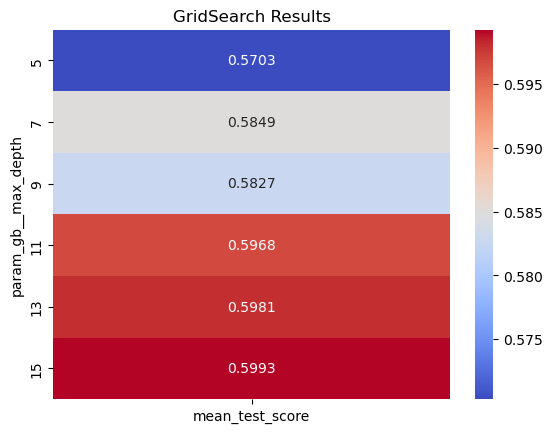

Minimum validation ECM: 0.516


In [196]:
# Getting the average test scores
lgbm_s_results = pd.DataFrame(lgbm_s_grid.cv_results_)
lgbm_s_results['mean_test_score'] = abs(lgbm_s_results['mean_test_score'])

# Plotting the test scores
lgbm_s_heatmap_data = pd.pivot_table(data=lgbm_s_results, values='mean_test_score', index='param_gb__max_depth')
sns.heatmap(lgbm_s_heatmap_data, annot=True, fmt='.4g', cmap='coolwarm')
plt.title('GridSearch Results')
plt.show()

# Printing the minimum validation ECM and the index of the best parameter
print('Minimum validation ECM:', round(min(lgbm_s_results['mean_test_score']),3))

In [197]:
# Best parameter
lgbm_s_best_param = lgbm_s_grid.best_params_
print(lgbm_s_best_param)

# Get the best model from the grid search
lgbm_s_best_model = lgbm_s_grid.best_estimator_

# Predict on the test data using the best parameters
lgbm_y_s_pred = lgbm_s_best_model.predict(X_slgbm_test)
lgbm_y_s_pred_proba = lgbm_s_best_model.predict_proba(X_slgbm_test)[:, 1]

{'gb__learning_rate': 0.01, 'gb__max_depth': 5, 'gb__num_leaves': 50, 'gb__reg_lambda': 5}


In [198]:
# Calculate the custom scorer for different threshold values
thresholds = np.arange(0.0, 1.0, 0.00001)
scores = []
for threshold in thresholds:
    preds = (lgbm_y_s_pred_proba >= threshold).astype(int)
    score = ECM(y_slgbm_test.values.ravel(), preds)
    scores.append(score)

# Find the threshold that gives the best score
lgbm_s_best_threshold = thresholds[np.argmin(scores)]
print("Best threshold:", lgbm_s_best_threshold)

# Adjusting predictions based on optimal threshold
lgbm_y_s_pred = lgbm_y_s_pred_proba >= lgbm_s_best_threshold

# Calculating the various performance metrics
lgbm_s_roc_auc = roc_auc_score(y_slgbm_test.values.ravel(), lgbm_y_s_pred_proba)
lgbm_s_tn, lgbm_s_fp, lgbm_s_fn, lgbm_s_tp = confusion_matrix(y_slgbm_test.values.ravel(), lgbm_y_s_pred).ravel()
lgbm_s_sensitivity = lgbm_s_tp / (lgbm_s_tp + lgbm_s_fn)
lgbm_s_specificity = lgbm_s_tn / (lgbm_s_tn + lgbm_s_fp)
lgbm_s_accuracy = accuracy_score(y_slgbm_test.values.ravel(),lgbm_y_s_pred)
lgbm_s_f1 = f1_score(y_slgbm_test.values.ravel(), lgbm_y_s_pred)
lgbm_s_ecm_score = ECM(y_slgbm_test.values.ravel(),lgbm_y_s_pred)

# Printing the performance metrics
print("ROC AUC Score: {:.3f}".format(lgbm_s_roc_auc))
print("Accuracy Score: {:.3f}".format(lgbm_s_accuracy))
print("Specificity Score: {:.3f}".format(lgbm_s_specificity))
print("Sensitivity Score: {:.3f}".format(lgbm_s_sensitivity))
print("F1 Score: {:.3f}".format(lgbm_s_f1))
print("ECM: {:.3f}".format(lgbm_s_ecm_score))

Best threshold: 0.32632
ROC AUC Score: 0.677
Accuracy Score: 0.657
Specificity Score: 0.656
Sensitivity Score: 0.680
F1 Score: 0.064
ECM: 0.540


In [208]:
# Start timer
start_time = time.time()

# Fit model on data
lgbm_s_best_model.fit(X_slgbm_train, y_slgbm_train)

# End timer
end_time = time.time()

# Calculate time taken to fit model
time_taken = end_time - start_time

# Print time taken
print(f"Time taken to fit SAPSO LGBM: {time_taken:.5f} seconds")

Time taken to fit SAPSO LGBM: 0.19453 seconds


## PSO Performance

In [39]:
# Importing the PSO data
pso = pd.read_csv('lgbm_pso_data.csv')

# Defining X and y
y_plgbm = pd.Series(data=pso['Target'])
X_plgbm = pso.drop(columns=['Target'])

# Splitting the data
X_plgbm_train, X_plgbm_test, y_plgbm_train, y_plgbm_test = train_test_split(X_plgbm, y_plgbm, test_size=0.3, stratify=y_plgbm,random_state=42)

# Numerical columns - PSO
num_cols_p = list(X_plgbm_train.select_dtypes(include=['float']).columns)
# Non numerical columns - PSO
non_num_cols_p = list(X_plgbm_train.select_dtypes(exclude=['float']).columns)

In [42]:
# Pipeline steps
lgbm_p_pteps = [
    ("over", SMOTE(random_state=42)), 
    ("gb", ltb.LGBMClassifier(random_state=42, n_jobs=-1)), 
]

# Pipeline
lgbm_p_pipeline = Pipeline(lgbm_p_pteps)

# Set up the grid search parameters
lgbm_p_parameters =  {'gb__num_leaves': [19, 77, 307, 1229],
                    'gb__max_depth': np.arange(5, 12, 2),
                    'gb__learning_rate': [0.05, 0.1],
                     'gb__min_child_samples': [20, 50, 75, 100],
                    'gb__reg_lambda': [5, 10]}

# Setting up the GridSearch with CV
lgbm_p_grid = GridSearchCV(lgbm_p_pipeline, lgbm_p_parameters, cv=kf, verbose = 10, scoring=lgbm_scoring)

# Fit the grid search object to the training data
lgbm_p_grid.fit(X_plgbm_train, y_plgbm_train)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
[CV 1/5; 1/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5
[CV 1/5; 1/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.559 total time=   1.1s
[CV 2/5; 1/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5
[CV 2/5; 1/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.469 total time=   1.1s
[CV 3/5; 1/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5
[CV 3/5; 1/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.571 total time=   1.0s
[CV 4/5; 1/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, g

[CV 5/5; 6/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.604 total time=   1.1s
[CV 1/5; 7/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=5
[CV 1/5; 7/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.541 total time=   1.0s
[CV 2/5; 7/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=5
[CV 2/5; 7/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.477 total time=   1.1s
[CV 3/5; 7/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=5
[CV 3/5; 7/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.546 to

[CV 4/5; 12/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.412 total time=   1.1s
[CV 5/5; 12/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10
[CV 5/5; 12/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.550 total time=   0.9s
[CV 1/5; 13/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=5
[CV 1/5; 13/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.564 total time=   1.1s
[CV 2/5; 13/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=5
[CV 2/5; 13/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.488 to

[CV 3/5; 18/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.560 total time=   0.9s
[CV 4/5; 18/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 4/5; 18/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.444 total time=   1.2s
[CV 5/5; 18/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 5/5; 18/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.515 total time=   1.0s
[CV 1/5; 19/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=5
[CV 1/5; 19/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.528 tota

[CV 2/5; 24/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.525 total time=   1.1s
[CV 3/5; 24/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10
[CV 3/5; 24/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.563 total time=   1.1s
[CV 4/5; 24/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10
[CV 4/5; 24/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.457 total time=   1.2s
[CV 5/5; 24/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10
[CV 5/5; 24/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, s

[CV 1/5; 30/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.544 total time=   1.2s
[CV 2/5; 30/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10
[CV 2/5; 30/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.551 total time=   1.0s
[CV 3/5; 30/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10
[CV 3/5; 30/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.573 total time=   1.0s
[CV 4/5; 30/256] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10
[CV 4/5; 30/256] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10;, s

[CV 5/5; 35/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.490 total time=   1.1s
[CV 1/5; 36/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10
[CV 1/5; 36/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.447 total time=   1.1s
[CV 2/5; 36/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10
[CV 2/5; 36/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.427 total time=   1.2s
[CV 3/5; 36/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10
[CV 3/5; 36/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.535 tot

[CV 4/5; 41/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.497 total time=   1.2s
[CV 5/5; 41/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5
[CV 5/5; 41/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.442 total time=   1.1s
[CV 1/5; 42/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=10
[CV 1/5; 42/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.515 total time=   1.2s
[CV 2/5; 42/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=10
[CV 2/5; 42/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.468 total

[CV 3/5; 47/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.504 total time=   1.1s
[CV 4/5; 47/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5
[CV 4/5; 47/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.440 total time=   1.1s
[CV 5/5; 47/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5
[CV 5/5; 47/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.486 total time=   1.2s
[CV 1/5; 48/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=10
[CV 1/5; 48/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=10;, score=

[CV 2/5; 53/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.436 total time=   1.1s
[CV 3/5; 53/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5
[CV 3/5; 53/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.508 total time=   0.9s
[CV 4/5; 53/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5
[CV 4/5; 53/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.346 total time=   1.0s
[CV 5/5; 53/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5
[CV 5/5; 53/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.513 to

[CV 1/5; 59/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.462 total time=   1.1s
[CV 2/5; 59/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5
[CV 2/5; 59/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.452 total time=   1.0s
[CV 3/5; 59/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5
[CV 3/5; 59/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.513 total time=   1.3s
[CV 4/5; 59/256] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5
[CV 4/5; 59/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.355 to

[CV 5/5; 64/256] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.508 total time=   1.0s
[CV 1/5; 65/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5
[CV 1/5; 65/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.484 total time=   1.2s
[CV 2/5; 65/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5
[CV 2/5; 65/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.416 total time=   1.2s
[CV 3/5; 65/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5
[CV 3/5; 65/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.588 total

[CV 4/5; 70/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.427 total time=   1.0s
[CV 5/5; 70/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10
[CV 5/5; 70/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.496 total time=   1.2s
[CV 1/5; 71/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=5
[CV 1/5; 71/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.452 total time=   1.2s
[CV 2/5; 71/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=5
[CV 2/5; 71/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0

[CV 3/5; 76/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.515 total time=   1.2s
[CV 4/5; 76/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10
[CV 4/5; 76/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.439 total time=   1.3s
[CV 5/5; 76/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10
[CV 5/5; 76/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.467 total time=   1.2s
[CV 1/5; 77/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=5
[CV 1/5; 77/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.471 to

[CV 2/5; 82/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.480 total time=   1.1s
[CV 3/5; 82/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 3/5; 82/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.534 total time=   1.0s
[CV 4/5; 82/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 4/5; 82/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.435 total time=   1.0s
[CV 5/5; 82/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 5/5; 82/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.529 to

[CV 1/5; 88/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.388 total time=   1.1s
[CV 2/5; 88/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10
[CV 2/5; 88/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.452 total time=   1.1s
[CV 3/5; 88/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10
[CV 3/5; 88/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.522 total time=   1.2s
[CV 4/5; 88/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10
[CV 4/5; 88/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, s

[CV 5/5; 93/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.465 total time=   0.9s
[CV 1/5; 94/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10
[CV 1/5; 94/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.475 total time=   1.0s
[CV 2/5; 94/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10
[CV 2/5; 94/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.477 total time=   1.0s
[CV 3/5; 94/256] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10
[CV 3/5; 94/256] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10;, sc

[CV 4/5; 99/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.368 total time=   1.2s
[CV 5/5; 99/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5
[CV 5/5; 99/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.439 total time=   1.3s
[CV 1/5; 100/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10
[CV 1/5; 100/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.387 total time=   1.2s
[CV 2/5; 100/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10
[CV 2/5; 100/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10;, score=-

[CV 3/5; 105/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.567 total time=   1.1s
[CV 4/5; 105/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5
[CV 4/5; 105/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.483 total time=   1.2s
[CV 5/5; 105/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5
[CV 5/5; 105/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.506 total time=   1.2s
[CV 1/5; 106/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=10
[CV 1/5; 106/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=10;, score=

[CV 2/5; 111/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.387 total time=   1.3s
[CV 3/5; 111/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5
[CV 3/5; 111/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.504 total time=   1.4s
[CV 4/5; 111/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5
[CV 4/5; 111/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.380 total time=   1.4s
[CV 5/5; 111/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5
[CV 5/5; 111/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambd

[CV 1/5; 117/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.413 total time=   1.3s
[CV 2/5; 117/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5
[CV 2/5; 117/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.402 total time=   1.3s
[CV 3/5; 117/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5
[CV 3/5; 117/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.534 total time=   1.3s
[CV 4/5; 117/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5
[CV 4/5; 117/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, s

[CV 5/5; 122/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.517 total time=   1.1s
[CV 1/5; 123/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5
[CV 1/5; 123/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.440 total time=   1.0s
[CV 2/5; 123/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5
[CV 2/5; 123/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.424 total time=   1.2s
[CV 3/5; 123/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5
[CV 3/5; 123/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5;, 

[CV 3/5; 128/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.525 total time=   1.4s
[CV 4/5; 128/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10
[CV 4/5; 128/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.350 total time=   1.1s
[CV 5/5; 128/256] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10
[CV 5/5; 128/256] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.516 total time=   1.1s
[CV 1/5; 129/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5
[CV 1/5; 129/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lam

[CV 2/5; 134/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.369 total time=   1.1s
[CV 3/5; 134/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10
[CV 3/5; 134/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.543 total time=   1.2s
[CV 4/5; 134/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10
[CV 4/5; 134/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.365 total time=   1.3s
[CV 5/5; 134/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10
[CV 5/5; 134/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0

[CV 1/5; 140/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.415 total time=   1.2s
[CV 2/5; 140/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10
[CV 2/5; 140/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.366 total time=   1.1s
[CV 3/5; 140/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10
[CV 3/5; 140/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.551 total time=   1.1s
[CV 4/5; 140/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10
[CV 4/5; 140/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.351 to

[CV 5/5; 145/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.494 total time=   1.1s
[CV 1/5; 146/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 1/5; 146/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.384 total time=   1.2s
[CV 2/5; 146/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 2/5; 146/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.377 total time=   1.1s
[CV 3/5; 146/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 3/5; 146/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.555 tot

[CV 4/5; 151/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.392 total time=   1.1s
[CV 5/5; 151/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5
[CV 5/5; 151/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.465 total time=   1.1s
[CV 1/5; 152/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10
[CV 1/5; 152/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.431 total time=   1.0s
[CV 2/5; 152/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10
[CV 2/5; 152/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, scor

[CV 3/5; 157/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.499 total time=   1.1s
[CV 4/5; 157/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5
[CV 4/5; 157/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.326 total time=   1.1s
[CV 5/5; 157/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5
[CV 5/5; 157/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.516 total time=   1.0s
[CV 1/5; 158/256] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10
[CV 1/5; 158/256] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10;, score=

[CV 2/5; 163/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.387 total time=   1.1s
[CV 3/5; 163/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5
[CV 3/5; 163/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.514 total time=   1.1s
[CV 4/5; 163/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5
[CV 4/5; 163/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.380 total time=   1.2s
[CV 5/5; 163/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5
[CV 5/5; 163/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.454 total tim

[CV 1/5; 169/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.428 total time=   1.3s
[CV 2/5; 169/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5
[CV 2/5; 169/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.383 total time=   1.4s
[CV 3/5; 169/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5
[CV 3/5; 169/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.535 total time=   1.5s
[CV 4/5; 169/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5
[CV 4/5; 169/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.418 total tim

[CV 5/5; 174/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.498 total time=   1.0s
[CV 1/5; 175/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5
[CV 1/5; 175/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.428 total time=   1.0s
[CV 2/5; 175/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5
[CV 2/5; 175/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.438 total time=   1.1s
[CV 3/5; 175/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5
[CV 3/5; 175/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0

[CV 4/5; 180/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.395 total time=   1.2s
[CV 5/5; 180/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=10
[CV 5/5; 180/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.486 total time=   1.1s
[CV 1/5; 181/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5
[CV 1/5; 181/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.377 total time=   1.2s
[CV 2/5; 181/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5
[CV 2/5; 181/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.408 to

[CV 3/5; 186/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.539 total time=   1.1s
[CV 4/5; 186/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10
[CV 4/5; 186/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.396 total time=   0.9s
[CV 5/5; 186/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10
[CV 5/5; 186/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.432 total time=   1.1s
[CV 1/5; 187/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5
[CV 1/5; 187/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.4

[CV 2/5; 192/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.380 total time=   1.1s
[CV 3/5; 192/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10
[CV 3/5; 192/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.542 total time=   1.2s
[CV 4/5; 192/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10
[CV 4/5; 192/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.411 total time=   1.1s
[CV 5/5; 192/256] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10
[CV 5/5; 192/256] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda

[CV 1/5; 198/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.378 total time=   1.0s
[CV 2/5; 198/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10
[CV 2/5; 198/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.383 total time=   1.3s
[CV 3/5; 198/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10
[CV 3/5; 198/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.520 total time=   1.1s
[CV 4/5; 198/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10
[CV 4/5; 198/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0

[CV 5/5; 203/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.481 total time=   1.1s
[CV 1/5; 204/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10
[CV 1/5; 204/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.387 total time=   1.1s
[CV 2/5; 204/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10
[CV 2/5; 204/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.383 total time=   1.0s
[CV 3/5; 204/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10
[CV 3/5; 204/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.524 tot

[CV 4/5; 209/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.429 total time=   1.1s
[CV 5/5; 209/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=5
[CV 5/5; 209/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.427 total time=   1.3s
[CV 1/5; 210/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 1/5; 210/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.390 total time=   1.2s
[CV 2/5; 210/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 2/5; 210/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.412 total

[CV 3/5; 215/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.530 total time=   1.0s
[CV 4/5; 215/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5
[CV 4/5; 215/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.418 total time=   0.9s
[CV 5/5; 215/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5
[CV 5/5; 215/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.489 total time=   1.0s
[CV 1/5; 216/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10
[CV 1/5; 216/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, score=

[CV 2/5; 221/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.362 total time=   1.0s
[CV 3/5; 221/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5
[CV 3/5; 221/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.562 total time=   1.0s
[CV 4/5; 221/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5
[CV 4/5; 221/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.388 total time=   1.1s
[CV 5/5; 221/256] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5
[CV 5/5; 221/256] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5;, score=-0

[CV 1/5; 227/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.378 total time=   1.1s
[CV 2/5; 227/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5
[CV 2/5; 227/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.398 total time=   1.5s
[CV 3/5; 227/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5
[CV 3/5; 227/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.526 total time=   1.3s
[CV 4/5; 227/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5
[CV 4/5; 227/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.441 to

[CV 5/5; 232/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.456 total time=   1.4s
[CV 1/5; 233/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5
[CV 1/5; 233/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.408 total time=   1.2s
[CV 2/5; 233/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5
[CV 2/5; 233/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.356 total time=   1.1s
[CV 3/5; 233/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5
[CV 3/5; 233/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.538

[CV 4/5; 238/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.418 total time=   1.3s
[CV 5/5; 238/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=10
[CV 5/5; 238/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.479 total time=   1.1s
[CV 1/5; 239/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5
[CV 1/5; 239/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.428 total time=   1.3s
[CV 2/5; 239/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5
[CV 2/5; 239/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5;, s

[CV 3/5; 244/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.546 total time=   1.4s
[CV 4/5; 244/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=10
[CV 4/5; 244/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.432 total time=   1.4s
[CV 5/5; 244/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=10
[CV 5/5; 244/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.496 total time=   1.2s
[CV 1/5; 245/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5
[CV 1/5; 245/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0

[CV 2/5; 250/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.399 total time=   1.1s
[CV 3/5; 250/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10
[CV 3/5; 250/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.538 total time=   1.0s
[CV 4/5; 250/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10
[CV 4/5; 250/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.348 total time=   1.2s
[CV 5/5; 250/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10
[CV 5/5; 250/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10;, s

[CV 1/5; 256/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.368 total time=   1.1s
[CV 2/5; 256/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10
[CV 2/5; 256/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.374 total time=   1.1s
[CV 3/5; 256/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10
[CV 3/5; 256/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.539 total time=   1.2s
[CV 4/5; 256/256] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10
[CV 4/5; 256/256] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=25, shuffle=True),
             estimator=Pipeline(steps=[('over', SMOTE(random_state=42)),
                                       ('gb',
                                        LGBMClassifier(random_state=42))]),
             param_grid={'gb__learning_rate': [0.05, 0.1],
                         'gb__max_depth': array([ 5,  7,  9, 11]),
                         'gb__min_child_samples': [20, 50, 75, 100],
                         'gb__num_leaves': [19, 77, 307, 1229],
                         'gb__reg_lambda': [5, 10]},
             scoring=make_scorer(LGBM_ECM, greater_is_better=False, needs_proba=True),
             verbose=10)

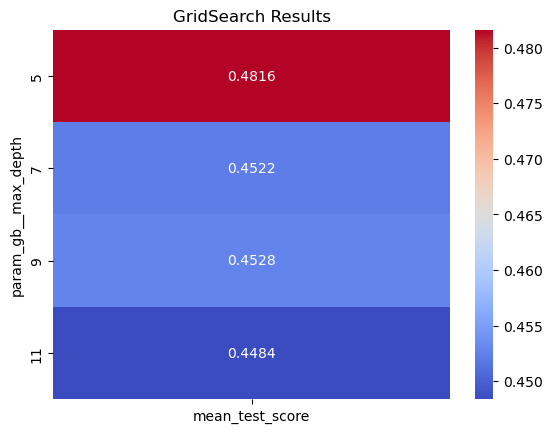

Minimum validation ECM: 0.413


In [43]:
# Getting the average test scores
lgbm_p_results = pd.DataFrame(lgbm_p_grid.cv_results_)
lgbm_p_results['mean_test_score'] = abs(lgbm_p_results['mean_test_score'])

# Plotting the test scores
lgbm_p_heatmap_data = pd.pivot_table(data=lgbm_p_results, values='mean_test_score', index='param_gb__max_depth')
sns.heatmap(lgbm_p_heatmap_data, annot=True, fmt='.4g', cmap='coolwarm')
plt.title('GridSearch Results')
plt.show()

# Printing the minimum validation ECM and the index of the best parameter
print('Minimum validation ECM:', round(min(lgbm_p_results['mean_test_score']),3))

In [44]:
# Best parameter
lgbm_p_best_param = lgbm_p_grid.best_params_
print(lgbm_p_best_param)

# Get the best model from the grid search
lgbm_p_best_model = lgbm_p_grid.best_estimator_

# Predict on the test data using the best parameters
lgbm_y_p_pred = lgbm_p_best_model.predict(X_plgbm_test)
lgbm_y_p_pred_proba = lgbm_p_best_model.predict_proba(X_plgbm_test)[:, 1]

{'gb__learning_rate': 0.1, 'gb__max_depth': 7, 'gb__min_child_samples': 75, 'gb__num_leaves': 19, 'gb__reg_lambda': 5}


In [45]:
# Calculate the custom scorer for different threshold values
thresholds = np.arange(0.0, 1.0, 0.00001)
scores = []
for threshold in thresholds:
    preds = (lgbm_y_p_pred_proba >= threshold).astype(int)
    score = ECM(y_plgbm_test.values.ravel(), preds)
    scores.append(score)

# Find the threshold that gives the best score
lgbm_p_best_threshold = thresholds[np.argmin(scores)]
print("Best threshold:", lgbm_p_best_threshold)

# Adjusting predictions based on optimal threshold
lgbm_y_p_pred = lgbm_y_p_pred_proba >= lgbm_p_best_threshold

# Calculating the various performance metrics
lgbm_p_roc_auc = roc_auc_score(y_plgbm_test.values.ravel(), lgbm_y_p_pred_proba)
lgbm_p_tn, lgbm_p_fp, lgbm_p_fn, lgbm_p_tp = confusion_matrix(y_plgbm_test.values.ravel(), lgbm_y_p_pred).ravel()
lgbm_p_sensitivity = lgbm_p_tp / (lgbm_p_tp + lgbm_p_fn)
lgbm_p_specificity = lgbm_p_tn / (lgbm_p_tn + lgbm_p_fp)
lgbm_p_accuracy = accuracy_score(y_plgbm_test.values.ravel(),lgbm_y_p_pred)
lgbm_p_f1 = f1_score(y_plgbm_test.values.ravel(), lgbm_y_p_pred)
lgbm_p_ecm_score = ECM(y_plgbm_test.values.ravel(),lgbm_y_p_pred)

# Printing the performance metrics
print("ROC AUC Score: {:.3f}".format(lgbm_p_roc_auc))
print("Accuracy Score: {:.3f}".format(lgbm_p_accuracy))
print("Specificity Score: {:.3f}".format(lgbm_p_specificity))
print("Sensitivity Score: {:.3f}".format(lgbm_p_sensitivity))
print("F1 Score: {:.3f}".format(lgbm_p_f1))
print("ECM: {:.3f}".format(lgbm_p_ecm_score))

Best threshold: 0.02442
ROC AUC Score: 0.646
Accuracy Score: 0.812
Specificity Score: 0.819
Sensitivity Score: 0.440
F1 Score: 0.074
ECM: 0.538


In [209]:
# Start timer
start_time = time.time()

# Fit model on data
lgbm_p_best_model.fit(X_plgbm_train, y_plgbm_train)

# End timer
end_time = time.time()

# Calculate time taken to fit model
time_taken = end_time - start_time

# Print time taken
print(f"Time taken to fit PSO LGBM: {time_taken:.5f} seconds")

Time taken to fit PSO LGBM: 0.33996 seconds


## Variable Importance - SAPSO LGBM

In [25]:
# Get the feature importances from the LGBMClassifier
feature_importances = lgbm_f_best_model.named_steps["gb"].feature_importances_

# Get the feature names from the column names of the training data
feature_names = X_f_train.columns

# Create a dictionary of feature names and their importance scores
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Create a dataframe from the dictionary
df_feature_importances = pd.DataFrame.from_dict(feature_importance_dict, orient='index', columns=['Importance'])

# Sort the dataframe by importance score in descending order
df_feature_importances = df_feature_importances.sort_values(by='Importance', ascending=False)

# Print the dataframe
print(df_feature_importances)

             Importance
IoAR                 74
DCS                  63
Length_MDA           49
Lev                  47
UEP                  44
...                 ...
Topic_Q4_38           0
Topic_Q4_37           0
Topic_Q4_36           0
Topic_Q4_35           0
SIC_9997.0            0

[638 rows x 1 columns]


In [26]:
df_feature_importances

,Importance
IoAR,74
DCS,63
Length_MDA,49
Lev,47
UEP,44
...,...
Topic_Q4_38,0
Topic_Q4_37,0
Topic_Q4_36,0
Topic_Q4_35,0
